In [1]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/SeismicWorld'
# !git clone https://github.com/bytedance/VideoWorld.git
!pip install prettytable
!pip install rotary-embedding-torch
!pip install kornia
!pip install gateloop_transformer
!pip install webdataset

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.8 MB/s eta 0:00:00


In [2]:
#@title utilities
import torch

def tensor_allclose(a, b, atol=1e-8, rtol=1e-5):
    """
    比较两个张量是否满足：
    |a - b| ≤ atol + rtol * |b|

    参数：
    a, b: 要比较的PyTorch张量
    atol: 绝对容差（默认1e-8）
    rtol: 相对容差（默认1e-5）

    返回：
    bool: 是否所有元素都满足容差要求
    """
    if a.shape != b.shape:
        raise ValueError("张量形状不匹配")

    return torch.allclose(a, b, atol=atol, rtol=rtol)

import torch
import matplotlib.pyplot as plt

def compare_4d_slices(tensor1, tensor2,
                     dim=1,  # 切片维度：1(x),2(y),3(z)
                     index=0,  # 切片索引
                     atol=1e-5,
                     rtol=1e-3,
                     save_path=None  # 新增，保存路径（如 'result.pdf'）
                     ):
    """
    四维张量切片对比工具
    返回：
    - 差异统计指标
    - 可视化对比图
    用例：
    # 比较通道维度第50层的切片并保存为PDF
    stats, fig = compare_4d_slices(tensor1, tensor2, dim=1, index=50, save_path='compare.pdf')
    plt.show()
    print(stats)
    """

    # 维度验证
    assert tensor1.shape == tensor2.shape, "张量形状必须相同"
    assert tensor1.dim() == 4, "输入必须是四维张量"
    assert 1 <= dim <= 3, "切片维度需在[1,3]范围内"

    # 切片提取（保持四维结构）
    if dim == 1:
        slice1 = tensor1[0, index, ...]
        slice2 = tensor2[0, index, ...]
    elif dim == 2:
        slice1 = tensor1[0, :, index, ...]
        slice2 = tensor2[0, :, index, ...]
    elif dim == 3 or dim == -1:
        slice1 = tensor1[0, ..., index]
        slice2 = tensor2[0, ..., index]

    # 差异计算
    abs_diff = torch.abs(slice1 - slice2)
    rel_diff = abs_diff / (torch.abs(slice2) + atol)  # 避免除零

    # 统计指标
    stats = {
        'max_abs': abs_diff.max().item(),
        'mean_abs': abs_diff.mean().item(),
        'rel_over_threshold': (rel_diff > rtol).sum().item() / slice1.numel()
    }

    # 可视化
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # 原始数据可视化（取三维切片中间层）
    im0 = axes[0, 0].imshow(slice1.cpu().numpy(), cmap='turbo')
    axes[0, 0].set_title(f'Tensor1 Slice {dim}-{index}')
    plt.colorbar(im0, ax=axes[0, 0])

    im1 = axes[0, 1].imshow(slice2.cpu().numpy(), cmap='turbo')
    axes[0, 1].set_title(f'Tensor2 Slice {dim}-{index}')
    plt.colorbar(im1, ax=axes[0, 1])

    # 差异热图
    diff_map = axes[0, 2].imshow(abs_diff.cpu(), cmap='hot')
    plt.colorbar(diff_map, ax=axes[0, 2])
    axes[0, 2].set_title('Absolute Difference')

    # 差异分布直方图
    axes[1, 0].hist(abs_diff.flatten().cpu().numpy(), bins=50)
    axes[1, 0].set_xlabel('Absolute Difference')
    axes[1, 0].set_ylabel('Frequency')

    # 相对差异分布
    axes[1, 1].hist(rel_diff.flatten().cpu().numpy(), bins=50)
    axes[1, 1].set_xlabel('Relative Difference')

    plt.tight_layout()

    # 新增：保存为PDF
    if save_path is not None:
        plt.savefig(save_path, format='pdf')
        print(f'Figure saved to {save_path}')

    return stats, fig


import matplotlib.pyplot as plt
import numpy as np

def plot(tensor):
    """
    绘制一个 2D 张量

    参数:
    tensor: PyTorch 张量，形状为 [H, W]
    """
    # 将张量转换为 NumPy 数组
    if tensor.is_cuda:
        tensor = tensor.detach().cpu()

    img = tensor.numpy()

    # 创建图形
    plt.figure(figsize=(8, 6))

    # 绘制热图
    im = plt.imshow(img, cmap='viridis')

    # 添加颜色条
    plt.colorbar(im, label='值')

    # 添加标题和轴标签
    plt.title('地震数据切片可视化')
    plt.xlabel('X')
    plt.ylabel('Y')

    # 显示图形
    plt.tight_layout()
    plt.show()

def downsample_3d_time_aware(x, target_size=(128, 128)):
    B, C, T, H, W = x.shape
    results = []

    # 逐时间步处理
    for t in range(T):
        time_slice = x[:, :, t, :, :]  # [B, C, H, W]
        down_slice = F.interpolate(
            time_slice,
            size=target_size,
            mode='bilinear',
            align_corners=False
        )
        results.append(down_slice)

    return torch.stack(results, dim=2)  # 重组时间维度

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, signal
from scipy.stats import skew, kurtosis
from skimage.feature import local_binary_pattern

# 首先，将您的数据重新组织为列表格式
def prepare_seismic_dataset(fine_tune_video_slices):
    """
    将torch张量转换为地震数据列表
    输入: torch.Size([34560, 2, 64, 64])
    输出: 地震数据列表，每个元素为64x64的numpy数组
    """
    seismic_dataset = []

    # 转换为numpy数组
    if isinstance(fine_tune_video_slices, torch.Tensor):
        data_numpy = fine_tune_video_slices.cpu().numpy()
    else:
        data_numpy = fine_tune_video_slices

    print(f"原始数据形状: {data_numpy.shape}")

    # 遍历每个样本
    for i in range(data_numpy.shape[0]):
        # 对于每个样本的2个通道，我们有几种处理方式：

        # 方式1: 分别处理两个通道（推荐用于地震数据）
        for channel in range(data_numpy.shape[1]):
            seismic_slice = data_numpy[i, channel, :, :]  # 64x64
            seismic_dataset.append(seismic_slice)

        # 方式2: 如果您想合并两个通道，可以使用以下代码替代上面的循环
        # combined_slice = np.mean(data_numpy[i, :, :, :], axis=0)  # 平均两个通道
        # seismic_dataset.append(combined_slice)

        # 方式3: 如果您只想使用第一个通道
        # seismic_slice = data_numpy[i, 0, :, :]
        # seismic_dataset.append(seismic_slice)

    print(f"转换后数据集大小: {len(seismic_dataset)}")
    print(f"每个地震切片形状: {seismic_dataset[0].shape}")

    return seismic_dataset

# 质量评估算法的完整实现
def calculate_snr(seismic_data):
    """计算信噪比"""
    signal_estimate = ndimage.median_filter(seismic_data, size=3)
    noise = seismic_data - signal_estimate

    signal_power = np.mean(signal_estimate**2)
    noise_power = np.mean(noise**2)

    snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
    return snr

def evaluate_coherence(seismic_data):
    """评估同相轴的连续性和清晰度"""
    grad_x = np.gradient(seismic_data, axis=1)
    grad_y = np.gradient(seismic_data, axis=0)

    Jxx = ndimage.gaussian_filter(grad_x**2, sigma=2)
    Jxy = ndimage.gaussian_filter(grad_x * grad_y, sigma=2)
    Jyy = ndimage.gaussian_filter(grad_y**2, sigma=2)

    trace = Jxx + Jyy
    det = Jxx * Jyy - Jxy**2

    coherence = np.where(trace > 0,
                        (trace - 2*np.sqrt(np.maximum(det, 0) + 1e-10)) / (trace + 1e-10),
                        0)

    return np.mean(coherence)

def analyze_frequency_content(seismic_data):
    """分析频谱内容的质量"""
    fft_traces = np.fft.fft(seismic_data, axis=0)
    power_spectrum = np.abs(fft_traces)**2

    freq_axis = np.fft.fftfreq(seismic_data.shape[0])
    valid_freq_mask = (np.abs(freq_axis) >= 0.1) & (np.abs(freq_axis) <= 0.4)

    total_energy = np.sum(power_spectrum, axis=0)
    valid_energy = np.sum(power_spectrum[valid_freq_mask], axis=0)

    frequency_quality = np.mean(valid_energy / (total_energy + 1e-10))
    return frequency_quality

def calculate_texture_complexity(seismic_data):
    """计算纹理复杂度"""
    normalized_data = (seismic_data - np.mean(seismic_data)) / (np.std(seismic_data) + 1e-10)

    lbp = local_binary_pattern(normalized_data, P=8, R=1, method='uniform')

    hist, _ = np.histogram(lbp.ravel(), bins=10, density=True)
    hist = hist + 1e-10
    entropy = -np.sum(hist * np.log2(hist))

    texture_regularity = 1.0 / (1.0 + entropy)
    return texture_regularity

def amplitude_statistics(seismic_data):
    """计算振幅统计特征"""
    std_amp = np.std(seismic_data)

    skewness = abs(skew(seismic_data.ravel()))
    kurt = abs(kurtosis(seismic_data.ravel()))

    amplitude_quality = 1.0 / (1.0 + skewness + kurt/10.0)
    dynamic_range = (np.max(seismic_data) - np.min(seismic_data)) / (std_amp + 1e-10)

    return amplitude_quality, dynamic_range

def comprehensive_quality_assessment(seismic_data):
    """综合质量评估"""
    try:
        snr = calculate_snr(seismic_data)
        coherence = evaluate_coherence(seismic_data)
        freq_quality = analyze_frequency_content(seismic_data)
        texture_reg = calculate_texture_complexity(seismic_data)
        amp_quality, dyn_range = amplitude_statistics(seismic_data)

        # 权重设置
        weights = {
            'snr': 0.30,
            'coherence': 0.30,
            'frequency': 0.10,
            'texture': 0.10,
            'amplitude': 0.50
        }

        # 标准化各指标到[0,1]范围
        snr_norm = np.clip((snr + 10) / 20, 0, 1)
        coherence_norm = np.clip(coherence, 0, 1)
        freq_norm = np.clip(freq_quality, 0, 1)
        texture_norm = np.clip(texture_reg, 0, 1)
        amp_norm = np.clip(amp_quality, 0, 1)

        # 计算综合质量分数
        quality_score = (weights['snr'] * snr_norm +
                        weights['coherence'] * coherence_norm +
                        weights['frequency'] * freq_norm +
                        weights['texture'] * texture_norm +
                        weights['amplitude'] * amp_norm)

        quality_metrics = {
            'overall_score': quality_score,
            'snr': snr,
            'coherence': coherence,
            'frequency_quality': freq_quality,
            'texture_regularity': texture_reg,
            'amplitude_quality': amp_quality,
            'dynamic_range': dyn_range
        }

        return quality_metrics

    except Exception as e:
        print(f"质量评估出错: {e}")
        # 返回低质量分数
        return {
            'overall_score': 0.0,
            'snr': -20,
            'coherence': 0.0,
            'frequency_quality': 0.0,
            'texture_regularity': 0.0,
            'amplitude_quality': 0.0,
            'dynamic_range': 0.0
        }

def filter_dataset(seismic_dataset, quality_threshold=0.5, batch_size=1000):
    """过滤数据集，移除低质量数据（批量处理以提高效率）"""

    high_quality_data = []
    quality_scores = []
    high_quality_indices = []  # 保存高质量数据的原始索引

    total_samples = len(seismic_dataset)

    print(f"开始处理 {total_samples} 个地震数据样本...")

    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        print(f"处理进度: {i+1}-{batch_end}/{total_samples} ({(batch_end/total_samples)*100:.1f}%)")

        for j in range(i, batch_end):
            seismic_data = seismic_dataset[j]
            metrics = comprehensive_quality_assessment(seismic_data)
            quality_scores.append(metrics['overall_score'])

            if metrics['overall_score'] >= quality_threshold:
                high_quality_data.append(seismic_data)
                high_quality_indices.append(j)

            # 每1000个样本输出一次详细信息
            if (j + 1) % 1000 == 0:
                print(f"  样本 {j+1}: 质量分数 = {metrics['overall_score']:.3f}")

    print(f"\n=== 过滤结果 ===")
    print(f"原始数据集大小: {len(seismic_dataset)}")
    print(f"过滤后数据集大小: {len(high_quality_data)}")
    print(f"过滤率: {(1 - len(high_quality_data)/len(seismic_dataset))*100:.1f}%")
    print(f"平均质量分数: {np.mean(quality_scores):.3f}")
    print(f"质量分数标准差: {np.std(quality_scores):.3f}")

    return high_quality_data, quality_scores, high_quality_indices

def convert_back_to_tensor(filtered_dataset, original_shape):
    """将过滤后的数据转换回张量格式"""
    # 假设原始数据是按通道分离的，需要重新组合
    num_samples = len(filtered_dataset) // 2  # 因为每个原始样本产生了2个通道

    if num_samples * 2 != len(filtered_dataset):
        print("警告: 过滤后的数据数量不是偶数，可能存在不完整的样本对")
        num_samples = len(filtered_dataset) // 2

    # 重新组织数据
    filtered_array = np.zeros((num_samples, 2, 64, 64))

    for i in range(num_samples):
        filtered_array[i, 0, :, :] = filtered_dataset[i * 2]      # 第一个通道
        filtered_array[i, 1, :, :] = filtered_dataset[i * 2 + 1]  # 第二个通道

    return torch.from_numpy(filtered_array).float()




In [3]:
#@title SeismicWorld 数据处理函数集合

import torch
import numpy as np
import matplotlib.pyplot as plt

def process_seismic_for_world(seismic_data):
    """
    处理地震数据用于SeismicWorld训练
    输入: seismic_data [b, t, X, Y, Z] = [20, 9, 64, 64, 64]
    输出: 沿X轴切片的视频数据 [b*X, t, Y, Z]
    """
    b, t, X, Y, Z = seismic_data.shape
    print(f"原始数据形状: {seismic_data.shape}")

    # 重新排列维度，将X轴作为batch维度
    # [b, t, X, Y, Z] -> [b, X, t, Y, Z] -> [b*X, t, Y, Z]
    seismic_slices = seismic_data.permute(0, 2, 1, 3, 4)  # [b, X, t, Y, Z]
    seismic_slices = seismic_slices.reshape(b * X, t, Y, Z)  # [b*X, t, Y, Z]

    print(f"处理后形状: {seismic_slices.shape}")
    print(f"现在有 {b*X} 个视频切片，每个视频有 {t} 帧，分辨率为 {Y}×{Z}")

    return seismic_slices

def reconstruct_4d_seismic(predicted_slices, original_batch_size, original_time_steps=9,
                          original_x_size=64, original_y_size=64, original_z_size=64):
    """
    将SeismicWorld预测的64个切片重新组合成4D时移地震体

    参数:
    - predicted_slices: [b*X, t, Y, Z] 预测的切片数据
    - original_batch_size: 原始batch大小
    - original_time_steps: 时间步数
    - original_x_size: X维度大小
    - original_y_size: Y维度大小
    - original_z_size: Z维度大小

    返回: [b, t, X, Y, Z] 重构的4D地震体
    """
    print(f"输入预测切片形状: {predicted_slices.shape}")

    # 确保输入形状正确
    total_slices, t, Y, Z = predicted_slices.shape
    expected_slices = original_batch_size * original_x_size

    if total_slices != expected_slices:
        raise ValueError(f"切片数量不匹配: 期望 {expected_slices}, 实际 {total_slices}")

    # 重新整形为 [b, X, t, Y, Z]
    reconstructed = predicted_slices.reshape(original_batch_size, original_x_size, t, Y, Z)

    # 重新排列维度为 [b, t, X, Y, Z]
    reconstructed = reconstructed.permute(0, 2, 1, 3, 4)

    print(f"重构后4D地震体形状: {reconstructed.shape}")

    return reconstructed

def compare_original_vs_reconstructed(original_data, reconstructed_data,
                                    batch_idx=0, time_idx=4, x_slice=32):
    """
    比较原始数据和重构数据的可视化
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 原始数据切片
    orig_slice = original_data[batch_idx, time_idx, x_slice, :, :].cpu().numpy()
    axes[0].imshow(orig_slice, cmap='seismic', aspect='auto')
    axes[0].set_title(f'Original (B:{batch_idx}, T:{time_idx}, X:{x_slice})')
    axes[0].axis('off')

    # 重构数据切片
    recon_slice = reconstructed_data[batch_idx, time_idx, x_slice, :, :].cpu().numpy()
    axes[1].imshow(recon_slice, cmap='seismic', aspect='auto')
    axes[1].set_title(f'Reconstructed (B:{batch_idx}, T:{time_idx}, X:{x_slice})')
    axes[1].axis('off')

    # 差异图
    diff = orig_slice - recon_slice
    im = axes[2].imshow(diff, cmap='RdBu', aspect='auto')
    axes[2].set_title(f'Difference')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])

    plt.tight_layout()
    plt.show()

    # 计算重构误差统计
    mse = torch.mean((original_data - reconstructed_data) ** 2).item()
    mae = torch.mean(torch.abs(original_data - reconstructed_data)).item()
    print(f"重构误差 - MSE: {mse:.6f}, MAE: {mae:.6f}")

def visualize_slice_time_series(seismic_data, batch_idx=0, x_slice=32):
    """
    可视化某个X切片的时间序列
    """
    slice_data = seismic_data[batch_idx, :, x_slice, :, :]  # [t, Y, Z]
    t_steps = slice_data.shape[0]

    cols = 4
    rows = (t_steps + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(t_steps):
        row, col = i // cols, i % cols
        axes[row, col].imshow(slice_data[i].cpu().numpy(), cmap='seismic', aspect='auto')
        axes[row, col].set_title(f'Time step {i}')
        axes[row, col].axis('off')

    # 隐藏多余的子图
    for i in range(t_steps, rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.suptitle(f'X-slice {x_slice} through time (Batch {batch_idx})', y=1.02)
    plt.show()

def format_as_video_batches(processed_data, videos_per_batch=64):
    """
    将处理后的数据重新组织成视频批次（可选功能）
    """
    total_videos, t, h, w = processed_data.shape

    if total_videos % videos_per_batch == 0:
        num_batches = total_videos // videos_per_batch
        video_batches = processed_data.reshape(num_batches, videos_per_batch, t, h, w)
        print(f"重新组织为 {num_batches} 个批次，每批次 {videos_per_batch} 个视频")
        return video_batches
    else:
        print(f"警告: 总视频数 {total_videos} 不能被 {videos_per_batch} 整除")
        return processed_data

def create_differenced_seismic_data(seismic_data):
    """
    Creates a differenced version of the seismic data along the time axis.

    Args:
        seismic_data (torch.Tensor): Input data with shape [b, t, X, Y, Z].

    Returns:
        torch.Tensor: Differenced data of the same shape, where frame t > 0
                      is replaced by frame[t] - frame[t-1]. Frame 0 remains unchanged.
    """
    if not isinstance(seismic_data, torch.Tensor):
        raise TypeError("Input data must be a PyTorch tensor.")
    if seismic_data.dim() != 5:
        raise ValueError("Input data must have 5 dimensions [b, t, X, Y, Z].")

    b, t, X, Y, Z = seismic_data.shape
    print(f"Original data shape for differencing: {seismic_data.shape}")

    # Initialize the output tensor with the same shape and type
    differenced_data = torch.zeros_like(seismic_data)

    # Keep the first frame (t=0) as is
    differenced_data[:, 0, :, :, :] = seismic_data[:, 0, :, :, :]

    # Calculate the difference for subsequent frames (t=1 to t-1)
    for i in range(1, t):
        differenced_data[:, i, :, :, :] = seismic_data[:, i, :, :, :] - seismic_data[:, i-1, :, :, :]

    print(f"Differenced data shape: {differenced_data.shape}")
    return differenced_data

def normalize_data(data, eps=1e-8):
    """
    Normalizes data using global mean and standard deviation.

    Args:
        data (torch.Tensor): Input data tensor.
        eps (float): Small value to prevent division by zero.

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
            - normalized_data: Tensor with normalized values.
            - mean: Calculated mean of the input data.
            - std: Calculated standard deviation of the input data.
    """
    if not isinstance(data, torch.Tensor):
        raise TypeError("Input data must be a PyTorch tensor.")

    # Calculate global mean and std
    # NOTE: For actual training, calculate these stats over the entire training dataset
    #       and reuse them for validation/testing and normalization here.
    #       Calculating per-tensor here for demonstration purposes.
    mean = torch.mean(data.float()) # Ensure float for calculation
    std = torch.std(data.float())

    print(f"Normalizing data: Mean={mean.item():.4f}, Std={std.item():.4f}")

    normalized_data = (data - mean) / (std + eps)
    return normalized_data, mean, std

def denormalize_data(normalized_data, mean, std, eps=1e-8):
    """
    Reverses the normalization process.

    Args:
        normalized_data (torch.Tensor): Data that was previously normalized.
        mean (torch.Tensor or float): Mean used during normalization.
        std (torch.Tensor or float): Standard deviation used during normalization.
        eps (float): Small value used during normalization's division.

    Returns:
        torch.Tensor: Data restored to its original scale.
    """
    if not isinstance(normalized_data, torch.Tensor):
        raise TypeError("Input normalized_data must be a PyTorch tensor.")

    print(f"Denormalizing data using: Mean={mean.item():.4f}, Std={std.item():.4f}")
    original_scale_data = normalized_data * (std + eps) + mean
    return original_scale_data

def recover_absolute_frames(differenced_data):
    """
    Recovers absolute frames from differenced data [frame_0, diff_1, diff_2, ...].

    Args:
        differenced_data (torch.Tensor): Data in differenced format,
                                         shape [b, t, X, Y, Z].

    Returns:
        torch.Tensor: Data with absolute frame values, shape [b, t, X, Y, Z].
    """
    if not isinstance(differenced_data, torch.Tensor):
        raise TypeError("Input differenced_data must be a PyTorch tensor.")
    if differenced_data.dim() != 5:
        raise ValueError("Input differenced_data must have 5 dimensions [b, t, X, Y, Z].")

    b, t, X, Y, Z = differenced_data.shape
    print(f"Recovering absolute frames from shape: {differenced_data.shape}")

    recovered_data = torch.zeros_like(differenced_data)

    # First frame is already absolute
    recovered_data[:, 0, :, :, :] = differenced_data[:, 0, :, :, :]

    # Cumulatively add differences for subsequent frames
    for i in range(1, t):
        recovered_data[:, i, :, :, :] = recovered_data[:, i-1, :, :, :] + differenced_data[:, i, :, :, :]

    print(f"Recovered absolute data shape: {recovered_data.shape}")
    return recovered_data

def seismic_world_diff_norm_workflow_demo(seismic_data):
    """
    Complete workflow: differencing, normalization, processing,
    simulated prediction, reconstruction, denormalization, recovery.
    """
    print("=== SeismicWorld Differencing & Normalization Workflow ===\n")
    original_shape = seismic_data.shape
    b, t, X, Y, Z = original_shape

    # Step 1: Create differenced data
    print("Step 1: Create differenced data")
    differenced_seismic_data = create_differenced_seismic_data(seismic_data)

    # Step 2: Normalize the differenced data
    print("\nStep 2: Normalize the differenced data")
    # NOTE: In a real scenario, 'data_mean' and 'data_std' should be pre-calculated
    #       on the training set and loaded here.
    normalized_diff_data, data_mean, data_std = normalize_data(differenced_seismic_data)
    # Keep mean/std safe, they are needed later!

    # Step 3: Process normalized differenced data for VQ-VAE input (slicing)
    print("\nStep 3: Process normalized differenced data into video slices")
    normalized_diff_video = process_seismic_for_world(normalized_diff_data)
    # Shape: [b*X, t, Y, Z]

    # Step 4: Simulate VQ-VAE Prediction
    # The model predicts the *normalized differenced slices*
    print("\nStep 4: Simulate VQ-VAE prediction (using processed input as placeholder)")
    predicted_normalized_diff_video = normalized_diff_video.clone() # Perfect reconstruction assumed

    # --- Recovery Steps ---

    # Step 5: Reconstruct the 4D shape from predicted slices
    print("\nStep 5: Reconstruct 4D shape from predicted normalized slices")
    predicted_normalized_diff_4d = reconstruct_4d_seismic(
        predicted_normalized_diff_video,
        original_batch_size=b,
        original_time_steps=t,
        original_x_size=X,
        original_y_size=Y,
        original_z_size=Z
    )
    # Shape: [b, t, X, Y, Z]

    # Step 6: Denormalize the reconstructed 4D prediction
    print("\nStep 6: Denormalize the reconstructed 4D data")
    predicted_diff_4d = denormalize_data(predicted_normalized_diff_4d, data_mean, data_std)
    # Shape: [b, t, X, Y, Z], values are back to the scale of differenced data

    # Step 7: Recover absolute frames from the denormalized differenced data
    print("\nStep 7: Recover absolute frames from denormalized differenced data")
    reconstructed_absolute_4d = recover_absolute_frames(predicted_diff_4d)
    # Shape: [b, t, X, Y, Z], values are back to the original absolute scale

    # Step 8: Compare final recovered data with original input
    print("\nStep 8: Compare original data vs fully recovered data")
    compare_original_vs_reconstructed(seismic_data, reconstructed_absolute_4d)

    return reconstructed_absolute_4d

# 主要工作流程示例
def seismic_world_workflow_demo(seismic_data):
    """
    完整的SeismicWorld工作流程演示
    """
    print("=== SeismicWorld 数据处理工作流程 ===\n")

    # 步骤1: 处理数据用于训练
    print("步骤1: 处理4D地震数据为切片视频")
    processed_slices = process_seismic_for_world(seismic_data)

    # 步骤2: 模拟SeismicWorld预测（这里用原始数据模拟）
    print("\n步骤2: SeismicWorld模型预测（此处用原始数据模拟）")
    predicted_slices = processed_slices.clone()  # 实际使用时这里是模型预测结果

    # 步骤3: 重构4D地震体
    print("\n步骤3: 重构4D地震体")
    reconstructed_4d = reconstruct_4d_seismic(
        predicted_slices,
        original_batch_size=seismic_data.shape[0],
        original_time_steps=seismic_data.shape[1],
        original_x_size=seismic_data.shape[2],
        original_y_size=seismic_data.shape[3],
        original_z_size=seismic_data.shape[4]
    )

    # 步骤4: 验证重构质量
    print("\n步骤4: 验证重构质量")
    compare_original_vs_reconstructed(seismic_data, reconstructed_4d)

    return processed_slices, reconstructed_4d




In [4]:
#@title 读取Sleipner 4D Seismic Dataset的三维地震体
import matplotlib.pyplot as plt
import numpy as np
import os

# Install required libraries
try:
    import segyio
    print("segyio库已安装")
except ImportError:
    print("正在安装segyio库...")
    !pip install segyio
    import segyio

# Define file paths
file_paths = {
    # '1994-2001': '/content/drive/MyDrive/SeismicWorld/dataset/94p01 2001 processing/data/94p01mid.sgy',
    # '1999-2001': '/content/drive/MyDrive/SeismicWorld/dataset/99p01 2001 processing/data/99p01mid.sgy',
    # '2001-2001': '/content/drive/MyDrive/SeismicWorld/dataset/01p01 2001 processing/data/01p01mid.sgy',

    # '2010-2011': '/content/drive/MyDrive/SeismicWorld/dataset/10p11 2011 Imaging processing/data/10p11mid',
    '2008-2008': '/content/drive/MyDrive/SeismicWorld/dataset/08p08/2008 processing/data/08p08mid.sgy',
    '2010-2010': '/content/drive/MyDrive/SeismicWorld/dataset/10p10/2010 Time-lapse processing/data/10p10mid',

     '2006-2007': '/content/drive/MyDrive/SeismicWorld/dataset/06p07/2007 processing/data/06p07mid.sgy',
     '1994-2007': '/content/drive/MyDrive/SeismicWorld/dataset/94p07 2007 processing/data/94p07mid.sgy',
     '2001-2007': '/content/drive/MyDrive/SeismicWorld/dataset/01p07/2007 processing/data/01p07mid.sgy',
     '2004-2007': '/content/drive/MyDrive/SeismicWorld/dataset/04p07/2007 processing/data/04p07mid.sgy',

}

def analyze_segy_structure(file_path):
    """分析SEG-Y文件的3D结构"""
    try:
        with segyio.open(file_path, 'r') as segy:
            info = {
                'traces': segy.tracecount,
                'samples': len(segy.samples),
                'sample_interval': segy.bin[segyio.BinField.Interval],
                'sample_rate': segy.bin[segyio.BinField.Interval] / 1000,
                'format': segy.format,
                'sorting': segy.sorting,
                'is_3d': False,
                'geometry': 'Unknown'
            }

            # 检查是否为3D数据
            try:
                # 尝试获取inline和crossline信息
                if hasattr(segy, 'ilines') and hasattr(segy, 'xlines'):
                    info['is_3d'] = True
                    info['geometry'] = '3D Structured'
                    info['ilines'] = list(segy.ilines)[:10]  # 前10个inline号
                    info['xlines'] = list(segy.xlines)[:10]  # 前10个crossline号
                    info['n_ilines'] = len(segy.ilines)
                    info['n_xlines'] = len(segy.xlines)
                    info['cube_shape'] = (info['n_ilines'], info['n_xlines'], info['samples'])

                    print(f"✅ 检测到3D地震数据!")
                    print(f"   Inline范围: {min(segy.ilines)} - {max(segy.ilines)} (共{len(segy.ilines)}条)")
                    print(f"   Crossline范围: {min(segy.xlines)} - {max(segy.xlines)} (共{len(segy.xlines)}条)")
                    print(f"   3D数据体形状: {info['cube_shape']}")

                else:
                    # 尝试通过header分析几何结构
                    inline_set = set()
                    xline_set = set()

                    # 检查前1000道的inline/crossline信息
                    sample_size = min(1000, segy.tracecount)
                    for i in range(sample_size):
                        try:
                            iline = segy.header[i][segyio.TraceField.INLINE_3D]
                            xline = segy.header[i][segyio.TraceField.CROSSLINE_3D]
                            if iline != 0: inline_set.add(iline)
                            if xline != 0: xline_set.add(xline)
                        except:
                            pass

                    if len(inline_set) > 1 and len(xline_set) > 1:
                        info['is_3d'] = True
                        info['geometry'] = '3D Unstructured'
                        info['estimated_ilines'] = len(inline_set)
                        info['estimated_xlines'] = len(xline_set)
                        print(f"✅ 检测到3D地震数据 (非结构化)")
                        print(f"   估计Inline数量: {len(inline_set)}")
                        print(f"   估计Crossline数量: {len(xline_set)}")
                    else:
                        info['geometry'] = '2D Profile'
                        print(f"📏 检测到2D地震剖面")

            except Exception as e:
                print(f"⚠️ 3D结构分析出错: {e}")
                info['geometry'] = '2D Profile'

            # 获取坐标信息
            try:
                sample_traces = min(100, segy.tracecount)
                x_coords = []
                y_coords = []

                for i in range(sample_traces):
                    x = segy.header[i][segyio.TraceField.SourceX] or segy.header[i][segyio.TraceField.CDP_X]
                    y = segy.header[i][segyio.TraceField.SourceY] or segy.header[i][segyio.TraceField.CDP_Y]
                    if x != 0: x_coords.append(x)
                    if y != 0: y_coords.append(y)

                if x_coords and y_coords:
                    info['x_range'] = (min(x_coords), max(x_coords))
                    info['y_range'] = (min(y_coords), max(y_coords))
                else:
                    info['x_range'] = 'N/A'
                    info['y_range'] = 'N/A'
            except:
                info['x_range'] = 'N/A'
                info['y_range'] = 'N/A'

        return info

    except Exception as e:
        print(f"❌ 文件分析失败: {e}")
        return None

def load_3d_seismic_data(file_path, max_inlines=None):
    """加载3D地震数据"""
    try:
        with segyio.open(file_path, 'r') as segy:
            if hasattr(segy, 'ilines') and hasattr(segy, 'xlines'):
                # 结构化3D数据
                if max_inlines:
                    ilines_to_read = list(segy.ilines)[:max_inlines]
                else:
                    ilines_to_read = list(segy.ilines)

                # 读取3D数据体
                cube = segyio.tools.cube(segy)

                # 创建时间轴
                dt = segy.bin[segyio.BinField.Interval] / 1000
                time_axis = np.arange(len(segy.samples)) * dt

                return cube, time_axis, list(segy.ilines), list(segy.xlines)
            else:
                # 2D数据或非结构化数据
                data = np.array([segy.trace[i] for i in range(min(5000, segy.tracecount))])
                dt = segy.bin[segyio.BinField.Interval] / 1000
                time_axis = np.arange(len(segy.samples)) * dt
                return data, time_axis, None, None

    except Exception as e:
        print(f"❌ 数据加载失败: {e}")
        return None, None, None, None

# 主分析流程
seismic_data = {}
print("=" * 70)
print("SLEIPNER 4D SEISMIC DATASET - 3D结构分析")
print("=" * 70)

for year, file_path in file_paths.items():
    print(f"\n🔍 分析 {year}年数据集:")
    print(f"文件路径: {file_path}")

    if not os.path.exists(file_path):
        print(f"❌ 文件不存在: {file_path}")
        continue

    # 获取文件大小
    file_size = os.path.getsize(file_path) / (1024**2)
    print(f"文件大小: {file_size:.2f} MB")

    # 分析文件结构
    info = analyze_segy_structure(file_path)

    if info:
        print(f"   总道数: {info['traces']:,}")
        print(f"   采样点数: {info['samples']:,}")
        print(f"   采样间隔: {info['sample_interval']} μs")
        print(f"   数据格式: {info['format']}")
        print(f"   排序方式: {info['sorting']}")
        print(f"   几何结构: {info['geometry']}")
        print(f"   坐标范围: X{info['x_range']}, Y{info['y_range']}")

        # 加载数据
        print(f"   正在加载数据...")
        if info['is_3d']:
            cube, time_axis, ilines, xlines = load_3d_seismic_data(file_path, max_inlines=10)
            if cube is not None:
                seismic_data[year] = {
                    'data': cube,
                    'time': time_axis,
                    'ilines': ilines,
                    'xlines': xlines,
                    'info': info,
                    'type': '3D'
                }
                print(f"   ✅ 3D数据加载成功! 形状: {cube.shape}")
        else:
            data, time_axis, _, _ = load_3d_seismic_data(file_path)
            if data is not None:
                seismic_data[year] = {
                    'data': data,
                    'time': time_axis,
                    'info': info,
                    'type': '2D'
                }
                print(f"   ✅ 2D数据加载成功! 形状: {data.shape}")

# 可视化结果
if seismic_data:
    print(f"\n📊 生成可视化图表...")

    n_datasets = len(seismic_data)
    fig = plt.figure(figsize=(20, 12))

    for idx, (year, dataset) in enumerate(seismic_data.items()):
        if dataset['type'] == '3D':
            # 3D数据：显示inline切片、crossline切片和时间切片
            cube = dataset['data']
            time = dataset['time']

            # Inline切片 (中间inline)
            ax1 = plt.subplot(3, n_datasets, idx + 1)
            mid_inline = cube.shape[0] // 2
            inline_slice = cube[mid_inline, :, :]
            im1 = ax1.imshow(inline_slice.T, aspect='auto', cmap='seismic',
                           extent=[0, inline_slice.shape[0], time[-1], time[0]],
                           vmin=np.percentile(cube, 1), vmax=np.percentile(cube, 99))
            ax1.set_title(f'{year} - Inline切片\n(第{mid_inline}条inline)')
            ax1.set_xlabel('Crossline')
            ax1.set_ylabel('Time (ms)')

            # Crossline切片 (中间crossline)
            ax2 = plt.subplot(3, n_datasets, idx + 1 + n_datasets)
            mid_xline = cube.shape[1] // 2
            xline_slice = cube[:, mid_xline, :]
            im2 = ax2.imshow(xline_slice.T, aspect='auto', cmap='seismic',
                           extent=[0, xline_slice.shape[0], time[-1], time[0]],
                           vmin=np.percentile(cube, 1), vmax=np.percentile(cube, 99))
            ax2.set_title(f'{year} - Crossline切片\n(第{mid_xline}条crossline)')
            ax2.set_xlabel('Inline')
            ax2.set_ylabel('Time (ms)')

            # 时间切片 (中间时间)
            ax3 = plt.subplot(3, n_datasets, idx + 1 + 2*n_datasets)
            mid_time = cube.shape[2] // 2
            time_slice = cube[:, :, mid_time]
            im3 = ax3.imshow(time_slice, aspect='auto', cmap='seismic',
                           vmin=np.percentile(cube, 1), vmax=np.percentile(cube, 99))
            ax3.set_title(f'{year} - 时间切片\n(t={time[mid_time]:.1f}ms)')
            ax3.set_xlabel('Crossline')
            ax3.set_ylabel('Inline')

        else:
            # 2D数据：常规显示
            ax = plt.subplot(3, n_datasets, idx + 1)
            data = dataset['data']
            time = dataset['time']

            im = ax.imshow(data.T, aspect='auto', cmap='seismic',
                         extent=[0, data.shape[0], time[-1], time[0]],
                         vmin=np.percentile(data, 1), vmax=np.percentile(data, 99))
            ax.set_title(f'{year} - 2D剖面\n({data.shape[0]} traces)')
            ax.set_xlabel('Trace Number')
            ax.set_ylabel('Time (ms)')

    plt.tight_layout()
    plt.show()

# 总结报告
print(f"\n📋 数据结构总结:")
print("=" * 50)
for year, dataset in seismic_data.items():
    info = dataset['info']
    print(f"\n{year}年数据:")
    print(f"  类型: {dataset['type']}")
    print(f"  几何结构: {info['geometry']}")
    if dataset['type'] == '3D':
        print(f"  3D数据体形状: {dataset['data'].shape}")
        if 'cube_shape' in info:
            print(f"  (Inline × Crossline × Time): {info['cube_shape']}")
    else:
        print(f"  2D数据形状: {dataset['data'].shape}")
    print(f"  文件大小: {os.path.getsize(file_paths[year])/(1024**2):.1f} MB")

print(f"\n✅ 分析完成!")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title 将Sleipner工业数据处理成64x64x64的数据块 1999-2001

import torch
import numpy as np

data_1999 = seismic_data['1999-2001']['data']
data_2001 = seismic_data['2001-2001']['data']


print(f"原始数据形状: 1999: {data_1999.shape}, 2001: {data_2001.shape}")

# --- 步骤 1: 数据堆叠 ---
# 将两个时间点的数据沿着新的时间轴(t)堆叠
# 新形状: [t, X, Y, Z] -> [2, 287, 581, 1001]
try:
    industrial_data_4d = np.stack([data_1999, data_2001], axis=0)
    industrial_tensor = torch.from_numpy(industrial_data_4d)
    print(f"数据堆叠后形状: {industrial_tensor.shape}")
except Exception as e:
    print(f"数据堆叠时出错: {e}")
    print("请确保 data_1999 和 data_2001 的空间维度完全一致。")
    # 如果遇到错误，可以在这里停止或进行处理

# --- 步骤 2: 数据切块 (Patching) ---
# 这个过程将大的4D张量分割成小的 (2, 64, 64, 64) 的立方体
# 这些立方体的集合将成为你的新数据集，形状为 [N, t, patch_X, patch_Y, patch_Z]
# 其中 N 是立方体的总数

# 定义立方体尺寸和步长
patch_size = 64
stride = 64  # 使用64的步长意味着数据块之间不重叠

# 为了使用unfold，我们需要一个batch维度，先在最前面增加一个维度
# 形状变为: [b, t, X, Y, Z] -> [1, 2, 287, 581, 1001]
industrial_tensor = industrial_tensor.unsqueeze(0)

# 使用 unfold 函数高效地提取所有数据块
# 我们沿着空间维度 (X, Y, Z) 进行操作，它们分别是第2, 3, 4维
patches = industrial_tensor.unfold(2, patch_size, stride).unfold(3, patch_size, stride).unfold(4, patch_size, stride)
# unfold后的形状比较复杂: [b, t, num_x, num_y, num_z, patch_x, patch_y, patch_z]
# -> [1, 2, 4, 9, 15, 64, 64, 64]

# 调整维度顺序，为reshape做准备
# [b, num_x, num_y, num_z, t, patch_x, patch_y, patch_z]
patches = patches.permute(0, 2, 3, 4, 1, 5, 6, 7)

# Reshape: 将batch和所有数据块的索引合并成一个新的batch维度 N
# N = b * num_x * num_y * num_z
num_patches_total = patches.shape[0] * patches.shape[1] * patches.shape[2] * patches.shape[3]
sleipner_finetune_data = patches.reshape(num_patches_total, industrial_tensor.shape[1], patch_size, patch_size, patch_size)

print("\n--- 数据切块完成 ---")
print(f"立方体尺寸: {patch_size}x{patch_size}x{patch_size}")
print(f"步长: {stride} (不重叠)")
print(f"最终用于微调的数据形状: {sleipner_finetune_data.shape}")
print(f"这表示我们从工业数据中成功提取了 {sleipner_finetune_data.shape[0]} 个 (2, 64, 64, 64) 的时移地质体。")

# 现在 `sleipner_finetune_data` 张量的格式为 [N, t, X, Y, Z]
# N = 540, t = 2, X=Y=Z=64
# 这个张量可以直接用于你的SeismicWorld模型的微调流程

# 你可以像这样将它喂给你的处理函数:
fine_tune_video_slices_1991_2001 = process_seismic_for_world(sleipner_finetune_data)
print(f"\n处理后用于VQ-VAE输入的视频切片形状: {fine_tune_video_slices_1991_2001.shape}")



KeyError: '1999-2001'

In [ ]:
#@title 将Sleipner工业数据处理成64x64x64的数据块 2001-2004

import torch
import numpy as np

# data_1994_2001 = seismic_data['1994-2001']['data']
# data_2010_2011 = seismic_data['2010-2011']['data']
# data_2008_2008 = seismic_data['2008-2008']['data']
# data_2010_2010 = seismic_data['2010-2010']['data']

data_2006_2007 = seismic_data['2006-2007']['data']
data_1994_2007 = seismic_data['1994-2007']['data']
data_2001_2007 = seismic_data['2001-2007']['data']
data_2004_2007 = seismic_data['2004-2007']['data']


print(f"原始数据形状: 2006: {data_2006_2007.shape}, 1994: {data_1994_2007.shape}, 2001: {data_2001_2007.shape}, 2004: {data_2004_2007.shape}")

# --- 步骤 1: 数据堆叠 ---
# 将两个时间点的数据沿着新的时间轴(t)堆叠
# 新形状: [t, X, Y, Z] -> [2, 287, 581, 1001]
try:
    industrial_data_4d = np.stack([data_2001_2007, data_2004_2007], axis=0)
    industrial_tensor = torch.from_numpy(industrial_data_4d)
    print(f"数据堆叠后形状: {industrial_tensor.shape}")
except Exception as e:
    print(f"数据堆叠时出错: {e}")
    print("请确保 data_1999 和 data_2001 的空间维度完全一致。")
    # 如果遇到错误，可以在这里停止或进行处理

# --- 步骤 2: 数据切块 (Patching) ---
# 这个过程将大的4D张量分割成小的 (2, 64, 64, 64) 的立方体
# 这些立方体的集合将成为你的新数据集，形状为 [N, t, patch_X, patch_Y, patch_Z]
# 其中 N 是立方体的总数

# 定义立方体尺寸和步长
patch_size = 64
stride = 64  # 使用64的步长意味着数据块之间不重叠

# 为了使用unfold，我们需要一个batch维度，先在最前面增加一个维度
# 形状变为: [b, t, X, Y, Z] -> [1, 2, 287, 581, 1001]
industrial_tensor = industrial_tensor.unsqueeze(0)

# 使用 unfold 函数高效地提取所有数据块
# 我们沿着空间维度 (X, Y, Z) 进行操作，它们分别是第2, 3, 4维
patches = industrial_tensor.unfold(2, patch_size, stride).unfold(3, patch_size, stride).unfold(4, patch_size, stride)
# unfold后的形状比较复杂: [b, t, num_x, num_y, num_z, patch_x, patch_y, patch_z]
# -> [1, 2, 4, 9, 15, 64, 64, 64]

# 调整维度顺序，为reshape做准备
# [b, num_x, num_y, num_z, t, patch_x, patch_y, patch_z]
patches = patches.permute(0, 2, 3, 4, 1, 5, 6, 7)

# Reshape: 将batch和所有数据块的索引合并成一个新的batch维度 N
# N = b * num_x * num_y * num_z
num_patches_total = patches.shape[0] * patches.shape[1] * patches.shape[2] * patches.shape[3]
sleipner_finetune_data = patches.reshape(num_patches_total, industrial_tensor.shape[1], patch_size, patch_size, patch_size)

print("\n--- 数据切块完成 ---")
print(f"立方体尺寸: {patch_size}x{patch_size}x{patch_size}")
print(f"步长: {stride} (不重叠)")
print(f"最终用于微调的数据形状: {sleipner_finetune_data.shape}")
print(f"这表示我们从工业数据中成功提取了 {sleipner_finetune_data.shape[0]} 个 (2, 64, 64, 64) 的时移地质体。")

# 现在 `sleipner_finetune_data` 张量的格式为 [N, t, X, Y, Z]
# N = 540, t = 2, X=Y=Z=64
# 这个张量可以直接用于你的SeismicWorld模型的微调流程

# 你可以像这样将它喂给你的处理函数:
fine_tune_video_slices_2001_2004 = process_seismic_for_world(sleipner_finetune_data)
print(f"\n处理后用于VQ-VAE输入的视频切片形状: {fine_tune_video_slices_2001_2004.shape}")



原始数据形状: 2006: (249, 468, 1001), 1994: (249, 468, 1001), 2001: (249, 468, 1001), 2004: (249, 468, 1001)
数据堆叠后形状: torch.Size([2, 249, 468, 1001])

--- 数据切块完成 ---
立方体尺寸: 64x64x64
步长: 64 (不重叠)
最终用于微调的数据形状: torch.Size([315, 2, 64, 64, 64])
这表示我们从工业数据中成功提取了 315 个 (2, 64, 64, 64) 的时移地质体。
原始数据形状: torch.Size([315, 2, 64, 64, 64])
处理后形状: torch.Size([20160, 2, 64, 64])
现在有 20160 个视频切片，每个视频有 2 帧，分辨率为 64×64

处理后用于VQ-VAE输入的视频切片形状: torch.Size([20160, 2, 64, 64])


In [ ]:
#@title 将Sleipner工业数据处理成64x64x64的数据块 2004-2006

import torch
import numpy as np

# data_1994_2001 = seismic_data['1994-2001']['data']
# data_2010_2011 = seismic_data['2010-2011']['data']
# data_2008_2008 = seismic_data['2008-2008']['data']
# data_2010_2010 = seismic_data['2010-2010']['data']

data_2006_2007 = seismic_data['2006-2007']['data']
data_1994_2007 = seismic_data['1994-2007']['data']
data_2001_2007 = seismic_data['2001-2007']['data']
data_2004_2007 = seismic_data['2004-2007']['data']


print(f"原始数据形状: 2006: {data_2006_2007.shape}, 1994: {data_1994_2007.shape}, 2001: {data_2001_2007.shape}, 2004: {data_2004_2007.shape}")

# --- 步骤 1: 数据堆叠 ---
# 将两个时间点的数据沿着新的时间轴(t)堆叠
# 新形状: [t, X, Y, Z] -> [2, 287, 581, 1001]
try:
    industrial_data_4d = np.stack([data_2004_2007, data_2006_2007], axis=0)
    industrial_tensor = torch.from_numpy(industrial_data_4d)
    print(f"数据堆叠后形状: {industrial_tensor.shape}")
except Exception as e:
    print(f"数据堆叠时出错: {e}")
    print("请确保 data_1999 和 data_2001 的空间维度完全一致。")
    # 如果遇到错误，可以在这里停止或进行处理

# --- 步骤 2: 数据切块 (Patching) ---
# 这个过程将大的4D张量分割成小的 (2, 64, 64, 64) 的立方体
# 这些立方体的集合将成为你的新数据集，形状为 [N, t, patch_X, patch_Y, patch_Z]
# 其中 N 是立方体的总数

# 定义立方体尺寸和步长
patch_size = 64
stride = 64  # 使用64的步长意味着数据块之间不重叠

# 为了使用unfold，我们需要一个batch维度，先在最前面增加一个维度
# 形状变为: [b, t, X, Y, Z] -> [1, 2, 287, 581, 1001]
industrial_tensor = industrial_tensor.unsqueeze(0)

# 使用 unfold 函数高效地提取所有数据块
# 我们沿着空间维度 (X, Y, Z) 进行操作，它们分别是第2, 3, 4维
patches = industrial_tensor.unfold(2, patch_size, stride).unfold(3, patch_size, stride).unfold(4, patch_size, stride)
# unfold后的形状比较复杂: [b, t, num_x, num_y, num_z, patch_x, patch_y, patch_z]
# -> [1, 2, 4, 9, 15, 64, 64, 64]

# 调整维度顺序，为reshape做准备
# [b, num_x, num_y, num_z, t, patch_x, patch_y, patch_z]
patches = patches.permute(0, 2, 3, 4, 1, 5, 6, 7)

# Reshape: 将batch和所有数据块的索引合并成一个新的batch维度 N
# N = b * num_x * num_y * num_z
num_patches_total = patches.shape[0] * patches.shape[1] * patches.shape[2] * patches.shape[3]
sleipner_finetune_data = patches.reshape(num_patches_total, industrial_tensor.shape[1], patch_size, patch_size, patch_size)

print("\n--- 数据切块完成 ---")
print(f"立方体尺寸: {patch_size}x{patch_size}x{patch_size}")
print(f"步长: {stride} (不重叠)")
print(f"最终用于微调的数据形状: {sleipner_finetune_data.shape}")
print(f"这表示我们从工业数据中成功提取了 {sleipner_finetune_data.shape[0]} 个 (2, 64, 64, 64) 的时移地质体。")

# 现在 `sleipner_finetune_data` 张量的格式为 [N, t, X, Y, Z]
# N = 540, t = 2, X=Y=Z=64
# 这个张量可以直接用于你的SeismicWorld模型的微调流程

# 你可以像这样将它喂给你的处理函数:
fine_tune_video_slices_2004_2006 = process_seismic_for_world(sleipner_finetune_data)
print(f"\n处理后用于VQ-VAE输入的视频切片形状: {fine_tune_video_slices_2004_2006.shape}")



原始数据形状: 2006: (249, 468, 1001), 1994: (249, 468, 1001), 2001: (249, 468, 1001), 2004: (249, 468, 1001)
数据堆叠后形状: torch.Size([2, 249, 468, 1001])

--- 数据切块完成 ---
立方体尺寸: 64x64x64
步长: 64 (不重叠)
最终用于微调的数据形状: torch.Size([315, 2, 64, 64, 64])
这表示我们从工业数据中成功提取了 315 个 (2, 64, 64, 64) 的时移地质体。
原始数据形状: torch.Size([315, 2, 64, 64, 64])
处理后形状: torch.Size([20160, 2, 64, 64])
现在有 20160 个视频切片，每个视频有 2 帧，分辨率为 64×64

处理后用于VQ-VAE输入的视频切片形状: torch.Size([20160, 2, 64, 64])


In [ ]:
#@title 将Sleipner工业数据处理成64x64x64的数据块 2008-2010

import torch
import numpy as np

data_2008_2008 = seismic_data['2008-2008']['data']
data_2010_2010 = seismic_data['2010-2010']['data']



print(f"原始数据形状: 2008: {data_2008_2008.shape}, 2010: {data_2010_2010.shape}")

# --- 步骤 1: 数据堆叠 ---
# 将两个时间点的数据沿着新的时间轴(t)堆叠
# 新形状: [t, X, Y, Z] -> [2, 287, 581, 1001]
try:
    industrial_data_4d = np.stack([data_2008_2008, data_2010_2010], axis=0)
    industrial_tensor = torch.from_numpy(industrial_data_4d)
    print(f"数据堆叠后形状: {industrial_tensor.shape}")
except Exception as e:
    print(f"数据堆叠时出错: {e}")
    print("请确保 data_1999 和 data_2001 的空间维度完全一致。")
    # 如果遇到错误，可以在这里停止或进行处理

# --- 步骤 2: 数据切块 (Patching) ---
# 这个过程将大的4D张量分割成小的 (2, 64, 64, 64) 的立方体
# 这些立方体的集合将成为你的新数据集，形状为 [N, t, patch_X, patch_Y, patch_Z]
# 其中 N 是立方体的总数

# 定义立方体尺寸和步长
patch_size = 64
stride = 64  # 使用64的步长意味着数据块之间不重叠

# 为了使用unfold，我们需要一个batch维度，先在最前面增加一个维度
# 形状变为: [b, t, X, Y, Z] -> [1, 2, 287, 581, 1001]
industrial_tensor = industrial_tensor.unsqueeze(0)

# 使用 unfold 函数高效地提取所有数据块
# 我们沿着空间维度 (X, Y, Z) 进行操作，它们分别是第2, 3, 4维
patches = industrial_tensor.unfold(2, patch_size, stride).unfold(3, patch_size, stride).unfold(4, patch_size, stride)
# unfold后的形状比较复杂: [b, t, num_x, num_y, num_z, patch_x, patch_y, patch_z]
# -> [1, 2, 4, 9, 15, 64, 64, 64]

# 调整维度顺序，为reshape做准备
# [b, num_x, num_y, num_z, t, patch_x, patch_y, patch_z]
patches = patches.permute(0, 2, 3, 4, 1, 5, 6, 7)

# Reshape: 将batch和所有数据块的索引合并成一个新的batch维度 N
# N = b * num_x * num_y * num_z
num_patches_total = patches.shape[0] * patches.shape[1] * patches.shape[2] * patches.shape[3]
sleipner_finetune_data = patches.reshape(num_patches_total, industrial_tensor.shape[1], patch_size, patch_size, patch_size)

print("\n--- 数据切块完成 ---")
print(f"立方体尺寸: {patch_size}x{patch_size}x{patch_size}")
print(f"步长: {stride} (不重叠)")
print(f"最终用于微调的数据形状: {sleipner_finetune_data.shape}")
print(f"这表示我们从工业数据中成功提取了 {sleipner_finetune_data.shape[0]} 个 (2, 64, 64, 64) 的时移地质体。")

# 现在 `sleipner_finetune_data` 张量的格式为 [N, t, X, Y, Z]
# N = 540, t = 2, X=Y=Z=64
# 这个张量可以直接用于你的SeismicWorld模型的微调流程

# 你可以像这样将它喂给你的处理函数:
fine_tune_video_slices_2008_2010 = process_seismic_for_world(sleipner_finetune_data)
print(f"\n处理后用于VQ-VAE输入的视频切片形状: {fine_tune_video_slices_2008_2010.shape}")



原始数据形状: 2008: (269, 561, 1001), 2010: (269, 561, 1001)
数据堆叠后形状: torch.Size([2, 269, 561, 1001])

--- 数据切块完成 ---
立方体尺寸: 64x64x64
步长: 64 (不重叠)
最终用于微调的数据形状: torch.Size([480, 2, 64, 64, 64])
这表示我们从工业数据中成功提取了 480 个 (2, 64, 64, 64) 的时移地质体。
原始数据形状: torch.Size([480, 2, 64, 64, 64])
处理后形状: torch.Size([30720, 2, 64, 64])
现在有 30720 个视频切片，每个视频有 2 帧，分辨率为 64×64

处理后用于VQ-VAE输入的视频切片形状: torch.Size([30720, 2, 64, 64])


In [ ]:
#@title 测试切片
import torch
import numpy as np

# 假设已有:
# data_2008_2008: numpy array, shape [X, Y, Z]
# data_2010_2010: numpy array, shape [X, Y, Z]
# 且已有你之前定义的:
# process_seismic_for_world, reconstruct_4d_seismic

def center_crop_xy(volume_3d, target_x_multiple=64, target_y_multiple=64):
    """
    volume_3d: numpy array [X, Y, Z]
    返回: cropped_volume, (x_start,x_end), (y_start,y_end)
    """
    X, Y, Z = volume_3d.shape
    Xc = (X // target_x_multiple) * target_x_multiple
    Yc = (Y // target_y_multiple) * target_y_multiple
    if Xc == 0 or Yc == 0:
        raise ValueError("裁剪后尺寸为0，请检查原始尺寸是否太小。")
    x_start = (X - Xc) // 2
    y_start = (Y - Yc) // 2
    x_end = x_start + Xc
    y_end = y_start + Yc
    cropped = volume_3d[x_start:x_end, y_start:y_end, :]
    return cropped, (x_start, x_end), (y_start, y_end)

# 方案 B：二维 Patch 拆分 / 回溯
# ---------------------------
def unfold_2d_patches(two_time_xy, patch_size=64):
    """
    two_time_xy: torch.Tensor [t, X, Y]
    返回:
      patches: [N, t, patch_size, patch_size]
      grid: (n_x, n_y)
    """
    t, X, Y = two_time_xy.shape
    n_x = X // patch_size
    n_y = Y // patch_size
    Xc = n_x * patch_size
    Yc = n_y * patch_size
    cropped = two_time_xy[:, :Xc, :Yc]  # 若已中心裁剪，可直接传裁剪后
    patches = []

    for ix in range(n_x):
        for iy in range(n_y):
            xs = ix * patch_size
            ys = iy * patch_size
            patch = cropped[:, xs:xs+patch_size, ys:ys+patch_size]
            patches.append(patch.unsqueeze(0))  # [1,t,ps,ps]

    patches = torch.cat(patches, dim=0)  # [N, t, ps, ps]
    return patches, (n_x, n_y), (Xc, Yc)

def fold_2d_patches(patches, grid, spatial_shape, patch_size=64):
    """
    patches: [N, t, ps, ps]
    grid: (n_x, n_y)
    spatial_shape: (Xc, Yc)
    """
    n_x, n_y = grid
    Xc, Yc = spatial_shape
    t = patches.shape[1]
    recon = torch.zeros(t, Xc, Yc, dtype=patches.dtype, device=patches.device)
    idx = 0
    for ix in range(n_x):
        for iy in range(n_y):
            xs = ix * patch_size
            ys = iy * patch_size
            recon[:, xs:xs+patch_size, ys:ys+patch_size] = patches[idx]
            idx += 1
    return recon

def workflow_middle_xy_slice_2dpatch(predicted_patches, data_2008_2008, data_2010_2010, patch_size=64, verbose=True, ):
    # 获取中间Z + 中心裁剪
    X0, Y0, Z0 = data_2008_2008.shape
    assert data_2010_2010.shape == (X0, Y0, Z0)
    mid_z = Z0 // 2
    cropped_2008_3d, (xs, xe), (ys, ye) = center_crop_xy(data_2008_2008)
    cropped_2010_3d = data_2010_2010[xs:xe, ys:ye, :]
    mid_z_cropped = cropped_2008_3d.shape[2] // 2
    slice_2008_c = cropped_2008_3d[:, :, mid_z_cropped]
    slice_2010_c = cropped_2010_3d[:, :, mid_z_cropped]
    middle_xy_stack = np.stack([slice_2008_c, slice_2010_c], axis=0)  # [2,Xc,Yc]

    two_time_xy = torch.from_numpy(middle_xy_stack).float()

    # Patch 拆分
    patches, (n_x, n_y), (Xc, Yc) = unfold_2d_patches(two_time_xy, patch_size=patch_size)

    if verbose:
        print(f"二维 patch 拆分: n_x={n_x}, n_y={n_y}, N={patches.shape[0]}, 每个patch形状={patches.shape[1:]}")

    # 模拟预测
    if predicted_patches is None:
      predicted_patches = patches.clone()

    # 回拼
    recovered = fold_2d_patches(predicted_patches, (n_x, n_y), (Xc, Yc), patch_size=patch_size)

    # 计算误差
    ref = two_time_xy[:, :Xc, :Yc]
    mse = torch.mean((ref - recovered)**2).item()
    mae = torch.mean(torch.abs(ref - recovered)).item()

    if verbose:
        print(f"回拼完成: recovered shape={recovered.shape}, MSE={mse:.6e}, MAE={mae:.6e}")

    return {
        "cropped_indices": {"x": (xs, xe), "y": (ys, ye)},
        "original_middle_xy_cropped": ref,    # [2,Xc,Yc]
        "patches": patches,                   # [N,2,ps,ps]
        "recovered_middle_xy": recovered,     # [2,Xc,Yc]
        "grid": (n_x, n_y),
        "mse": mse,
        "mae": mae
    }


def center_crop_xz(volume_3d, target_x_multiple=64, target_z_multiple=64):
    """
    对 3D 体的 X 与 Z 维做中心裁剪，使其为给定倍数。
    输入:
      volume_3d: numpy array [X, Y, Z]
    返回:
      cropped: numpy array [Xc, Y, Zc]
      (x_start,x_end), (z_start,z_end)
    """
    X, Y, Z = volume_3d.shape
    Xc = (X // target_x_multiple) * target_x_multiple
    Zc = (Z // target_z_multiple) * target_z_multiple
    if Xc == 0 or Zc == 0:
        raise ValueError("裁剪后尺寸为 0，请检查原始尺寸以及 target_*_multiple。")
    x_start = (X - Xc) // 2
    z_start = (Z - Zc) // 2
    x_end = x_start + Xc
    z_end = z_start + Zc
    cropped = volume_3d[x_start:x_end, :, z_start:z_end]
    return cropped, (x_start, x_end), (z_start, z_end)


def center_crop_yz(volume_3d, target_y_multiple=64, target_z_multiple=64):
    """
    对 3D 体的 Y 与 Z 维做中心裁剪。
    输入:
      volume_3d: numpy array [X, Y, Z]
    返回:
      cropped: numpy array [X, Yc, Zc]
      (y_start,y_end), (z_start,z_end)
    """
    X, Y, Z = volume_3d.shape
    Yc = (Y // target_y_multiple) * target_y_multiple
    Zc = (Z // target_z_multiple) * target_z_multiple
    if Yc == 0 or Zc == 0:
        raise ValueError("裁剪后尺寸为 0，请检查原始尺寸以及 target_*_multiple。")
    y_start = (Y - Yc) // 2
    z_start = (Z - Zc) // 2
    y_end = y_start + Yc
    z_end = z_start + Zc
    cropped = volume_3d[:, y_start:y_end, z_start:z_end]
    return cropped, (y_start, y_end), (z_start, z_end)


def workflow_middle_xz_slice_2dpatch(predicted_patches,
                                     data_2008_2008,
                                     data_2010_2010,
                                     patch_size=64,
                                     single_channel_target='second',
                                     strict_shape=False,
                                     verbose=True):
    """
    中间 Y 截面 (XZ 平面) 的 2D patch 拆分 / 回拼流程。

    参数:
      predicted_patches:
        - None: 直接使用原始 patches 回拼 (恒等)
        - [N,2,ps,ps]: 直接视为两个通道的预测
        - [N,1,ps,ps]: 仅单通道预测（例如只预测第二个时间），自动合并到原始 patches 中
      single_channel_target: 在单通道预测情况下，替换 'first' 或 'second' 通道
      strict_shape: 若 True 且预测通道数 != 2 时直接报错
    """
    import numpy as np
    import torch

    X0, Y0, Z0 = data_2008_2008.shape
    assert data_2010_2010.shape == (X0, Y0, Z0), "两个时间体尺寸不一致"

    mid_y = Y0 // 2

    # 中心裁剪 X & Z
    cropped_2008_3d, (xs, xe), (zs, ze) = center_crop_xz(data_2008_2008)
    cropped_2010_3d = data_2010_2010[xs:xe, :, zs:ze]

    # 取中间 Y 的 XZ 截面
    slice_2008 = cropped_2008_3d[:, mid_y, :]  # [Xc, Zc]
    slice_2010 = cropped_2010_3d[:, mid_y, :]  # [Xc, Zc]

    middle_xz_stack = np.stack([slice_2008, slice_2010], axis=0)  # [2,Xc,Zc]
    two_time_xz = torch.from_numpy(middle_xz_stack).float()

    # 拆分 patch -> patches: [N,2,ps,ps]
    patches, (n_x, n_z), (Xc, Zc) = unfold_2d_patches(two_time_xz, patch_size=patch_size)

    if verbose:
        print(f"[XZ] 2D patches: n_x={n_x}, n_z={n_z}, N={patches.shape[0]}, patch_shape={patches.shape[1:]}")

    merge_info = "no_prediction_provided"

    if predicted_patches is None:
        # 恒等
        predicted_merged = patches
        merge_info = "identity (predicted_patches=None)"
    else:
        if not torch.is_tensor(predicted_patches):
            predicted_patches = torch.as_tensor(predicted_patches)
        # 设备/类型对齐
        predicted_patches = predicted_patches.to(patches.dtype)

        if predicted_patches.shape[0] != patches.shape[0] or \
           predicted_patches.shape[-2:] != (patch_size, patch_size):
            raise ValueError(f"predicted_patches 空间或数量维度不匹配，期待 N={patches.shape[0]}, ps={patch_size}, 收到 {predicted_patches.shape}")

        if predicted_patches.shape[1] == 2:
            predicted_merged = predicted_patches
            merge_info = "two_channel_prediction_used_directly"
        elif predicted_patches.shape[1] == 1 and not strict_shape:
            # 单通道 -> 合并替换
            if single_channel_target not in ("first", "second"):
                raise ValueError("single_channel_target 只能是 'first' 或 'second'")
            channel_index = 0 if single_channel_target == 'first' else 1
            predicted_merged = patches.clone()
            predicted_merged[:, channel_index, :, :] = predicted_patches[:, 0, :, :]
            merge_info = f"single_channel_prediction_merged_into_{single_channel_target}"
            if verbose:
                print(f"[XZ] 单通道预测已合并到 {single_channel_target} 通道 (index={channel_index}).")
        else:
            raise ValueError(
                f"predicted_patches 形状不匹配或不被允许。期待通道=2，"
                f"若为单通道需 strict_shape=False。收到 {predicted_patches.shape}"
            )

    # 回拼
    recovered = fold_2d_patches(predicted_merged, (n_x, n_z), (Xc, Zc), patch_size=patch_size)

    ref = two_time_xz[:, :Xc, :Zc]

    mse = torch.mean((ref - recovered)**2).item()
    mae = torch.mean(torch.abs(ref - recovered)).item()

    if verbose:
        print(f"[XZ] recovered shape={recovered.shape}, MSE={mse:.6e}, MAE={mae:.6e}, merge_info={merge_info}")

    return {
        "cropped_indices": {"x": (xs, xe), "z": (zs, ze)},
        "original_middle_xz_cropped": ref,     # [2, Xc, Zc]
        "patches": patches,                    # 原始拆分 [N,2,ps,ps]
        "predicted_merged": predicted_merged,  # 合并后的预测 [N,2,ps,ps]
        "recovered_middle_xz": recovered,      # [2, Xc, Zc]
        "grid": (n_x, n_z),
        "mse": mse,
        "mae": mae,
        "merge_info": merge_info
    }


def workflow_middle_yz_slice_2dpatch(predicted_patches,
                                     data_2008_2008,
                                     data_2010_2010,
                                     patch_size=64,
                                     single_channel_target='second',
                                     strict_shape=False,
                                     verbose=True):
    """
    中间 X 截面 (YZ 平面) 的 2D patch 拆分 / 回拼流程。
    支持单通道预测同上函数。
    """
    import numpy as np
    import torch

    X0, Y0, Z0 = data_2008_2008.shape
    assert data_2010_2010.shape == (X0, Y0, Z0), "两个时间体尺寸不一致"

    mid_x = X0 // 2

    cropped_2008_3d, (ys, ye), (zs, ze) = center_crop_yz(data_2008_2008)
    cropped_2010_3d = data_2010_2010[:, ys:ye, zs:ze]

    slice_2008 = cropped_2008_3d[mid_x, :, :]  # [Yc,Zc]
    slice_2010 = cropped_2010_3d[mid_x, :, :]  # [Yc,Zc]

    middle_yz_stack = np.stack([slice_2008, slice_2010], axis=0)  # [2,Yc,Zc]
    two_time_yz = torch.from_numpy(middle_yz_stack).float()

    patches, (n_y, n_z), (Yc, Zc) = unfold_2d_patches(two_time_yz, patch_size=patch_size)

    if verbose:
        print(f"[YZ] 2D patches: n_y={n_y}, n_z={n_z}, N={patches.shape[0]}, patch_shape={patches.shape[1:]}")

    merge_info = "no_prediction_provided"

    if predicted_patches is None:
        predicted_merged = patches
        merge_info = "identity (predicted_patches=None)"
    else:
        if not torch.is_tensor(predicted_patches):
            predicted_patches = torch.as_tensor(predicted_patches)
        predicted_patches = predicted_patches.to(patches.dtype)

        if predicted_patches.shape[0] != patches.shape[0] or \
           predicted_patches.shape[-2:] != (patch_size, patch_size):
            raise ValueError(f"predicted_patches 空间或数量维度不匹配，期待 N={patches.shape[0]}, ps={patch_size}, 收到 {predicted_patches.shape}")

        if predicted_patches.shape[1] == 2:
            predicted_merged = predicted_patches
            merge_info = "two_channel_prediction_used_directly"
        elif predicted_patches.shape[1] == 1 and not strict_shape:
            if single_channel_target not in ("first", "second"):
                raise ValueError("single_channel_target 只能是 'first' 或 'second'")
            channel_index = 0 if single_channel_target == 'first' else 1
            predicted_merged = patches.clone()
            predicted_merged[:, channel_index, :, :] = predicted_patches[:, 0, :, :]
            merge_info = f"single_channel_prediction_merged_into_{single_channel_target}"
            if verbose:
                print(f"[YZ] 单通道预测已合并到 {single_channel_target} 通道 (index={channel_index}).")
        else:
            raise ValueError(
                f"predicted_patches 形状不匹配或不被允许。期待通道=2；"
                f"单通道需 strict_shape=False。收到 {predicted_patches.shape}"
            )

    recovered = fold_2d_patches(predicted_merged, (n_y, n_z), (Yc, Zc), patch_size=patch_size)
    ref = two_time_yz[:, :Yc, :Zc]

    import torch
    mse = torch.mean((ref - recovered)**2).item()
    mae = torch.mean(torch.abs(ref - recovered)).item()

    if verbose:
        print(f"[YZ] recovered shape={recovered.shape}, MSE={mse:.6e}, MAE={mae:.6e}, merge_info={merge_info}")

    return {
        "cropped_indices": {"y": (ys, ye), "z": (zs, ze)},
        "original_middle_yz_cropped": ref,     # [2, Yc, Zc]
        "patches": patches,                    # [N,2,ps,ps]
        "predicted_merged": predicted_merged,  # [N,2,ps,ps]
        "recovered_middle_yz": recovered,      # [2, Yc, Zc]
        "grid": (n_y, n_z),
        "mse": mse,
        "mae": mae,
        "merge_info": merge_info
    }

# result_B = workflow_middle_xy_slice_2dpatch(None,data_2008_2008, data_2010_2010, patch_size=64)
result_B = workflow_middle_yz_slice_2dpatch(None,data_2008_2008, data_2010_2010, patch_size=64)


[YZ] 2D patches: n_y=8, n_z=15, N=120, patch_shape=torch.Size([2, 64, 64])
[YZ] recovered shape=torch.Size([2, 512, 960]), MSE=0.000000e+00, MAE=0.000000e+00, merge_info=identity (predicted_patches=None)


In [ ]:
result_B['original_middle_yz_cropped'].shape

torch.Size([2, 512, 960])

In [ ]:
filtered_tensor_test = result_B['patches']



In [5]:
filtered_tensor = torch.load(f_path+'/dataset/fine_tune_video_slices_1991-2006_0.88filtered.pt')
filtered_tensor_test = torch.load(f_path+'/dataset/fine_tune_video_slices_2008-2010.pt') # torch.Size([30720, 2, 64, 64])

In [ ]:
filtered_tensor_test.shape


torch.Size([120, 2, 64, 64])

IndexError: index 40000 is out of bounds for dimension 0 with size 30720

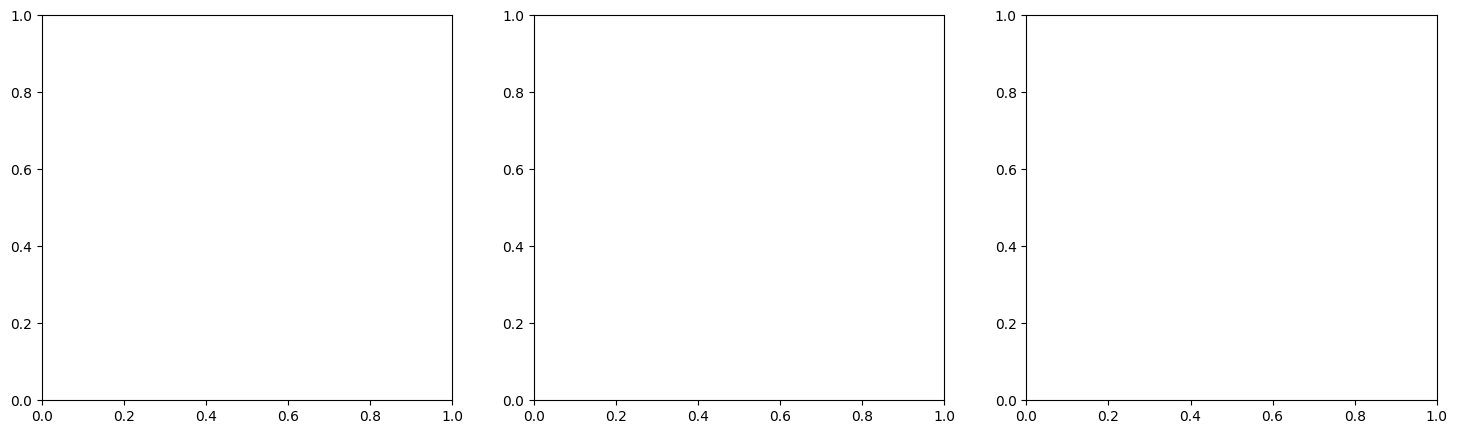

In [13]:
#@title 载入数据集
# choose here
# seismic_data_video = process_seismic_for_world(seismic_data_total.cpu()) # torch.Size([1280, 2, 64, 64]) -- pretrain
# seismic_data_video = fine_tune_video_slices # fine-tune
# seismic_data_video = filtered_tensor # fine-tune
seismic_data_video = filtered_tensor_test # fine-tune

# 创建可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 三个子图：输入 / 目标 / 差值

idx = 30000
cmap = 'seismic'  # 使用 seismic 色标

# 可视化第一个 tensor：输入
im1 = axes[0].imshow(seismic_data_video[idx, 0].numpy(),
                      cmap=cmap, aspect='auto')
axes[0].set_title(f'Input: seismic record slice_{idx}')
axes[0].set_xlabel('Column voxel')
axes[0].set_ylabel('Row voxel')
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Seismic amplitude')

# 可视化第二个 tensor：目标（未来）
im2 = axes[1].imshow(seismic_data_video[idx, 1].numpy(),
                      cmap=cmap, aspect='auto')
axes[1].set_title(f'Target: future seismic slice_{idx}')
axes[1].set_xlabel('Column voxel')
axes[1].set_ylabel('Row voxel')
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Seismic amplitude')

# 可视化第三个 tensor：time-lapse 差值（目标 - 输入）
diff = seismic_data_video[idx, 1].numpy() - seismic_data_video[idx, 0].numpy()
im3 = axes[2].imshow(diff, cmap=cmap, aspect='auto')
axes[2].set_title(f'Difference: target - input slice_{idx}')
axes[2].set_xlabel('Column voxel')
axes[2].set_ylabel('Row voxel')
cbar3 = plt.colorbar(im3, ax=axes[2])
cbar3.set_label('Seismic amplitude')

plt.tight_layout()
plt.savefig(
    f_path + f'/自编码器输入输出差值对比_{idx}.pdf',
    format='pdf',
    dpi=300,
    bbox_inches='tight',
    facecolor='white',
    edgecolor='none',
    transparent=False
)
plt.show()


In [ ]:
# @title VQ-VAE:Separate Training {"vertical-output":true}
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import Module, ModuleList
import os
from tqdm import tqdm
import sys
sys.path.append('/content/drive/MyDrive/SeismicWorld') # Adjust path if needed
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder
from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder
import json
from datetime import datetime
from typing import  Union, Tuple, Optional, List, Dict, Any
from torch import Tensor
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from einops import rearrange, repeat
from torch import nn, einsum, Tensor
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast
import torch
import torch.nn as nn
from torch import Tensor
from typing import Optional, Tuple, Union, List
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

TRAIN_MODE = False #@param

# 兼容不同PyTorch版本的混合精度导入
try:
    # 新版本 PyTorch (>= 2.0)
    from torch.amp import autocast, GradScaler
    def get_autocast_context(device_type='cuda'):
        return autocast(device_type=device_type, dtype=torch.float16)
    def get_grad_scaler(device_type='cuda'):
        return GradScaler(device_type)
    AMP_AVAILABLE = True
    print("Using torch.amp (PyTorch >= 2.0)")
except ImportError:
    try:
        # 旧版本 PyTorch (1.6-2.0)
        from torch.cuda.amp import autocast, GradScaler
        def get_autocast_context(device_type='cuda'):
            return autocast(enabled=True, dtype=torch.float16)
        def get_grad_scaler(device_type='cuda'):
            return GradScaler()
        AMP_AVAILABLE = True
        print("Using torch.cuda.amp (PyTorch 1.6-2.0)")
    except ImportError:
        # 非常旧的版本，不支持混合精度
        AMP_AVAILABLE = False
        print("Mixed precision not available in this PyTorch version")
        def get_autocast_context(device_type='cuda'):
            from contextlib import nullcontext
            return nullcontext()
        def get_grad_scaler(device_type='cuda'):
            return None
# choose here
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # GPU
# DEVICE = device # XLA

print(f"Using device: {DEVICE}")


def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def pack_one(t, pattern):
    return pack([t], pattern)

def unpack_one(t, ps, pattern):
    return unpack(t, ps, pattern)[0]

def round_ste(z: Tensor) -> Tensor:
    """
    Round with straight through gradients.
    for f(z) = z + (round(z) - z).detach():
      df/dz = d/dz[z] + d/dz[(round(z) - z).detach()]
        = 1 + 0
        = 1
    """
    zhat = z.round()
    return z + (zhat - z).detach() # 切断梯度流，使得被 detach 的部分在反向传播时不计算梯度。

class FSQ(Module):
    def __init__(
        self,
        levels: List[int], # 每个维度的量化级别列表，决定了每个维度可以取多少个离散值
        dim: Optional[int] = None, # 输入特征的维度，默认为levels的长度乘以codebooks数量
        num_codebooks = 1, # 码本数量
        keep_num_codebooks_dim: Optional[bool] = None, # 是否保留码本维度，当num_codebooks>1时默认为True
        scale: Optional[float] = None
    ):
        super().__init__()
        # 存储每个维度的量化级别
        _levels = torch.tensor(levels, dtype=torch.int32)
        self.register_buffer("_levels", _levels, persistent = False)

        # 计算累乘基数，用于将多维索引转换为一维索引
        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=torch.int64)
        self.register_buffer("_basis", _basis, persistent = False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks
        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item() # 码本的大小

        # implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        # self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

    # 将输入张量z约束到有限范围
    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 + eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0) # 对于偶数级别，偏移量为 0；对于奇数级别，偏移量为 0.5
        shift = (offset / half_l).atanh()
        return (z + shift).tanh() * half_l - offset


    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z)) # 将值四舍五入到最近的整数（STE 表示 Straight-Through Estimator，允许在反向传播时梯度流过量化操作）
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    # 将 [-1, 1] 范围内的归一化值转换为 [0, levels-1] 范围内的整数
    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    # [0, levels-1] 范围内的整数转换回 [-1, 1] 范围内的归一化值
    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """
        Converts a `code` to an index in the codebook.
        例如，如果 levels=[8, 8, 8, 5, 5, 5]，_basis=[1, 8, 64, 512, 2560, 12800]，那么编码 [3, 2, 4, 1, 0, 2] 的索引为：
              3×1 + 2×8 + 4×64 + 1×512 + 0×2560 + 2×12800 = 26291
        """
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int64) # 多维编码转换为一维索引

    # 量化后的编码转换为码本中的索引
    def indices_to_codes(
            self,
            indices: Tensor, # 输入形状: [batch, ...] 或 [batch, num_codebooks, ...] (取决于keep_num_codebooks_dim)
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""

        is_img_or_video = indices.ndim >= (3 + int(self.keep_num_codebooks_dim))

        indices = rearrange(indices, '... -> ... 1')
        # indices形状: [batch, ..., 1] (在最后一维添加维度1)

        codes_non_centered = (indices // self._basis) % self._levels
        # indices形状: [batch, ..., 1]
        # self._basis形状: [codebook_dim] 例如 [1, 8, 64, 512, 2560, 12800]
        # self._levels形状: [codebook_dim] 例如 [8, 8, 8, 5, 5, 5]
        # codes_non_centered形状: [batch, ..., codebook_dim] 例如 [batch, seq_len, 6] 或 [batch, num_codebooks, H, W, 6]

        codes = self._scale_and_shift_inverse(codes_non_centered)
        # codes形状: [batch, ..., codebook_dim] (形状不变，但数值从[0, level-1]转换为[-1, 1])

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)') # [batch, seq_len, num_codebooks, codebook_dim]
            # codes形状变化: [batch, ..., num_codebooks, codebook_dim] -> [batch, ..., num_codebooks * codebook_dim]
            # 例如: [batch, seq_len, num_codebooks, 6] -> [batch, seq_len, num_codebooks * 6]
        if project_out:
            codes = self.project_out(codes)

        if is_img_or_video:
            codes = rearrange(codes, 'b ... d -> b d ...')
            # codes形状变化: [batch, H, W, dim] -> [batch, dim, H, W] (图像格式)
            # 或 [batch, H, W, T, dim] -> [batch, dim, H, W, T] (视频格式)

        return codes # torch.Size([1, 8, 8, 512])
        # 最终返回的codes形状:
        # - 图像/视频: [batch, dim, H, W] 或 [batch, dim, H, W, T]
        # - 序列: [batch, seq_len, dim]

    def forward(self, z: Tensor) -> Tensor:
        """
        einstein notation
        b - batch
        n - sequence (or flattened spatial dimensions)
        d - feature dimension
        c - number of codebook dim
        """
        # 打印量化前的特征统计信息
        print(f"Input feature mean: {z.mean().item()}, std: {z.std().item()}")
        print(f"Input feature min: {z.min().item()}, max: {z.max().item()}")

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions

        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

# Dynamic自适应版
class FSQDQuantizer(nn.Module):

    def __init__(
        self,
        levels: list[int],
        dim: Optional[int] = None,
        num_codebooks=1,
        keep_num_codebooks_dim: Optional[bool] = None,
        scale: Optional[float] = None,
        init_scale=1.0,
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)

        _levels = torch.tensor(levels,dtype=int32)

        self.register_buffer("_levels", _levels, persistent=False)

        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=int32)
        self.register_buffer("_basis", _basis, persistent=False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks

        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item()

        implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

        self.init_scale=init_scale
        self.ada_param = nn.Parameter(torch.ones(codebook_dim)*self.init_scale,requires_grad=True)

    @property
    def embedding_dim(self):
        return self.dim

    @property
    def num_embeddings(self):
        return self.codebook_size


    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 - eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0)
        shift = (offset / half_l).atanh()
        scale = F.sigmoid(self.ada_param)*4
        return torch.tanh(scale*(z + shift)) * half_l - offset

    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z))
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int32)

    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""


        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        return codes

    def forward(
        self,
        z: torch.Tensor,
    ):
        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions
        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

class FSQLQuantizer(nn.Module):

    def __init__(
        self,
        levels: list[int],
        dim: Optional[int] = None,
        num_codebooks=1,
        keep_num_codebooks_dim: Optional[bool] = None,
        scale: Optional[float] = None,
        init_scale=1.0,
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)

        _levels = torch.tensor(levels,dtype=int32)

        self.register_buffer("_levels", _levels, persistent=False)

        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=int32)
        self.register_buffer("_basis", _basis, persistent=False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks

        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item()

        implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

        self.init_scale=init_scale
        self.ada_param = nn.Parameter(torch.ones(codebook_dim)*self.init_scale,requires_grad=True)

    @property
    def embedding_dim(self):
        return self.dim

    @property
    def num_embeddings(self):
        return self.codebook_size


    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 - eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0)
        shift = (offset / half_l).atanh()
        return torch.tanh(self.ada_param*(z + shift)) * half_l - offset

    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z))
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int32)

    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""


        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        return codes



    def forward(
        self,
        z: torch.Tensor,
    ):

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions
        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

def default(val, d):
    return val if exists(val) else d

def cast_tuple(t, length = 1):
    return t if isinstance(t, tuple) else ((t,) * length)

def divisible_by(numer, denom):
    return (numer % denom) == 0

def pad_at_dim(t, pad, dim = -1, value = 0.):
    dims_from_right = (- dim - 1) if dim < 0 else (t.ndim - dim - 1)
    padded_dims = [(0, 0)] * dims_from_right + [pad] + [(0, 0)] * (t.ndim - dims_from_right - 1)
    return F.pad(t, tuple(rearrange(torch.tensor(padded_dims), 'r n -> n r').tolist()), value = value)

# --- VQ-VAE Class ---
class VQVAE(Module):
    """
    Vector Quantized Variational Autoencoder (VQ-VAE) using MagvitV2 style
    encoder/decoder and Finite Scalar Quantization (FSQ).
    """
    def __init__(
        self,
        *,
        image_size: int,
        channels: int = 1,
        init_dim: int = 128,
        fsq_levels: List[int], # e.g., [8, 8, 8, 5, 5, 5]
        fsq_dim: Optional[int] = None, # Dimension of encoder output / FSQ input. If None, calculated based on layers.
        num_fsq_codebooks: int = 1, # As per FSQ class
        encoder_layers: Tuple[Union[str, Tuple[str, int]], ...] = (
            ('consecutive_residual', 4), ('spatial_down', 1), ('channel_residual', 1), # dim: 128 -> 256
            ('consecutive_residual', 3), ('time_spatial_down', 1),                     # dim: 256
            ('consecutive_residual', 4), ('time_spatial_down', 1),                     # dim: 256
            ('channel_residual', 1), ('consecutive_residual', 3),                      # dim: 256 -> 512
            ('consecutive_residual', 4),                                               # dim: 512
        ),
        decoder_layers: Tuple[Union[str, Tuple[str, int]], ...] = (
             # Inverse of encoder layers (example, adjust as needed)
            ('consecutive_residual', 4),                                               # dim: 512
            ('consecutive_residual', 3), ('channel_residual', 1),                      # dim: 512 -> 256
            ('time_spatial_up', 1), ('consecutive_residual', 4),                       # dim: 256
            ('time_spatial_up', 1), ('consecutive_residual', 3),                       # dim: 256
            ('channel_residual', 1), ('spatial_up', 1), ('consecutive_residual', 4),   # dim: 256 -> 128
        ),
        input_conv_kernel_size: Tuple[int, int, int] = (7, 7, 7),
        output_conv_kernel_size: Tuple[int, int, int] = (3, 3, 3),
        separate_first_frame_encoding: bool = False,
        pad_mode: str = 'constant',
    ):
        super().__init__()
        self.image_size = image_size
        self.channels = channels
        self.separate_first_frame_encoding = separate_first_frame_encoding

        # --- Encoder ---
        self.encoder = MagvitV2encoder(
            image_size=image_size,
            channels=channels,
            init_dim=init_dim,
            layers=encoder_layers,
            input_conv_kernel_size=input_conv_kernel_size,
            pad_mode=pad_mode,
            separate_first_frame_encoding=separate_first_frame_encoding
        )

        # Determine FSQ dimension if not provided
        if fsq_dim is None:
            # 根据encoder_layers计算最终维度
            current_dim = init_dim
            for layer_def in encoder_layers:
                layer_type, *layer_params = cast_tuple(layer_def)
                if layer_type == 'channel_residual':
                     # channel_residual层会将维度翻倍
                     current_dim = current_dim * 2
            fsq_dim = current_dim
            print(f"Auto-determined FSQ dimension: {fsq_dim}")
        self.fsq_dim = fsq_dim

        # --- Quantizer ---
        self.quantizer = FSQLQuantizer(
            dim=fsq_dim,
            levels=fsq_levels,
            num_codebooks=num_fsq_codebooks,
            # keep_num_codebooks_dim=True # Keep separate dim for codebooks if num_codebooks > 1
                                         # Set based on how you want indices shaped
        )
        self.codebook_size = self.quantizer.codebook_size # Total size of the discrete codebook

        # --- Decoder ---
        # Decoder's init_dim should match the FSQ output dimension
        self.decoder = MagvitV2decoder(
             image_size=image_size,
             channels=channels,
             init_dim=init_dim,#fsq_dim, # Decoder input dim = FSQ output dim
             layers=decoder_layers, # Provide appropriate decoder layers
             output_conv_kernel_size=output_conv_kernel_size,
             separate_first_frame_encoding=separate_first_frame_encoding
        )

    def encode(
        self,
        video_or_images: Tensor
    ) -> Tuple[Tensor, Optional[Tensor], bool]:
        """ Encodes input video/images into continuous latent features. """
        assert video_or_images.ndim in {4, 5} # B, C, H, W or B, C, T, H, W
        assert video_or_images.shape[-2:] == (self.image_size, self.image_size)

        is_image = video_or_images.ndim == 4
        if is_image:
            video = rearrange(video_or_images, 'b c ... -> b c 1 ...')
            video_contains_first_frame = True # Treat image as the first frame
        else:
            video = video_or_images
            # Heuristic: Assume first frame exists if T > 1 or if specifically handling
            video_contains_first_frame = video.shape[2] > 0

        # Encoder forward pass
        # Note: cond is returned but not used in this basic VQVAE setup
        encoded_features, cond, video_contains_first_frame_out = self.encoder(
            video,
            cond=None, # No conditioning in basic VQVAE
            video_contains_first_frame=video_contains_first_frame
        )
        return encoded_features, cond, video_contains_first_frame_out

    def quantize(self, features: Tensor) -> Tuple[Tensor, Tensor]:
        """ Quantizes continuous features using FSQ. """
        quantized, indices = self.quantizer(features)
        return quantized, indices

    def decode(
        self,
        quantized_features: Tensor,
        cond: Optional[Tensor] = None, # Pass condition if decoder uses it
        video_contains_first_frame: bool = True
    ) -> Tensor:
        """ Decodes quantized features back into video/images. """
        recon_video = self.decoder(
            quantized_features,
            cond=cond,
            video_contains_first_frame=video_contains_first_frame
        )
        return recon_video

    def encode_to_indices(self, video_or_images: Tensor) -> Tensor:
        """ Encodes input directly to discrete FSQ indices. """
        features, _, _ = self.encode(video_or_images)
        _, indices = self.quantize(features)
        # Indices shape depends on FSQ keep_num_codebooks_dim and input shape
        # e.g., [B, T', H', W'] or [B, T', H', W', C] if keep_num_codebooks_dim=True
        return indices

    def decode_from_indices(
        self,
        indices: Tensor,
        cond: Optional[Tensor] = None, # Pass condition if decoder uses it
        video_contains_first_frame: bool = True # Important context for decoder padding
        ) -> Tensor:
        """ Decodes discrete FSQ indices back into video/images. """
        # Convert indices back to the continuous-like quantized vectors
        # project_out=True applies the final linear layer if FSQ has projections
        # 如果indices传入是单帧'序列'： [1,1,8,8] [B,T,..]
        quantized_features = self.quantizer.indices_to_codes(indices, project_out=True)
        print(f'quantized_features={quantized_features.shape}') # torch.Size([B:1, T:1, 8, 8, D:512]) 序列的dim512是在最后

        # Assuming FSQ returns [B, T', H', W', D] and decoder expects [B, D, T', H', W']
        quantized_features = rearrange(quantized_features, 'b ... d -> b d ...')

        # # Ensure the shape matches decoder input (B, D, T', H', W')
        # # FSQ indices_to_codes might return [B, ..., D], need to permute
        # if quantized_features.shape[-1] == self.fsq_dim and quantized_features.ndim > 3:
        #      # Example reshape/permute if indices were [B, T', H', W', D] or similar
        #      # This depends heavily on the exact shape returned by indices_to_codes
        #      # Assuming FSQ returns [B, T', H', W', D] and decoder expects [B, D, T', H', W']
        #      expected_spatial_dims = indices.ndim - 2 # B and T are non-spatial
        #      if quantized_features.ndim == expected_spatial_dims + 1: # Check if D is last
        #          num_spatial_dims = len(quantized_features.shape[1:-1])
        #          permute_dims = [0] + [quantized_features.ndim - 1] + list(range(1, 1 + num_spatial_dims))
        #          quantized_features = quantized_features.permute(*permute_dims).contiguous()
        #      else:
        #          print(f"Warning: Unexpected shape from indices_to_codes: {quantized_features.shape}. Decoder might fail.")
        #          # Attempt a generic permute if possible
        #          if quantized_features.ndim >= 4:
        #               quantized_features = rearrange(quantized_features, 'b ... d -> b d ...')


        # Decode the features
        recon_video = self.decode(
            quantized_features,
            cond=cond,
            video_contains_first_frame=video_contains_first_frame
        )
        return recon_video.squeeze(2) # 不这样会出现多余的维度

    def forward(
        self,
        video_or_images: Tensor,
        return_indices: bool = False,
        return_loss: bool = False, # Placeholder for potential loss calculation
        beta: float = 0.25
        ) -> Union[Tensor, Tuple[Tensor, Tensor], Tuple[Tensor, Tensor, Tensor]]:
        """
        Full forward pass: Encode -> Quantize -> Decode.

        Args:
            video_or_images (Tensor):
            图像输入：[B, C, H, W]
            视频输入：[B, C, H, W] （每次处理一帧）
            return_indices (bool): If True, also return the discrete code indices.
            return_loss (bool): If True, calculate and return reconstruction loss
                                (and potentially commitment loss - requires modification).

        Returns:
            Tensor or Tuple:
                - Reconstructed video/images.
                - (Optional) FSQ indices.
                - (Optional) Loss tensor (if return_loss=True).
        """
        # 1. Encode
        features, cond, video_contains_first_frame = self.encode(video_or_images)
        # print(f'编码器的输出形状/FSQ的输入形状为{features.shape}') # torch.Size([5, 512, 1, 8, 8])

        # 2. Quantize
        quantized, indices = self.quantize(features) # 原版FSQ期望的输入形状：多玛本[batch, num_codebooks, height, width, time]；单码本：[batch, height, width, time]
        # print(f'FSQ的输出code形状为{quantized.shape}') # torch.Size([5, 512, 1, 8, 8])  在FSQ的forward()变成了[5,1,8,8,512->6]
        # print(f'FSQ的输出indices形状为{indices.shape}')# torch.Size([5, 1, 8, 8]) FSQ要求的输入形状: [batch, ...] 或 [batch, num_codebooks, ...]

        # 3. Decode
        recon_output = self.decode(
            quantized,
            cond=cond,
            video_contains_first_frame=video_contains_first_frame
        )
        # print(f'解码器的输出code形状为{recon_output.shape}') # torch.Size([5, 1, 1, 64, 64])

        # --- Optional: Loss Calculation ---
        loss = None
        if return_loss:
            # Reconstruction Loss (e.g., MSE)
            # Ensure original input and reconstruction match shape (handle image vs video)
            original_input = video_or_images
            if original_input.ndim == 4: # Input was image
                 # Decoder might output B,C,1,H,W, compare with B,C,H,W
                 if recon_output.shape[2] == 1:
                      recon_output_for_loss = recon_output.squeeze(2)
                 else:
                      recon_output_for_loss = recon_output # Should match if decoder handles images correctly
            else: # Input was video
                 recon_output_for_loss = recon_output

            # Handle potential padding differences if decoder output length != input length
            target_len = original_input.shape[2] if original_input.ndim == 5 else 1
            recon_len = recon_output_for_loss.shape[2] if recon_output_for_loss.ndim == 5 else 1

            if target_len != recon_len:
                 min_len = min(target_len, recon_len)
                 print(f"Warning: Reconstruction length ({recon_len}) differs from input length ({target_len}). Calculating loss on first {min_len} frames.")
                 if original_input.ndim == 5:
                      original_input = original_input[:, :, :min_len, :, :]
                 if recon_output_for_loss.ndim == 5:
                      recon_output_for_loss = recon_output_for_loss[:, :, :min_len, :, :]

            recon_loss = F.mse_loss(recon_output_for_loss, original_input)

            # Commitment Loss (Optional - typical in VQ-VAE but FSQ might not need it explicitly)
            # If needed, it's typically: beta * ||sg(features) - quantized||^2
            commit_loss = F.mse_loss(features, quantized.detach())
            loss = recon_loss + beta * commit_loss
            # loss = recon_loss # Simple reconstruction loss for now

        # --- Return Values ---
        if return_loss and return_indices:
            return recon_output, indices, loss
        elif return_loss:
            return recon_output, loss
        elif return_indices:
            return recon_output, indices
        else:
            return recon_output

# --- VideoWorldLDM Class Definition (Copied from your code) ---
class VideoWorldLDM(nn.Module):
    def __init__(self, image_size=128, latent_channels=1, frame_num=9,act_embedding_num=8):
        super().__init__()
        self.encoder = MagvitV2LAencoder(
            image_size=image_size,
            channels=latent_channels,
            frame_num=frame_num,
            init_dim=128,
            pre_out_layer=9,
            act_embedding_num=act_embedding_num,
        layers=(
            ('consecutive_residual', 4), ('spatial_down', 1), ('channel_residual', 1),
            ('consecutive_residual', 3), ('spatial_down', 1), ('consecutive_residual', 4),
            ('spatial_down', 1), ('channel_residual', 1), ('consecutive_residual', 3),
            ('consecutive_residual', 4)
        ))
        self.quantizer = FSQ( dim=512, levels=[8, 8, 8, 5, 5, 5], num_codebooks=1)
        self.decoder = MagvitV2LAAdadecoder(
            image_size=image_size, channels=latent_channels, init_dim=128,
            use_pre_video=False, use_pre_encode=True,
        layers=(
            ('consecutive_residual', 3), ('channel_residual', 1), ('condation', 1),
            ('spatial_up', 1), ('consecutive_residual', 4), ('condation', 1),
            ('spatial_up', 1), ('consecutive_residual', 3), ('channel_residual', 1),
            ('condation', 1), ('spatial_up', 1), ('consecutive_residual', 4),
            ('condation', 1), ('consecutive_residual', 4)
        ))
        # Store channels for input check
        self.channels = latent_channels

    def forward(self, x):
        if x.dim() == 4: x = x.unsqueeze(0)
        # Ensure input has correct channel dimension C
        if x.shape[1] != self.channels:
             # Example: Input might be [B, T, C, H, W], needs permute
             if x.shape[2] == self.channels:
                  x = x.permute(0, 2, 1, 3, 4) # B, C, T, H, W
             else:
                  raise ValueError(f"Input channel dimension {x.shape[1]} or {x.shape[2]} does not match model channels {self.channels}")

        encoded, cond, video_contains_first_frame, pre_encode_out = self.encoder(x)
        # encoded shape might be [B, D, T', H', W'] or similar, depends on encoder output
        # print(f"Encoded shape before quantizer: {encoded.shape}")

        quantized, indices = self.quantizer(encoded)
        # print(f"Quantized shape: {quantized.shape}")
        # print(f"Indices shape: {indices.shape}")

        decoded = self.decoder(quantized, cond=cond,
                             video_contains_first_frame=video_contains_first_frame,
                             pre_encode_out=pre_encode_out)
        return decoded, quantized, indices, video_contains_first_frame, pre_encode_out

# --- SeismicWorldVideoWorld Class Definition (Modified for clarity and token mapping) ---
class SeismicWorldVideoWorld(nn.Module):
    def __init__(
        self,
        codebook_size_ldm,
        codebook_size_frame,
        special_token_count=3,     # BOS/EOS/PAD
        max_seq_length=1024,
        hidden_size=4096,
        num_hidden_layers=12,
        num_attention_heads=16,
        intermediate_size=4096,
        num_ldm_codes_per_step=1, # Number of LDM codes per time step (H in paper)
        num_frame_tokens_per_step=16*16, # Number of frame tokens per time step
        pretrained_model_path=None,
        device=None,
    ):
        super().__init__()
        self.codebook_size_ldm = codebook_size_ldm
        self.codebook_size_frame = codebook_size_frame
        self.special_token_count = special_token_count

        # Define vocabulary ranges
        self.ldm_token_offset = 0
        self.frame_token_offset = self.codebook_size_ldm
        self.special_token_offset = self.codebook_size_ldm + self.codebook_size_frame

        self.vocab_size = self.special_token_offset + special_token_count

        self.max_seq_length = max_seq_length
        self.num_ldm_codes_per_step = num_ldm_codes_per_step
        self.num_frame_tokens_per_step = num_frame_tokens_per_step
        self.tokens_per_step = num_ldm_codes_per_step + num_frame_tokens_per_step
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # InternLM configuration
        if pretrained_model_path:
            # from MoE.modeling_internlm import InternLMForCausalLM # Assuming import exists
            self.model = InternLMForCausalLM.from_pretrained(
                pretrained_model_path,
                torch_dtype=torch.float16, # Consider float32 for stability if needed
                low_cpu_mem_usage=True,
            )
            print(f"Resizing token embeddings from {self.model.config.vocab_size} to {self.vocab_size}")
            self.model.resize_token_embeddings(self.vocab_size)
            if self.model.config.max_position_embeddings < max_seq_length:
                print(f"Resizing position embeddings from {self.model.config.max_position_embeddings} to {max_seq_length}")
                # Be cautious with resizing position embeddings, might need interpolation
                self.model.resize_position_embeddings(max_seq_length)
        else:
            # from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM # Assuming import exists
            config = InternLMConfig(
                vocab_size=self.vocab_size,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=max_seq_length,
                rms_norm_eps=1e-6,
                use_cache=True, # Enable for generation
                # Add other relevant InternLM config options if needed
            )
            self.model = InternLMForCausalLM(config)

        # Positional Encoding - More sophisticated encoding might be needed
        # Simple approach: Treat each step (LDM codes + Frame tokens) as a "time" unit
        # and position within the step as "space" unit.
        self.num_time_steps_for_pos = math.ceil(max_seq_length / self.tokens_per_step) + 1 # +1 for BOS potentially
        self.time_pos_embed = nn.Embedding(self.num_time_steps_for_pos, hidden_size)
        # Use a single embedding for position within the combined step
        self.step_pos_embed = nn.Embedding(self.tokens_per_step, hidden_size)

        # Special token IDs
        self.bos_token_id = self.special_token_offset
        self.eos_token_id = self.special_token_offset + 1
        self.pad_token_id = self.special_token_offset + 2
        # Ensure PAD ID matches InternLM's expected PAD ID if using HF trainer etc.
        # self.model.config.pad_token_id = self.pad_token_id

        self.to(self.device)

    def get_token_type_ids(self, input_ids):
        """ Distinguish between BOS, LDM, Frame, PAD tokens """
        token_type_ids = torch.zeros_like(input_ids)
        # Mark LDM tokens (type 1)
        token_type_ids[(input_ids >= self.ldm_token_offset) & (input_ids < self.frame_token_offset)] = 1
        # Mark Frame tokens (type 2)
        token_type_ids[(input_ids >= self.frame_token_offset) & (input_ids < self.special_token_offset)] = 2
        # Mark Special tokens (type 0 or specific types if needed)
        token_type_ids[input_ids == self.bos_token_id] = 0 # Or a specific BOS type
        token_type_ids[input_ids == self.eos_token_id] = 0 # Or a specific EOS type
        token_type_ids[input_ids == self.pad_token_id] = 0 # Or a specific PAD type
        return token_type_ids


    def add_positional_encoding(self, input_ids):
        """
        Adds positional encoding based on time step and position within the step.
        Assumes input_ids shape [B, seq_len] and structure like:
        [BOS, ldm_0_0, ..., ldm_0_N, frame_0_0, ..., frame_0_M, ldm_1_0, ...]
        """
        batch_size, seq_len = input_ids.shape
        device = input_ids.device

        # Create position IDs: 0, 1, 2, ..., seq_len-1
        position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)

        # Calculate time step ID and position within step ID
        # This assumes a fixed structure per step, adjust if structure varies
        # Start counting steps after BOS token
        positions_after_bos = position_ids - 1 # -1 for positions 0, 1, ... relative to first LDM/Frame token
        time_step_ids = torch.zeros_like(position_ids)
        position_in_step_ids = torch.zeros_like(position_ids)

        # Handle BOS token separately (time step 0, position 0)
        is_not_bos = (input_ids != self.bos_token_id)
        time_step_ids[is_not_bos] = positions_after_bos[is_not_bos] // self.tokens_per_step + 1 # Steps 1, 2, ...
        position_in_step_ids[is_not_bos] = positions_after_bos[is_not_bos] % self.tokens_per_step

        # Clamp time_step_ids to max embedding index
        time_step_ids = torch.clamp(time_step_ids, 0, self.num_time_steps_for_pos - 1)

        # Get embeddings
        time_pos = self.time_pos_embed(time_step_ids)
        step_pos = self.step_pos_embed(position_in_step_ids)

        # Combine embeddings (simple addition)
        pos_encoding = time_pos + step_pos
        return pos_encoding


    def forward(
        self,
        input_ids,      # [B, seq_len], input token sequence (BOS+Z0+frame0+...)
        labels=None,    # [B, seq_len], target token sequence (shifted input_ids)
        attention_mask=None,
        return_dict=None # Use model's default usually
    ):
        """
        Teacher Forcing training.
        input_ids: [B, seq_len]
        labels: [B, seq_len] (should be input_ids shifted left, with -100 for padding)
        """
        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict

        # Get token embeddings
        inputs_embeds = self.model.get_input_embeddings()(input_ids)

        # Add positional encoding
        pos_encoding = self.add_positional_encoding(input_ids)
        inputs_embeds = inputs_embeds + pos_encoding

        # Optional: Add token type embeddings if needed
        # token_type_ids = self.get_token_type_ids(input_ids)
        # token_type_embeddings = self.model.get_input_embeddings()(token_type_ids) # Or a separate type embedding layer
        # inputs_embeds = inputs_embeds + token_type_embeddings

        # Prepare attention mask if not provided (handle padding)
        if attention_mask is None:
            attention_mask = (input_ids != self.pad_token_id).long()

        # Prepare labels for Causal LM
        # Standard practice: shift logits and labels, compute loss only on non-padded label tokens
        if labels is not None:
             shift_logits = outputs.logits[..., :-1, :].contiguous()
             shift_labels = labels[..., 1:].contiguous()
             # Flatten the tokens
             loss_fct = nn.CrossEntropyLoss()
             shift_logits = shift_logits.view(-1, self.config.vocab_size)
             shift_labels = shift_labels.view(-1)
             # Enable model parallelism
             shift_labels = shift_labels.to(shift_logits.device)
             loss = loss_fct(shift_logits, shift_labels)
             # The InternLMForCausalLM forward pass likely handles this internally if labels are provided.
             # We just need to pass the labels argument to the underlying model.
             pass # No explicit loss calculation needed here if labels are passed to self.model

        # Call the underlying InternLM model
        outputs = self.model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels, # Pass labels here for internal loss calculation
            use_cache=False, # Typically False during training
            return_dict=return_dict,
            output_hidden_states=False, # Set as needed
            output_attentions=False,    # Set as needed
        )

        return outputs # Return the output object from InternLM, which contains loss, logits, etc.


    @torch.no_grad()
    def generate(
        self,
        input_ids, # [B, seq_len], initial sequence (e.g., BOS + ldm_tokens_0 + frame_tokens_0)
        max_new_tokens,
        attention_mask=None, # Optional initial attention mask
        temperature=1.0,
        top_k=None,
        eos_token_id=None, # Specify EOS token ID for stopping
        **kwargs # Pass other generation config args to model.generate
    ):
        """
        Autoregressive generation using the underlying model's generate method.
        Handles positional encoding addition.
        """
        self.model.eval()
        device = input_ids.device
        batch_size, cur_len = input_ids.shape

        # Prepare initial inputs for the model's generate method
        # The generate method typically handles caching and token selection.
        # We need a way to inject our custom positional encoding logic if
        # the model's internal generate doesn't support it directly.

        # Option 1: Use model.generate directly if it works with custom embeddings (less likely)
        # This might fail if generate expects `input_ids` and calculates embeddings internally.

        # Option 2: Manual generation loop (more control, less optimized than HF generate)
        generated = input_ids
        past_key_values = None
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)

        effective_eos_token_id = eos_token_id if eos_token_id is not None else self.eos_token_id

        for _ in range(max_new_tokens):
            # Prepare inputs for the current step
            if past_key_values is None:
                # First step: use the full input_ids
                current_input_ids = generated
                current_attention_mask = attention_mask
            else:
                # Subsequent steps: use only the last generated token
                current_input_ids = generated[:, -1:]
                # Update attention mask for the new token
                current_attention_mask = torch.cat(
                    [attention_mask, attention_mask.new_ones((batch_size, 1))], dim=-1
                )
                attention_mask = current_attention_mask # Update for next iteration

            # Get embeddings and add positional encoding for the current input sequence length
            current_seq_len = current_input_ids.shape[1]
            inputs_embeds = self.model.get_input_embeddings()(current_input_ids)
            # Need positional encoding only for the current input tokens
            pos_encoding = self.add_positional_encoding(generated) # Pos encoding for the whole sequence so far
            if past_key_values is None:
                 current_pos_encoding = pos_encoding # Use full encoding for first step
            else:
                 current_pos_encoding = pos_encoding[:, -1:, :] # Use only encoding for the last token

            current_inputs_embeds = inputs_embeds + current_pos_encoding

            # Forward pass
            outputs = self.model(
                inputs_embeds=current_inputs_embeds,
                attention_mask=current_attention_mask,
                past_key_values=past_key_values,
                use_cache=True,
                return_dict=True,
            )

            # Get logits for the next token
            next_token_logits = outputs.logits[:, -1, :] # [B, vocab_size]

            # Apply temperature scaling
            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature

            # Apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(next_token_logits, top_k, dim=-1)
                next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')

            # Sample next token
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1) # [B, 1]

            # Append generated token
            generated = torch.cat([generated, next_token], dim=1)

            # Update past_key_values
            past_key_values = outputs.past_key_values

            # Check for EOS token
            if effective_eos_token_id is not None and (next_token == effective_eos_token_id).all():
                break

            # Update attention mask length for next iteration if using manual loop with past_key_values
            # (Already handled above by updating attention_mask)

        return generated

def train_vq_pre_train(
    vq_dataloader, # Input data tensor [N, C, T, H, W]
    image_size: int,
    vid_channels: int,
    vid_frames: int,
    fsq_levels_config: List[int],
    vq_epochs: int,
    batch_size: int,
    learning_rate: float,
    beta: float, # Weight for the commitment loss term in VQVAE
    num_workers: int = 0,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    init_dim: int = 512, # Pass other VQVAE params as needed
    fsq_dim: Optional[int] = None,
    encoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None, # Use defaults or pass specifics
    decoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None,
    # ... other VQVAE parameters if needed
    save_path_prefix: Optional[str] = "vqvae_trained", # Changed to prefix
    save_best_only: bool = True, # Whether to save only the best model
    patience: int = 5, # Early stopping patience
    min_delta: float = 1e-6 # Minimum change to qualify as an improvement
    ):
    """
    Trains the VQ-VAE model with best model saving and optional early stopping.

    Args:
        vq_dataloader: TPU dataloader.
        image_size: Height/Width of the video frames.
        vid_channels: Number of channels in the video.
        vid_frames: Number of frames in the video clips (used for info, VQVAE handles variable T).
        fsq_levels_config: List of levels for the FSQ quantizer.
        vq_epochs: Number of epochs to train.
        batch_size: Training batch size.
        learning_rate: Optimizer learning rate.
        beta: Weight for the commitment loss component.
        num_workers: Number of DataLoader workers.
        device: Computation device ('cuda' or 'cpu').
        init_dim: Initial dimension for VQVAE encoder/decoder.
        fsq_dim: Dimension entering the FSQ layer (can be auto-determined).
        encoder_layers: Custom encoder layer configuration.
        decoder_layers: Custom decoder layer configuration.
        save_path_prefix: Prefix for saving model files.
        save_best_only: If True, only save the best model. If False, save both best and final.
        patience: Number of epochs to wait for improvement before early stopping (0 to disable).
        min_delta: Minimum change in loss to qualify as an improvement.

    Returns:
        The trained VQ-VAE model.
    """
    print(f"--- Starting VQ-VAE Training on device: {device} ---")
    print(f"Data shape: {seismic_data_video.shape}")
    print(f"Parameters: Epochs={vq_epochs}, BatchSize={batch_size}, LR={learning_rate}, Beta={beta}")
    print(f"Best model saving: {save_best_only}, Early stopping patience: {patience}")

    # --- Instantiate the VQ-VAE ---
    # Use provided args, falling back to defaults in VQVAE definition if None
    vqvae_model_args = {
        'image_size': image_size,
        'channels': vid_channels,
        'fsq_levels': fsq_levels_config,
        'init_dim': init_dim,
        'fsq_dim': fsq_dim,
        # Only pass layers if they are provided, otherwise use VQVAE defaults
        **({'encoder_layers': encoder_layers} if encoder_layers else {}),
        **({'decoder_layers': decoder_layers} if decoder_layers else {}),
        # Add other VQVAE __init__ args here if needed
    }
    vqvae_model = VQVAE(**vqvae_model_args).to(device)

    # --- Optimizer ---
    optimizer = optim.Adam(vqvae_model.parameters(), lr=learning_rate)

    # GPU混合精度训练
    scaler = GradScaler() if device.startswith('cuda') else None

    # 最佳模型跟踪变量
    best_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0

    # 训练历史记录
    train_losses = []

    # 准备保存路径
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.dirname(save_path_prefix) if save_path_prefix else "."
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
        print(f"Created directory: {save_dir}")

    base_filename = os.path.basename(save_path_prefix) if save_path_prefix else "vqvae_trained"

    # 预定义最佳模型保存路径
    best_model_path = os.path.join(save_dir, f"{base_filename}_best_{timestamp}.pth")
    info_path = os.path.join(save_dir, f"{base_filename}_training_info_{timestamp}.json")

    # 训练循环
    for epoch in range(vq_epochs):
        vqvae_model.train()
        total_epoch_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(vq_dataloader, desc=f"VQ-VAE Epoch {epoch+1}/{vq_epochs}", leave=False)

        for batch_tuple in progress_bar:
            batch_videos = batch_tuple.to(device)
            # print(f'batch_videos的形状是{batch_videos.shape}，应该是[B,C,H,W]') # batch_videos的形状是torch.Size([5, 1, 64, 64])，应该是[B,C,H,W]

            optimizer.zero_grad()

            # GPU混合精度训练
            if scaler is not None:
                with autocast(device_type='cuda', dtype=torch.float16):  # GPU使用float16
                    try:
                        reconstructed_video, loss = vqvae_model(batch_videos, return_loss=True, beta=beta) # batch_videos是一帧一帧传入的，[B,C,H,W]
                    except Exception as e:
                        print(f"Error during VQVAE forward pass: {e}")
                        raise e

                    if loss is None:
                        raise ValueError("Loss is None. Ensure return_loss=True works correctly.")

                # 缩放损失并反向传播
                scaler.scale(loss).backward()

                # 梯度裁剪
                scaler.unscale_(optimizer)
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)

                # 优化器步骤
                scaler.step(optimizer)
                scaler.update()
            else:
                # CPU训练或不使用混合精度
                try:
                    reconstructed_video, loss = vqvae_model(batch_videos, return_loss=True, beta=beta)
                except Exception as e:
                    print(f"Error during VQVAE forward pass: {e}")
                    raise e

                if loss is None:
                    raise ValueError("Loss is None. Ensure return_loss=True works correctly.")

                loss.backward()
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)
                optimizer.step()

            total_epoch_loss += loss.item()
            num_batches += 1
            progress_bar.set_postfix(loss=loss.item())

        # 计算平均损失
        avg_epoch_loss = total_epoch_loss / num_batches if num_batches > 0 else 0.0
        train_losses.append(avg_epoch_loss)

        # 检查是否是最佳模型并实时保存
        is_best = avg_epoch_loss < (best_loss - min_delta)
        if is_best:
            best_loss = avg_epoch_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0

            # 实时保存最佳模型
            if save_path_prefix:
                try:
                    torch.save(vqvae_model.state_dict(), best_model_path)

                    # 同时保存训练信息
                    training_info = {
                        'best_loss': best_loss,
                        'best_epoch': best_epoch,
                        'current_epoch': epoch + 1,
                        'train_losses': train_losses,
                        'model_args': vqvae_model_args,
                        'training_params': {
                            'learning_rate': learning_rate,
                            'beta': beta,
                            'batch_size': batch_size,
                        }
                    }
                    with open(info_path, 'w') as f:
                        import json
                        json.dump(training_info, f, indent=2)

                    print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best - Model Saved)")
                except Exception as e:
                    print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best - Save Error: {e})")
            else:
                print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best)")
        else:
            epochs_without_improvement += 1
            print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f}")

        # Early stopping检查
        if patience > 0 and epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            print(f"Best loss: {best_loss:.6f} at epoch {best_epoch}")
            break

    print("--- VQ-VAE Training Finished ---")
    print(f"Best model achieved loss: {best_loss:.6f} at epoch {best_epoch}")

    # 最终保存处理
    if save_path_prefix:
        try:
            # 如果不是只保存最佳模型，也保存最终模型
            if not save_best_only:
                final_model_path = os.path.join(save_dir, f"{base_filename}_final_{timestamp}.pth")
                torch.save(vqvae_model.state_dict(), final_model_path)
                print(f"Final VQ-VAE model saved to {final_model_path}")

            print(f"Best VQ-VAE model saved to {best_model_path}")
            print(f"Training info saved to {info_path}")

        except Exception as e:
            print(f"Error in final save operations: {e}")

    # 载入最佳模型权重到返回的模型中
    if save_path_prefix and os.path.exists(best_model_path):
        try:
            vqvae_model.load_state_dict(torch.load(best_model_path, map_location=device))
            print("Loaded best model weights into returned model")
        except Exception as e:
            print(f"Error loading best model weights: {e}")

    vqvae_model.eval()
    return vqvae_model

def train_vq(
    vq_dataloader, # Input data tensor [N, C, T, H, W]
    image_size: int,
    vid_channels: int,
    vid_frames: int,
    fsq_levels_config: List[int],
    vq_epochs: int,
    batch_size: int,
    learning_rate: float,
    beta: float, # Weight for the commitment loss term in VQVAE
    pre_trained_model_path: Optional[str] = None, # Path to pre-trained model for fine-tuning
    num_workers: int = 0,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    init_dim: int = 128, # Pass other VQVAE params as needed
    fsq_dim: Optional[int] = None,
    encoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None, # Use defaults or pass specifics
    decoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None,
    # ... other VQVAE parameters if needed
    save_path_prefix: Optional[str] = "vqvae_trained", # Changed to prefix
    save_best_only: bool = True, # Whether to save only the best model
    patience: int = 5, # Early stopping patience
    min_delta: float = 1e-6 # Minimum change to qualify as an improvement
    ):
    """
    Trains the VQ-VAE model with best model saving and optional early stopping.
    Handles loading from standard state_dicts and full training checkpoints.
    """
    print(f"--- Starting VQ-VAE Training on device: {device} ---")
    print(f"Parameters: Epochs={vq_epochs}, BatchSize={batch_size}, LR={learning_rate}, Beta={beta}")
    print(f"Best model saving: {save_best_only}, Early stopping patience: {patience}")

    # --- Instantiate the VQ-VAE ---
    vqvae_model_args = {
        'image_size': image_size,
        'channels': vid_channels,
        'fsq_levels': fsq_levels_config,
        'init_dim': init_dim,
        'fsq_dim': fsq_dim,
        **({'encoder_layers': encoder_layers} if encoder_layers else {}),
        **({'decoder_layers': decoder_layers} if decoder_layers else {}),
    }
    vqvae_model = VQVAE(**vqvae_model_args).to(device)

    # --- Load pre-trained model if path is provided ---
    if pre_trained_model_path and os.path.exists(pre_trained_model_path):
        try:
            print(f"Loading pre-trained model for fine-tuning from: {pre_trained_model_path}")
            # Load the entire saved object
            checkpoint = torch.load(pre_trained_model_path, map_location=device)

            # *** MODIFICATION START ***
            # Check if this is a checkpoint dictionary or a raw state_dict
            if 'model_state_dict' in checkpoint:
                # This is a checkpoint file, extract the model's state_dict
                state_dict_to_load = checkpoint['model_state_dict']
                print("Detected a checkpoint file. Extracting 'model_state_dict'.")
            else:
                # This is likely a raw state_dict file
                state_dict_to_load = checkpoint
                print("Detected a raw state_dict file.")
            # *** MODIFICATION END ***

            # Load the weights into the model. strict=True ensures architectures match.
            vqvae_model.load_state_dict(state_dict_to_load, strict=True)
            print("Successfully loaded pre-trained weights.")

        except Exception as e:
            print(f"Error loading pre-trained model: {e}")
            print("Proceeding with random initialization instead.")
    elif pre_trained_model_path:
        print(f"Warning: Pre-trained model path provided but not found: {pre_trained_model_path}")
        print("Proceeding with random initialization.")
    else:
        print("No pre-trained model provided. Training from scratch.")


    # --- Optimizer ---
    optimizer = optim.Adam(vqvae_model.parameters(), lr=learning_rate)

    # GPU混合精度训练
    scaler = get_grad_scaler(str(device)) if AMP_AVAILABLE and 'cuda' in str(device) else None


    # 最佳模型跟踪变量
    best_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0

    # 训练历史记录
    train_losses = []

    # 准备保存路径
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.dirname(save_path_prefix) if save_path_prefix else "."
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
        print(f"Created directory: {save_dir}")

    base_filename = os.path.basename(save_path_prefix) if save_path_prefix else "vqvae_trained"

    # 预定义最佳模型保存路径
    best_model_path = os.path.join(save_dir, f"{base_filename}_best_{timestamp}.pth")
    info_path = os.path.join(save_dir, f"{base_filename}_training_info_{timestamp}.json")

    # 训练循环
    for epoch in range(vq_epochs):
        vqvae_model.train()
        total_epoch_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(vq_dataloader, desc=f"VQ-VAE Epoch {epoch+1}/{vq_epochs}", leave=False)

        for batch_videos in progress_bar:
            batch_videos = batch_videos.to(device)

            optimizer.zero_grad(set_to_none=True)

            # Autocast context for mixed precision
            with get_autocast_context(str(device)) if scaler else torch.no_grad():
                try:
                    reconstructed_video, loss = vqvae_model(batch_videos, return_loss=True, beta=beta)
                except Exception as e:
                    print(f"Error during VQVAE forward pass: {e}")
                    raise e

                if loss is None:
                    raise ValueError("Loss is None. Ensure return_loss=True works correctly.")

            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)
                optimizer.step()

            total_epoch_loss += loss.item()
            num_batches += 1
            progress_bar.set_postfix(loss=loss.item())

        avg_epoch_loss = total_epoch_loss / num_batches if num_batches > 0 else 0.0
        train_losses.append(avg_epoch_loss)

        is_best = avg_epoch_loss < (best_loss - min_delta)
        if is_best:
            best_loss = avg_epoch_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0
            if save_path_prefix:
                try:
                    # Save only the model's state_dict for cleaner reloading
                    torch.save(vqvae_model.state_dict(), best_model_path)
                    training_info = {
                        'best_loss': best_loss, 'best_epoch': best_epoch, 'current_epoch': epoch + 1,
                        'train_losses': train_losses, 'model_args': vqvae_model_args,
                        'training_params': {'learning_rate': learning_rate, 'beta': beta, 'batch_size': batch_size}
                    }
                    with open(info_path, 'w') as f:
                        json.dump(training_info, f, indent=2)
                    print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best - Model Saved)")
                except Exception as e:
                    print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best - Save Error: {e})")
            else:
                print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best)")
        else:
            epochs_without_improvement += 1
            print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f}")

        if patience > 0 and epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            print(f"Best loss: {best_loss:.6f} at epoch {best_epoch}")
            break

    print("--- VQ-VAE Training Finished ---")
    print(f"Best model achieved loss: {best_loss:.6f} at epoch {best_epoch}")

    if save_path_prefix:
        try:
            if not save_best_only:
                final_model_path = os.path.join(save_dir, f"{base_filename}_final_{timestamp}.pth")
                torch.save(vqvae_model.state_dict(), final_model_path)
                print(f"Final VQ-VAE model saved to {final_model_path}")
            print(f"Best VQ-VAE model saved to {best_model_path}")
            print(f"Training info saved to {info_path}")
        except Exception as e:
            print(f"Error in final save operations: {e}")

    if save_path_prefix and os.path.exists(best_model_path):
        try:
            vqvae_model.load_state_dict(torch.load(best_model_path, map_location=device))
            print("Loaded best model weights into returned model")
        except Exception as e:
            print(f"Error loading best model weights: {e}")

    vqvae_model.eval()
    return vqvae_model

class FrameDataset(Dataset):
    """
    将视频数据 [N, C, T, H, W] 重新组织为单帧数据 [N*T, C, H, W]
    """
    def __init__(self, video_tensor):
        """
        Args:
            video_tensor: shape [N, C, T, H, W]
        """
        self.video_tensor = video_tensor
        N, C, T, H, W = video_tensor.shape

        # 重构为 [N*T, C, H, W] - 每一帧都是独立的样本
        self.frames = video_tensor.view(N * T, C, H, W)
        print(f"Original video shape: {video_tensor.shape}")
        print(f"Reshaped frames shape: {self.frames.shape}")
        print(f"Total frames: {len(self.frames)}")

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        return self.frames[idx]

if TRAIN_MODE:
  # --- Define training parameters ---
  VQ_EPOCHS = 50
  BATCH_SIZE = 12 # 16
  LEARNING_RATE = 1e-4
  BETA = 0.25
  FSQ_LEVELS = [7, 7, 7, 5, 5, 5]
  NUM_WORKERS = 1

  # --- 数据集 --- 包含旧逻辑
  # seismic_data_video = normalized_diff_video.clone()
  seismic_data_video_ = seismic_data_video.unsqueeze(1)
  print(f"Reshaped data shape: {seismic_data_video_.shape}") # Output: [1280, 1, 9, 64, 64]
  B,C,T,H,W = seismic_data_video_.shape

  frame_dataset = FrameDataset(seismic_data_video_)
  frame_dataloader = DataLoader(
      frame_dataset,
      batch_size=BATCH_SIZE,
      shuffle=True,
      num_workers=NUM_WORKERS
  )

  # --- 验证数据形状 ---
  for batch in frame_dataloader:
      print(f"Frame batch shape: {batch.shape}")  # 应该是 [BATCH_SIZE, C, H, W]
      break


  # 3. Run training (ensure vid_channels matches the C added above)
  trained_vqvae = train_vq(
      vq_dataloader=frame_dataloader,
      image_size=H,
      vid_channels=C,
      vid_frames=T,
      fsq_levels_config=FSQ_LEVELS,
      vq_epochs=VQ_EPOCHS,
      batch_size=BATCH_SIZE,
      learning_rate=LEARNING_RATE,
      beta=BETA,
      num_workers=NUM_WORKERS,
      pre_trained_model_path=f_path+'/seismic_world_checkpoints/vqvae_trained_best_20250613_124407_LinearFSQ_777555.pth', # <-- Key addition
      device=DEVICE,
      init_dim=128,
      fsq_dim=None,
      save_path_prefix=f_path+"/seismic_world_checkpoints/vqvae_trained",
      save_best_only=True,  # 只保存最佳模型
      patience=5,           # 5个epoch没有改善就早停
      min_delta=1e-6        # 最小改善阈值
  )

  print("VQ-VAE training complete.")


Using torch.amp (PyTorch >= 2.0)
Using device: cuda


Using device: cuda
原始地震数据形状: torch.Size([32, 2, 64, 64])
测试数据形状: torch.Size([32, 1, 2, 64, 64])
Original video shape: torch.Size([32, 1, 2, 64, 64])
Reshaped frames shape: torch.Size([64, 1, 64, 64])
Total frames: 64
Auto-determined FSQ dimension: 512
Successfully loaded model from: /content/drive/MyDrive/SeismicWorld/seismic_world_checkpoints/vqvae_trained_best_20250630_042612.pth
模型载入成功!

开始推理...
测试批次形状: torch.Size([4, 1, 64, 64])
重建数据形状: torch.Size([4, 1, 1, 64, 64])
量化索引形状: torch.Size([4, 1, 8, 8])
重建损失: 0.040488

生成可视化...
Original shape: (4, 1, 64, 64)
Reconstructed shape: (4, 1, 1, 64, 64)
检测到单帧输入，将显示图像对比
Sample 0 - orig_data shape: (1, 64, 64)
Sample 0 - recon_data shape: (1, 1, 64, 64)
After processing - orig_frame shape: (64, 64)
After processing - recon_frame shape: (1, 64, 64)
Final - orig_frame shape: (64, 64)
Final - recon_frame shape: (64, 64)
Sample 1 - orig_data shape: (1, 64, 64)
Sample 1 - recon_data shape: (1, 1, 64, 64)
After processing - orig_frame shape: (64, 64)


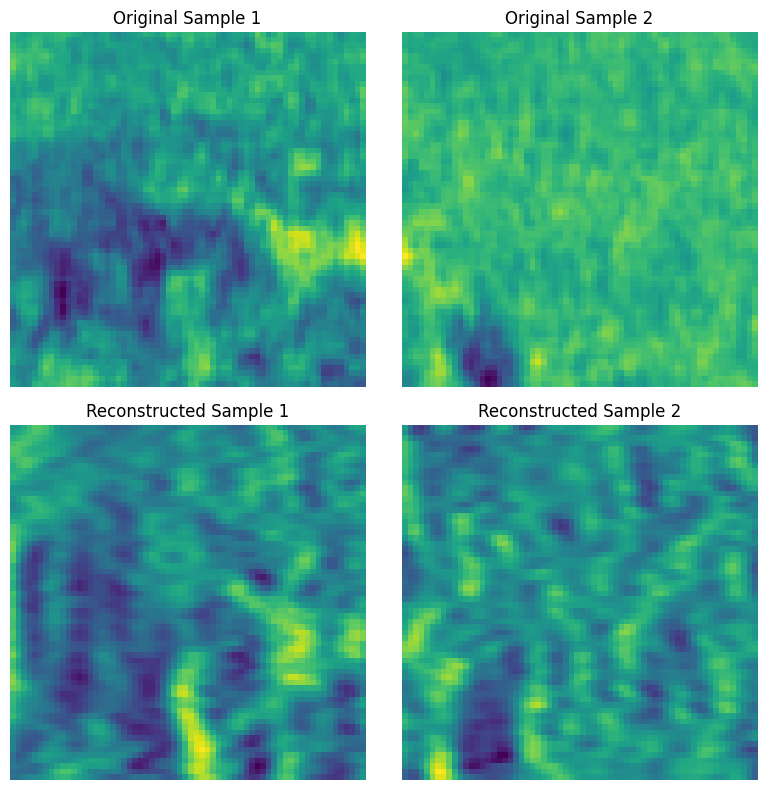


重建质量统计:
MSE: 0.104448
PSNR: 9.81 dB
处理的样本数量: 2
通道数: 1
图像尺寸: 64 x 64

量化分析:
码本大小: 42875
使用的码字数量: 247
码本利用率: 0.58%
最常用的5个码字: [10144  1477 40931  9654  1421]


/tmp/ipython-input-3424373684.py:256: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3424373684.py:256: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3424373684.py:256: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3424373684.py:256: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3424373684.py:256: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3424373684.py:256: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3424373684.py:256: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}

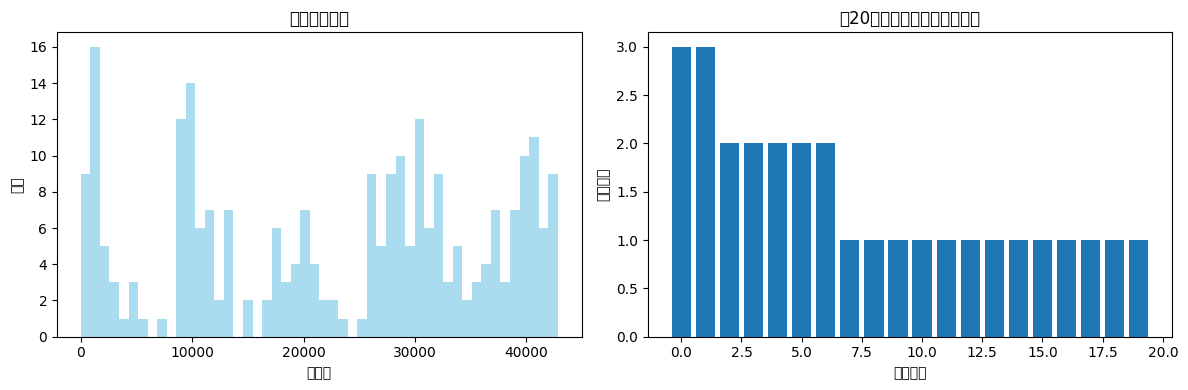


测试编码-解码流程...
编码索引形状: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
解码视频形状: torch.Size([1, 1, 64, 64])
编码-解码MSE: 0.084669

推理和可视化完成!


In [ ]:
# @title VQ-VAE Model Inference and Visualization {"vertical-output":true}
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import glob
from datetime import datetime

# 设置设备
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

def load_trained_vqvae(model_path, image_size, vid_channels, fsq_levels, init_dim=128, device='cuda'):
  """
  载入训练好的VQ-VAE模型

  Args:
      model_path: 模型权重文件路径
      image_size: 图像尺寸
      vid_channels: 视频通道数
      fsq_levels: FSQ量化级别
      init_dim: 初始维度
      device: 计算设备

  Returns:
      载入权重的VQ-VAE模型
  """
  # 重新实例化模型（确保架构一致）
  vqvae_model = VQVAE(
      image_size=image_size,
      channels=vid_channels,
      fsq_levels=fsq_levels,
      init_dim=init_dim,
      fsq_dim=None,  # 自动计算
  ).to(device)

  # 载入权重
  if os.path.exists(model_path):
      state_dict = torch.load(model_path, map_location=device)
      vqvae_model.load_state_dict(state_dict)
      print(f"Successfully loaded model from: {model_path}")
  else:
      raise FileNotFoundError(f"Model file not found: {model_path}")

  vqvae_model.eval()
  return vqvae_model

def visualize_reconstruction(original, reconstructed, indices=None, num_samples=4, num_frames=9):
    """
    可视化原始视频和重建视频的对比

    Args:
        original: 原始视频张量 [B, C, T, H, W] 或单帧张量 [B, C, H, W]
        reconstructed: 重建视频张量 [B, C, T, H, W] 或单帧张量 [B, C, H, W]
        indices: 量化索引（可选）
        num_samples: 显示的样本数量
        num_frames: 显示的帧数（对于单帧输入会被忽略）
    """
    # 确保输入是numpy数组
    if torch.is_tensor(original):
        original = original.detach().cpu().numpy()
    if torch.is_tensor(reconstructed):
        reconstructed = reconstructed.detach().cpu().numpy()

    # 调试信息
    print(f"Original shape: {original.shape}")
    print(f"Reconstructed shape: {reconstructed.shape}")

    # 检查输入是否为单帧（4维）还是视频序列（5维）
    is_single_frame = len(original.shape) == 4

    if is_single_frame:
        # 单帧情况：[B, C, H, W]
        batch_size, channels, height, width = original.shape
        num_frames = 1  # 强制设置为1帧
        print("检测到单帧输入，将显示图像对比")
    else:
        # 视频序列情况：[B, C, T, H, W]
        batch_size, channels, time_steps, height, width = original.shape
        num_frames = min(num_frames, time_steps)
        print(f"检测到视频序列输入，时间步数: {time_steps}")

    # 限制显示的样本数量
    num_samples = min(num_samples, batch_size)

    # 创建子图
    if is_single_frame:
        # 单帧情况：只需要2行（原始和重建）
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 4, 8))
        if num_samples == 1:
            axes = axes.reshape(2, 1)
    else:
        # 视频序列情况：保持原有布局
        fig, axes = plt.subplots(2 * num_samples, num_frames, figsize=(num_frames * 3, num_samples * 6))
        if num_samples == 1:
            axes = axes.reshape(2, num_frames)

    for sample_idx in range(num_samples):
        if is_single_frame:
            # 单帧处理
            # 获取原始数据
            orig_data = original[sample_idx]  # [C, H, W]
            recon_data = reconstructed[sample_idx]  # [C, H, W]

            print(f"Sample {sample_idx} - orig_data shape: {orig_data.shape}")
            print(f"Sample {sample_idx} - recon_data shape: {recon_data.shape}")

            if channels == 1:
                # 单通道图像：[1, H, W] -> [H, W]
                orig_frame = orig_data[0]  # [H, W]
                recon_frame = recon_data[0]  # [H, W]
            elif channels == 3:
                # RGB图像：[3, H, W] -> [H, W, 3]
                orig_frame = np.transpose(orig_data, (1, 2, 0))  # [H, W, 3]
                recon_frame = np.transpose(recon_data, (1, 2, 0))  # [H, W, 3]
            else:
                # 多通道情况，取第一个通道
                orig_frame = orig_data[0]  # [H, W]
                recon_frame = recon_data[0]  # [H, W]

            print(f"After processing - orig_frame shape: {orig_frame.shape}")
            print(f"After processing - recon_frame shape: {recon_frame.shape}")

            # 确保数据是2D（灰度）或3D（RGB）
            if orig_frame.ndim == 3 and orig_frame.shape[0] == 1:
                # 如果是 [1, H, W]，转换为 [H, W]
                orig_frame = orig_frame[0]
            if recon_frame.ndim == 3 and recon_frame.shape[0] == 1:
                # 如果是 [1, H, W]，转换为 [H, W]
                recon_frame = recon_frame[0]

            print(f"Final - orig_frame shape: {orig_frame.shape}")
            print(f"Final - recon_frame shape: {recon_frame.shape}")

            # 归一化到[0,1]范围用于显示
            orig_frame_norm = (orig_frame - orig_frame.min()) / (orig_frame.max() - orig_frame.min() + 1e-8)
            recon_frame_norm = (recon_frame - recon_frame.min()) / (recon_frame.max() - recon_frame.min() + 1e-8)

            # 显示原始图像
            if orig_frame_norm.ndim == 3 and orig_frame_norm.shape[-1] == 3:
                axes[0, sample_idx].imshow(orig_frame_norm)  # RGB
            else:
                axes[0, sample_idx].imshow(orig_frame_norm, cmap='viridis')  # 灰度
            axes[0, sample_idx].set_title(f'Original Sample {sample_idx+1}')
            axes[0, sample_idx].axis('off')

            # 显示重建图像
            if recon_frame_norm.ndim == 3 and recon_frame_norm.shape[-1] == 3:
                axes[1, sample_idx].imshow(recon_frame_norm)  # RGB
            else:
                axes[1, sample_idx].imshow(recon_frame_norm, cmap='viridis')  # 灰度
            axes[1, sample_idx].set_title(f'Reconstructed Sample {sample_idx+1}')
            axes[1, sample_idx].axis('off')

        else:
            # 视频序列处理（原有逻辑）
            for frame_idx in range(num_frames):
                if channels == 1:
                    # 单通道视频帧
                    orig_frame = original[sample_idx, 0, frame_idx]  # [H, W]
                    recon_frame = reconstructed[sample_idx, 0, frame_idx]  # [H, W]
                elif channels == 3:
                    # RGB视频帧：[3, H, W] -> [H, W, 3]
                    orig_frame = np.transpose(original[sample_idx, :, frame_idx], (1, 2, 0))  # [H, W, 3]
                    recon_frame = np.transpose(reconstructed[sample_idx, :, frame_idx], (1, 2, 0))  # [H, W, 3]
                else:
                    # 多通道情况，取第一个通道
                    orig_frame = original[sample_idx, 0, frame_idx]  # [H, W]
                    recon_frame = reconstructed[sample_idx, 0, frame_idx]  # [H, W]

                # 归一化到[0,1]范围用于显示
                orig_frame_norm = (orig_frame - orig_frame.min()) / (orig_frame.max() - orig_frame.min() + 1e-8)
                recon_frame_norm = (recon_frame - recon_frame.min()) / (recon_frame.max() - recon_frame.min() + 1e-8)

                # 显示原始帧
                if orig_frame_norm.ndim == 3 and orig_frame_norm.shape[-1] == 3:
                    axes[2*sample_idx, frame_idx].imshow(orig_frame_norm)
                else:
                    axes[2*sample_idx, frame_idx].imshow(orig_frame_norm, cmap='viridis')
                axes[2*sample_idx, frame_idx].set_title(f'Original S{sample_idx+1} F{frame_idx+1}')
                axes[2*sample_idx, frame_idx].axis('off')

                # 显示重建帧
                if recon_frame_norm.ndim == 3 and recon_frame_norm.shape[-1] == 3:
                    axes[2*sample_idx+1, frame_idx].imshow(recon_frame_norm)
                else:
                    axes[2*sample_idx+1, frame_idx].imshow(recon_frame_norm, cmap='viridis')
                axes[2*sample_idx+1, frame_idx].set_title(f'Reconstructed S{sample_idx+1} F{frame_idx+1}')
                axes[2*sample_idx+1, frame_idx].axis('off')

    plt.tight_layout()
    plt.show()

    # 计算重建误差统计
    mse = np.mean((original[:num_samples] - reconstructed[:num_samples]) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse + 1e-8))

    print(f"\n重建质量统计:")
    print(f"MSE: {mse:.6f}")
    print(f"PSNR: {psnr:.2f} dB")

    if is_single_frame:
        print(f"处理的样本数量: {num_samples}")
        print(f"通道数: {channels}")
        print(f"图像尺寸: {height} x {width}")
    else:
        print(f"处理的样本数量: {num_samples}")
        print(f"显示的帧数: {num_frames}")
        print(f"通道数: {channels}")
        print(f"图像尺寸: {height} x {width}")

def analyze_quantization(indices, codebook_size):
    """
    分析量化索引的分布

    Args:
        indices: 量化索引张量
        codebook_size: 码本大小
    """
    if torch.is_tensor(indices):
        indices_np = indices.detach().cpu().numpy().flatten()
    else:
        indices_np = indices.flatten()

    # 计算索引分布
    unique_indices, counts = np.unique(indices_np, return_counts=True)
    usage_ratio = len(unique_indices) / codebook_size

    print(f"\n量化分析:")
    print(f"码本大小: {codebook_size}")
    print(f"使用的码字数量: {len(unique_indices)}")
    print(f"码本利用率: {usage_ratio:.2%}")
    print(f"最常用的5个码字: {unique_indices[np.argsort(counts)[-5:]]}")

    # 可视化索引分布
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(indices_np, bins=min(50, len(unique_indices)), alpha=0.7, color='skyblue')
    plt.title('量化索引分布')
    plt.xlabel('索引值')
    plt.ylabel('频次')

    plt.subplot(1, 2, 2)
    # 修复：确保x轴和y轴数据长度匹配
    sorted_counts = np.sort(counts)[::-1]  # 降序排列
    num_bars = min(20, len(sorted_counts))  # 取前20个或所有（如果少于20个）

    plt.bar(range(num_bars), sorted_counts[:num_bars])
    plt.title(f'前{num_bars}个最常用码字的使用频次')
    plt.xlabel('码字排名')
    plt.ylabel('使用次数')

    plt.tight_layout()
    plt.show()

# === 主要推理和可视化代码 ===

# 1. 设置参数（与训练时保持一致）
IMAGE_SIZE = 64
VID_CHANNELS = 1
FSQ_LEVELS = [7, 7, 7, 5, 5, 5] # [8, 8, 8, 5, 5, 5] #@param
INIT_DIM = 128
BATCH_SIZE = 4 #@param
NUM_WORKERS = 1

# 3. 准备测试数据
print(f"原始地震数据形状: {seismic_data_video.shape}") # torch.Size([1280, 2, 64, 64])
i = 0
seismic_data_video = seismic_data_video[:,i:i+2]
if seismic_data_video.dim() == 4:  # [N, T, H, W]
  test_data = seismic_data_video.unsqueeze(1)  # 添加通道维度 [N, C, T, H, W]
else:
  test_data = seismic_data_video

print(f"测试数据形状: {test_data.shape}")

# 创建测试数据加载器
frame_dataset = FrameDataset(test_data)
test_dataloader = DataLoader(
    frame_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 没有设置SEED保证复现?
    num_workers=NUM_WORKERS
)

infer = True #@param
make_frames_tokens = False #@param

if infer:
  # 2. 找到并载入最新的训练模型
  try:
    checkpoint_dir = f_path + "/seismic_world_checkpoints"
    model_path = checkpoint_dir+'/vqvae_trained_best_20250630_042612.pth' #@param

    # 载入模型
    trained_vqvae = load_trained_vqvae(
        model_path=model_path,
        image_size=IMAGE_SIZE,
        vid_channels=VID_CHANNELS,
        fsq_levels=FSQ_LEVELS,
        init_dim=INIT_DIM,
        device=DEVICE
    )

    print("模型载入成功!")

  except Exception as e:
    print(f"载入模型时出错: {e}")
    print("请确保已完成VQ-VAE训练并且模型文件存在")
    raise
  # 4. 执行推理
  print("\n开始推理...")
  idx = 900
  with torch.no_grad():
    # 取第一个批次进行详细分析
    test_batch = next(iter(test_dataloader)).to(DEVICE)
    # test_batch = test_data[idx:idx+4].to(DEVICE)
    print(f"测试批次形状: {test_batch.shape}")


    # 完整的前向传播
    reconstructed, indices, loss = trained_vqvae(
        test_batch,
        return_indices=True,
        return_loss=True
    )

    print(f"重建数据形状: {reconstructed.shape}")
    print(f"量化索引形状: {indices.shape}")
    print(f"重建损失: {loss.item():.6f}")

    # 5. 可视化结果
    print("\n生成可视化...")

    # 可视化重建对比
    visualize_reconstruction(
        original=test_batch,
        reconstructed=reconstructed,
        indices=indices,
        num_samples=min(2, test_batch.shape[0]),  # 显示2个样本
        num_frames=min(9, test_batch.shape[2])    # 显示9帧
    )

    # 分析量化效果
    codebook_size = trained_vqvae.quantizer.codebook_size
    analyze_quantization(indices, codebook_size)

  # # 6. 测试编码-解码流程
  print("\n测试编码-解码流程...")
  with torch.no_grad():
    # 直接编码到索引
    test_sample = test_batch[:1]  # 取一个样本 # [1,1,64,64]
    encoded_indices = trained_vqvae.encode_to_indices(test_sample)
    print(f"编码索引形状: {encoded_indices.shape}") # torch.Size([1, 1, 8, 8])

    # 从索引解码
    decoded_video = trained_vqvae.decode_from_indices(
        encoded_indices,
        video_contains_first_frame=True
    )
    print(f"解码视频形状: {decoded_video.shape}") # torch.Size([1, 1, 9, 64, 64])

    # 计算编码-解码的重建误差
    encode_decode_mse = F.mse_loss(test_sample, decoded_video).item()
    print(f"编码-解码MSE: {encode_decode_mse:.6f}") # 0.004258

  print("\n推理和可视化完成!")

if make_frames_tokens:
  def generate_video_tokens(vqvae_model, video_data, batch_size=4, device='cuda'):
      """
      使用VQ-VAE的encode_to_indices方法生成视频tokens

      Args:
          vqvae_model: 训练好的VQ-VAE模型
          video_data: 原始视频数据 [N, T, H, W] 或 [N, C, T, H, W]
          batch_size: 批处理大小
          device: 设备

      Returns:
          video_tokens: 所有视频的tokens [N, T, H', W'] 或相应形状
      """
      vqvae_model.eval()

      # # 确保数据格式正确
      # if video_data.dim() == 4:  # [N, T, H, W] - 缺少通道维度
      #     video_data = video_data.unsqueeze(1)  # -> [N, C, T, H, W]
      #     print(f"添加通道维度后的形状: {video_data.shape}")

      N, T, H, W = video_data.shape
      print(f"处理视频数据形状: {video_data.shape}")

      all_video_tokens = []

      with torch.no_grad():
          # 按视频批次处理
          for i in range(0, N, batch_size):
              end_idx = min(i + batch_size, N)
              batch_videos = video_data[i:end_idx].to(device)  # [batch_size, C, T, H, W]

              print(f"处理视频批次 {i//batch_size + 1}/{(N-1)//batch_size + 1}, "
                    f"视频索引 {i}-{end_idx-1}, 批次形状: {batch_videos.shape}")

              batch_tokens_list = []

              # 对批次中的每个视频逐帧处理
              for video_idx in range(batch_videos.shape[0]):
                  video = batch_videos[video_idx]  # [T, H, W]
                  video_tokens_list = []

                  # 逐帧编码
                  for t in range(T):
                      # 提取单帧 [C, H, W] -> [1, C, H, W] (添加batch维度)
                      frame = video[t:t+1, :, :].unsqueeze(0)
                      # 使用VQ-VAE的encode_to_indices方法直接获取tokens
                      frame_tokens = vqvae_model.encode_to_indices(frame)  # [1, H', W'] 或其他形状

                      # 移除batch维度
                      frame_tokens = frame_tokens.squeeze(0)  # [H', W'] 或其他形状

                      video_tokens_list.append(frame_tokens.cpu())

                  # 将该视频的所有帧tokens堆叠 [T, H', W'] 或相应形状
                  video_tokens = torch.stack(video_tokens_list, dim=0)
                  batch_tokens_list.append(video_tokens)

              # 将批次中的所有视频tokens堆叠 [batch_size, T, H', W']
              batch_tokens = torch.stack(batch_tokens_list, dim=0)
              all_video_tokens.append(batch_tokens)

      # 合并所有批次 [N, T, H', W']
      all_video_tokens = torch.cat(all_video_tokens, dim=0)

      print(f"生成的视频tokens形状: {all_video_tokens.shape}")
      print(f"Token数据类型: {all_video_tokens.dtype}")

      return all_video_tokens

  def generate_video_tokens_efficient(vqvae_model, video_data, batch_size=16, device='cuda'):
      """
      更高效的版本：将所有帧重组后批量处理

      Args:
          vqvae_model: 训练好的VQ-VAE模型
          video_data: 原始视频数据 [N, T, H, W] 或 [N, C, T, H, W]
          batch_size: 帧的批处理大小
          device: 设备

      Returns:
          video_tokens: 所有视频的tokens [N, T, H', W']
      """
      vqvae_model.eval()

      # 确保数据格式正确
      if video_data.dim() == 4:  # [N, T, H, W]
          video_data = video_data.unsqueeze(1)  # -> [N, C, T, H, W]

      N, C, T, H, W = video_data.shape
      print(f"处理视频数据形状: {video_data.shape}")

      # 重组数据：[N, C, T, H, W] -> [N*T, C, H, W]
      all_frames = video_data.view(N * T, C, H, W)
      print(f"重组后的帧数据形状: {all_frames.shape}")

      all_frame_tokens = []

      with torch.no_grad():
          # 批量处理所有帧
          for i in range(0, all_frames.shape[0], batch_size):
              end_idx = min(i + batch_size, all_frames.shape[0])
              batch_frames = all_frames[i:end_idx].to(device)  # [batch_size, C, H, W]

              print(f"处理帧批次 {i//batch_size + 1}/{(all_frames.shape[0]-1)//batch_size + 1}, "
                    f"帧索引 {i}-{end_idx-1}")

              # 批量编码帧
              batch_tokens = vqvae_model.encode_to_indices(batch_frames)  # [batch_size, H', W']
              all_frame_tokens.append(batch_tokens.cpu())

      # 合并所有帧tokens [N*T, H', W']
      all_frame_tokens = torch.cat(all_frame_tokens, dim=0)

      # 重新组织为视频格式 [N*T, H', W'] -> [N, T, H', W']
      token_shape = all_frame_tokens.shape[1:]  # (H', W') 或其他空间维度
      video_tokens = all_frame_tokens.view(N, T, *token_shape)

      print(f"生成的视频tokens形状: {video_tokens.shape}")
      print(f"Token数据类型: {video_tokens.dtype}")

      return video_tokens


  # 使用示例
  print("开始生成视频tokens...")

  # 方法1: 逐视频逐帧处理（更符合VideoWorld的处理方式）
  video_tokens = generate_video_tokens(
      vqvae_model=trained_vqvae,
      video_data=seismic_data_video,
      batch_size=BATCH_SIZE,
      device=DEVICE
  )

  # 或者使用方法2: 高效批量处理
  # video_tokens = generate_video_tokens_efficient(
  #     vqvae_model=trained_vqvae,
  #     video_data=seismic_data_video,
  #     batch_size=BATCH_SIZE * 4,  # 可以用更大的批次
  #     device=DEVICE
  # )

  print(f"完成! 生成了形状为 {video_tokens.shape} 的视频tokens")

  # 检查tokens的值范围（用于验证）
  print(f"Tokens值范围: min={video_tokens.min()}, max={video_tokens.max()}")
  print(f"Tokens唯一值数量: {len(torch.unique(video_tokens))}")

  from datetime import datetime

  # 生成详细的时间戳和描述信息
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  num_videos = video_tokens.shape[0]
  num_frames = video_tokens.shape[1]

  # 创建保存目录
  save_dir = f_path + "/dataset/frame_tokens"
  try:
      os.makedirs(save_dir, exist_ok=True)
      print(f"目录已创建/确认存在: {save_dir}")
  except Exception as e:
      print(f"创建目录失败: {e}")

  # 保存tokens
  filename = f"frame_tokens_{num_videos}videos_{num_frames}frames_{timestamp}.pt"
  save_path = f_path + f"/dataset/frame_tokens/{filename}"

  torch.save({
      'tokens': video_tokens,
      'original_shape': seismic_data_video.shape,
      'fsq_levels': FSQ_LEVELS,
      'codebook_size': trained_vqvae.codebook_size,
      'timestamp': timestamp,
      'generation_info': {
          'num_videos': num_videos,
          'frames_per_video': num_frames,
          'token_spatial_shape': video_tokens.shape[2:],
          'total_frames': num_videos * num_frames,
          'token_dtype': str(video_tokens.dtype),
          'device_used': str(DEVICE)
      }
  }, save_path)

  print(f"视频tokens已保存到: {save_path}")
  print(f"文件名: {filename}")

  # 可选：验证tokens可以正确解码
  print("\n验证tokens解码...")
  with torch.no_grad():
      # 取第一个视频的第一帧进行验证
      test_tokens = video_tokens[0, 0:1].to(DEVICE)  # [1, 1, H', W']

      try:
          decoded_frame = trained_vqvae.decode_from_indices(
              test_tokens,
              video_contains_first_frame=True
          )
          print(f"解码验证成功! 解码帧形状: {decoded_frame.shape}")
      except Exception as e:
          print(f"解码验证失败: {e}")
          print("这可能是正常的，取决于VQ-VAE的具体实现")

In [ ]:
# @title SeismicWorld auto-regressive transformer training
TRAIN_MODE = False #@param
LOAD_2_INFER = True #@param

# --- SeismicWorld Frame-Only Auto-regressive Transformer Training---
class SeismicWorld(nn.Module):
  def __init__(
      self,
      codebook_size_frame,
      special_token_count=3,     # BOS/EOS/PAD
      max_seq_length=1024,
      hidden_size=4096,
      num_hidden_layers=12,
      num_attention_heads=16,
      intermediate_size=4096,
      num_frame_tokens_per_step=16*16, # Number of frame tokens per time step
      pretrained_model_path=None,
      device=None,
  ):
      super().__init__()
      self.codebook_size_frame = codebook_size_frame
      self.special_token_count = special_token_count

      # Define vocabulary ranges (simplified without LDM tokens)
      self.frame_token_offset = 0  # Frame tokens start from 0
      self.special_token_offset = self.codebook_size_frame

      self.vocab_size = self.special_token_offset + special_token_count

      self.max_seq_length = max_seq_length
      self.num_frame_tokens_per_step = num_frame_tokens_per_step
      self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

      # InternLM configuration
      if pretrained_model_path:
          # from MoE.modeling_internlm import InternLMForCausalLM
          self.model = InternLMForCausalLM.from_pretrained(
              pretrained_model_path,
              torch_dtype=torch.float16,
              low_cpu_mem_usage=True,
          )
          print(f"Resizing token embeddings from {self.model.config.vocab_size} to {self.vocab_size}")
          self.model.resize_token_embeddings(self.vocab_size)
          if self.model.config.max_position_embeddings < max_seq_length:
              print(f"Resizing position embeddings from {self.model.config.max_position_embeddings} to {max_seq_length}")
              self.model.resize_position_embeddings(max_seq_length)
      else:
          # from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM
          config = InternLMConfig(
              vocab_size=self.vocab_size,
              hidden_size=hidden_size,
              num_hidden_layers=num_hidden_layers,
              num_attention_heads=num_attention_heads,
              intermediate_size=intermediate_size,
              max_position_embeddings=max_seq_length,
              rms_norm_eps=1e-6,
              use_cache=True,
          )
          self.model = InternLMForCausalLM(config)

      # Positional Encoding for frame sequences
      self.num_time_steps_for_pos = math.ceil(max_seq_length / self.num_frame_tokens_per_step) + 1
      self.time_pos_embed = nn.Embedding(self.num_time_steps_for_pos, hidden_size)
      self.step_pos_embed = nn.Embedding(self.num_frame_tokens_per_step, hidden_size)

      # Special token IDs
      self.bos_token_id = self.special_token_offset
      self.eos_token_id = self.special_token_offset + 1
      self.pad_token_id = self.special_token_offset + 2

      self.to(self.device)

  def get_token_type_ids(self, input_ids):
      """ Distinguish between BOS, Frame, PAD tokens """
      token_type_ids = torch.zeros_like(input_ids)
      # Mark Frame tokens (type 1)
      token_type_ids[(input_ids >= self.frame_token_offset) & (input_ids < self.special_token_offset)] = 1
      # Mark Special tokens (type 0)
      token_type_ids[input_ids == self.bos_token_id] = 0
      token_type_ids[input_ids == self.eos_token_id] = 0
      token_type_ids[input_ids == self.pad_token_id] = 0
      return token_type_ids

  def add_positional_encoding(self, input_ids):
      """
      Adds positional encoding based on time step and position within the step.
      Assumes input_ids shape [B, seq_len] and structure like:
      [BOS, frame_0_0, ..., frame_0_M, frame_1_0, ..., frame_1_M, ...]
      """
      batch_size, seq_len = input_ids.shape
      device = input_ids.device

      position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)

      # Calculate time step ID and position within step ID
      positions_after_bos = position_ids - 1  # -1 for positions relative to first frame token
      time_step_ids = torch.zeros_like(position_ids)
      position_in_step_ids = torch.zeros_like(position_ids)

      # Handle BOS token separately (time step 0, position 0)
      is_not_bos = (input_ids != self.bos_token_id)
      time_step_ids[is_not_bos] = positions_after_bos[is_not_bos] // self.num_frame_tokens_per_step + 1
      position_in_step_ids[is_not_bos] = positions_after_bos[is_not_bos] % self.num_frame_tokens_per_step

      # Clamp time_step_ids to max embedding index
      time_step_ids = torch.clamp(time_step_ids, 0, self.num_time_steps_for_pos - 1)

      # Get embeddings
      time_pos = self.time_pos_embed(time_step_ids)
      step_pos = self.step_pos_embed(position_in_step_ids)

      # Combine embeddings
      pos_encoding = time_pos + step_pos
      return pos_encoding

  def forward(
      self,
      input_ids,
      labels=None,
      attention_mask=None,
      return_dict=None
  ):
      """
      Teacher Forcing training for frame-only sequences.
      input_ids: [B, seq_len] - BOS + frame_0 + frame_1 + ...
      labels: [B, seq_len] - shifted input_ids with -100 for padding
      """
      return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict

      # Get token embeddings
      inputs_embeds = self.model.get_input_embeddings()(input_ids)

      # Add positional encoding
      pos_encoding = self.add_positional_encoding(input_ids)
      inputs_embeds = inputs_embeds + pos_encoding

      # Prepare attention mask if not provided
      if attention_mask is None:
          attention_mask = (input_ids != self.pad_token_id).long()

      # Call the underlying InternLM model
      outputs = self.model(
          inputs_embeds=inputs_embeds,
          attention_mask=attention_mask,
          labels=labels,
          use_cache=False,
          return_dict=return_dict,
          output_hidden_states=False,
          output_attentions=False,
      )

      return outputs

  @torch.no_grad()
  def generate(
      self,
      input_ids,
      max_new_tokens,
      attention_mask=None,
      temperature=1.0,
      top_k=None,
      eos_token_id=None,
      **kwargs
  ):
      """
      Autoregressive generation for frame sequences.
      """
      self.model.eval()
      device = input_ids.device
      batch_size, cur_len = input_ids.shape

      generated = input_ids
      past_key_values = None
      if attention_mask is None:
          attention_mask = torch.ones_like(input_ids)

      effective_eos_token_id = eos_token_id if eos_token_id is not None else self.eos_token_id

      for _ in range(max_new_tokens):
          if past_key_values is None:
              current_input_ids = generated
              current_attention_mask = attention_mask
          else:
              current_input_ids = generated[:, -1:]
              current_attention_mask = torch.cat(
                  [attention_mask, attention_mask.new_ones((batch_size, 1))], dim=-1
              )
              attention_mask = current_attention_mask

          # Get embeddings and add positional encoding
          inputs_embeds = self.model.get_input_embeddings()(current_input_ids)
          pos_encoding = self.add_positional_encoding(generated)
          if past_key_values is None:
              current_pos_encoding = pos_encoding
          else:
              current_pos_encoding = pos_encoding[:, -1:, :]

          current_inputs_embeds = inputs_embeds + current_pos_encoding

          # Forward pass
          outputs = self.model(
              inputs_embeds=current_inputs_embeds,
              attention_mask=current_attention_mask,
              past_key_values=past_key_values,
              use_cache=True,
              return_dict=True,
          )

          # Get logits for the next token
          next_token_logits = outputs.logits[:, -1, :]

          # Apply temperature scaling
          if temperature != 1.0:
              next_token_logits = next_token_logits / temperature

          # Apply top-k filtering
          if top_k is not None:
              v, _ = torch.topk(next_token_logits, top_k, dim=-1)
              next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')

          # Sample next token
          probs = F.softmax(next_token_logits, dim=-1)
          next_token = torch.multinomial(probs, num_samples=1)

          # Append generated token
          generated = torch.cat([generated, next_token], dim=1)

          # Update past_key_values
          past_key_values = outputs.past_key_values

          # Check for EOS token, no EOS in output
          if effective_eos_token_id is not None and (next_token == effective_eos_token_id).all():
              break

      return generated

# --- Training Pipeline for Frame-Only SeismicWorld (with EOS token and Best Model Saving) ---
def train_seismic_world_frame_only(
  seismic_data_video,  # torch.Size([1280, 2, 64, 64])
  vqvae_model,
  device,
  # Model hyperparameters
  transformer_hidden_size=1024,
  transformer_num_layers=8,
  transformer_num_heads=8,
  transformer_intermediate_size=4096,
  # Training hyperparameters
  transformer_batch_size=16,
  transformer_epochs=10,
  learning_rate=1e-4,
  max_grad_norm=1.0,
  num_workers=4,
  # Best model saving parameters
  validation_split=0.1,  # 10% for validation
  save_best_model=True,
  best_model_path='seismic_world_frame_only_best.pth',
  patience=3,  # Early stopping patience (optional)
  ### MODIFIED ###
  # Add a parameter to specify the path of the pre-trained model to continue training (fine-tuning)
  resume_from_checkpoint=None,
):
  """
  Complete training pipeline for frame-only SeismicWorld model with EOS token and best model saving.

  Args:
      seismic_data_video: Tensor of shape [1280, 2, 64, 64] - video data
      vqvae_model: Trained VQ-VAE model for frame tokenization
      device: Training device
      validation_split: Fraction of data to use for validation
      save_best_model: Whether to save the best model based on validation loss
      best_model_path: Path to save the best model
      patience: Early stopping patience (0 to disable early stopping)
      resume_from_checkpoint (str, optional): Path to a checkpoint to resume training from. Defaults to None.
  """

  print("=== Starting Frame-Only SeismicWorld Training (with EOS and Best Model Saving) ===")

  # Get VQ-VAE codebook size
  codebook_size_frame = vqvae_model.codebook_size
  print(f"Frame codebook size: {codebook_size_frame}")

  # Calculate sequence parameters
  # Assuming VQ-VAE downsamples 64x64 to 8x8
  num_frame_tokens_per_step = 8 * 8  # Adjust based on actual VQ-VAE output
  frame_num = seismic_data_video.shape[1]  # 2 frames per video

  # Sequence structure: BOS + Frame_0_tokens + Frame_1_tokens + EOS
  max_seq_length = 1 + frame_num * num_frame_tokens_per_step + 1  # +1 for EOS
  print(f"Max sequence length: {max_seq_length}")

  # Initialize transformer model
  model_transformer = SeismicWorld(
      codebook_size_frame=codebook_size_frame,
      special_token_count=3,  # BOS, EOS, PAD
      max_seq_length=max_seq_length,
      hidden_size=transformer_hidden_size,
      num_hidden_layers=transformer_num_layers,
      num_attention_heads=transformer_num_heads,
      intermediate_size=transformer_intermediate_size,
      num_frame_tokens_per_step=num_frame_tokens_per_step,
      device=device,
  ).to(device)

  # Setup optimizer
  optimizer_transformer = torch.optim.AdamW(
      model_transformer.parameters(),
      lr=learning_rate,
      weight_decay=0.01
  )

  ### MODIFIED ###
  # --- RESUME FROM CHECKPOINT ---
  start_epoch = 0
  best_train_loss = float('inf')
  # Check if a checkpoint path is provided and the file exists
  if resume_from_checkpoint and os.path.exists(resume_from_checkpoint):
      print(f"--- Resuming training from checkpoint: {resume_from_checkpoint} ---")
      checkpoint = torch.load(resume_from_checkpoint, map_location=device)

      # Load model and optimizer states
      model_transformer.load_state_dict(checkpoint['model_state_dict'])
      optimizer_transformer.load_state_dict(checkpoint['optimizer_state_dict'])

      # Restore training state
      start_epoch = checkpoint['epoch']
      best_train_loss = checkpoint.get('best_train_loss', float('inf'))

      print(f"  -> Resuming from epoch {start_epoch + 1}")
      print(f"  -> Loaded model and optimizer state.")
      print(f"  -> Previous best training loss: {best_train_loss:.4f}")
  else:
      print("--- Starting training from scratch ---")


  print("--- Preparing Frame Tokens ---")
  vqvae_model.eval()
  vqvae_model.to(device)

  all_input_ids = []
  all_labels = []
  all_attention_masks = []

  # Process data in batches to manage memory
  batch_size_prep = 64  # Batch size for token preparation
  num_batches = math.ceil(len(seismic_data_video) / batch_size_prep)

  with torch.no_grad():
      for batch_idx in tqdm(range(num_batches), desc="Generating Frame Tokens"):
          start_idx = batch_idx * batch_size_prep
          end_idx = min(start_idx + batch_size_prep, len(seismic_data_video))

          # Get batch data: [B, T, H, W]
          batch_videos = seismic_data_video[start_idx:end_idx].to(device)
          current_batch_size = batch_videos.size(0)
          # print(f'batch_videos={batch_videos.shape}') # torch.Size([64, 2, 64, 64])

          # Get frame tokens from VQ-VAE
          # Expected output: [B, T', H', W'] where T'=2, H'=8, W'=8
          all_frame_indices_1 = vqvae_model.encode_to_indices(batch_videos[:,:1,...])
          all_frame_indices_2 = vqvae_model.encode_to_indices(batch_videos[:,1:2,...])
          all_frame_indices = torch.cat([all_frame_indices_1, all_frame_indices_2], dim=1)

          # print(f'all_frame_indices={all_frame_indices.shape}')

          # Reshape: [B, T', H', W'] -> [B, T', H'*W']
          B, T_prime, H_prime, W_prime = all_frame_indices.shape
          num_space_frame_tokens = H_prime * W_prime
          all_frame_indices_flat = all_frame_indices.view(B, T_prime, num_space_frame_tokens)

          # Construct sequences: BOS + Frame_0 + Frame_1 + ... + EOS
          bos_token = torch.full(
              (current_batch_size, 1),
              model_transformer.bos_token_id,
              device=device,
              dtype=torch.long
          )

          eos_token = torch.full(
              (current_batch_size, 1),
              model_transformer.eos_token_id,
              device=device,
              dtype=torch.long
          )

          # Build sequence for each sample
          sequence_parts = [bos_token]

          for t in range(T_prime):
              frame_tokens = all_frame_indices_flat[:, t, :]  # [B, num_space_frame_tokens]
              # Add frame token offset
              frame_tokens_offset = frame_tokens + model_transformer.frame_token_offset
              sequence_parts.append(frame_tokens_offset)

          # Add EOS token at the end
          sequence_parts.append(eos_token)

          # Concatenate all parts to get complete sequence
          # [BOS, frame0_tokens..., frame1_tokens..., EOS]
          complete_sequence = torch.cat(sequence_parts, dim=1)

          # === CORRECTED INPUT/LABEL CREATION ===
          seq_len = complete_sequence.shape[1]

          # Check if sequence is too long
          if seq_len > model_transformer.max_seq_length:
              print(f"Warning: Sequence length {seq_len} exceeds max {model_transformer.max_seq_length}. Truncating.")
              complete_sequence = complete_sequence[:, :model_transformer.max_seq_length]
              seq_len = model_transformer.max_seq_length

          # Create input_ids and labels with proper shifting
          # input_ids: [BOS, frame0_tokens..., frame1_tokens...]  (all tokens except EOS)
          # labels:    [frame0_tokens..., frame1_tokens..., EOS]   (all tokens except BOS)
          input_ids = complete_sequence[:, :-1]  # Remove last token (EOS for input)
          labels = complete_sequence[:, 1:]      # Remove first token (BOS for labels)

          # Current lengths after shifting
          current_input_len = input_ids.shape[1]
          current_label_len = labels.shape[1]

          # Pad to max_seq_length - 1 (to account for the shift)
          target_length = model_transformer.max_seq_length - 1

          if current_input_len < target_length:
              padding_length = target_length - current_input_len

              # Pad input_ids with pad_token_id
              input_padding = torch.full(
                  (current_batch_size, padding_length),
                  model_transformer.pad_token_id,
                  device=device,
                  dtype=torch.long
              )
              input_ids = torch.cat([input_ids, input_padding], dim=1)

              # Pad labels with -100 (ignored in loss calculation)
              label_padding = torch.full(
                  (current_batch_size, padding_length),
                  -100,
                  device=device,
                  dtype=torch.long
              )
              labels = torch.cat([labels, label_padding], dim=1)

          # Create attention mask (1 for real tokens, 0 for padding)
          attention_mask = (input_ids != model_transformer.pad_token_id).long()

          # Store results
          all_input_ids.append(input_ids.cpu())
          all_labels.append(labels.cpu())
          all_attention_masks.append(attention_mask.cpu())

  # Combine all processed batches
  all_input_ids_tensor = torch.cat(all_input_ids, dim=0)
  all_labels_tensor = torch.cat(all_labels, dim=0)
  all_attention_masks_tensor = torch.cat(all_attention_masks, dim=0)

  print(f"Total training samples: {len(all_input_ids_tensor)}")
  print(f"Input shape: {all_input_ids_tensor.shape}")
  print(f"Labels shape: {all_labels_tensor.shape}")
  print(f"Attention mask shape: {all_attention_masks_tensor.shape}")

  # === TRAIN/VALIDATION SPLIT ===
  total_samples = len(all_input_ids_tensor)
  val_size = int(total_samples * validation_split)
  train_size = total_samples - val_size

  # Random split
  indices = torch.randperm(total_samples)
  train_indices = indices[:train_size]
  val_indices = indices[train_size:]

  # Create train and validation datasets
  train_input_ids = all_input_ids_tensor[train_indices]
  train_attention_masks = all_attention_masks_tensor[train_indices]
  train_labels = all_labels_tensor[train_indices]

  val_input_ids = all_input_ids_tensor[val_indices]
  val_attention_masks = all_attention_masks_tensor[val_indices]
  val_labels = all_labels_tensor[val_indices]

  print(f"Training samples: {len(train_input_ids)}")
  print(f"Validation samples: {len(val_input_ids)}")

  # Create datasets and dataloaders
  train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
  val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

  train_dataloader = DataLoader(
      train_dataset,
      batch_size=transformer_batch_size,
      shuffle=True,
      num_workers=num_workers
  )
  val_dataloader = DataLoader(
      val_dataset,
      batch_size=transformer_batch_size,
      shuffle=False,
      num_workers=num_workers
  )

  # === BEST MODEL TRACKING VARIABLES ===
  best_epoch = start_epoch if 'checkpoint' in locals() else 0
  epochs_without_improvement = 0

  print("--- Starting Transformer Training ---")
  model_transformer.train()

  ### MODIFIED ###
  # The loop now starts from `start_epoch` (0 if new training, checkpoint epoch number if resuming)
  for epoch in range(start_epoch, transformer_epochs):
      # === TRAINING PHASE ===
      model_transformer.train()
      epoch_train_loss = 0.0
      train_progress_bar = tqdm(
          train_dataloader,
          desc=f"Training Epoch {epoch+1}/{transformer_epochs}"
      )

      for input_ids, attention_mask, labels in train_progress_bar:
          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)
          labels = labels.to(device)

          optimizer_transformer.zero_grad()

          # Forward pass
          outputs = model_transformer(
              input_ids=input_ids,
              labels=labels,
              attention_mask=attention_mask,
              return_dict=True
          )

          transformer_loss = outputs.loss

          # Check for valid loss
          if transformer_loss is None:
              print("Warning: Transformer loss is None. Skipping step.")
              continue
          if torch.isnan(transformer_loss) or torch.isinf(transformer_loss):
              print(f"Warning: Invalid loss: {transformer_loss.item()}. Skipping step.")
              continue

          epoch_train_loss += transformer_loss.item()

          # Backward pass
          transformer_loss.backward()
          torch.nn.utils.clip_grad_norm_(model_transformer.parameters(), max_grad_norm)
          optimizer_transformer.step()

          train_progress_bar.set_postfix(loss=transformer_loss.item())

      avg_train_loss = epoch_train_loss / len(train_dataloader)

      # === VALIDATION PHASE ===
      model_transformer.eval()
      epoch_val_loss = 0.0
      val_progress_bar = tqdm(
          val_dataloader,
          desc=f"Validation Epoch {epoch+1}/{transformer_epochs}"
      )

      with torch.no_grad():
          for input_ids, attention_mask, labels in val_progress_bar:
              input_ids = input_ids.to(device)
              attention_mask = attention_mask.to(device)
              labels = labels.to(device)

              # Forward pass
              outputs = model_transformer(
                  input_ids=input_ids,
                  labels=labels,
                  attention_mask=attention_mask,
                  return_dict=True
              )

              val_loss = outputs.loss

              if val_loss is not None and not (torch.isnan(val_loss) or torch.isinf(val_loss)):
                  epoch_val_loss += val_loss.item()

              val_progress_bar.set_postfix(loss=val_loss.item() if val_loss is not None else 0.0)

      avg_val_loss = epoch_val_loss / len(val_dataloader)

      print(f"Epoch {epoch+1}/{transformer_epochs}")
      print(f"  Train Loss: {avg_train_loss:.4f}")
      # print(f"  Val Loss:   {avg_val_loss:.4f}")

      # === BEST MODEL SAVING ===
      if save_best_model and avg_train_loss < best_train_loss:
          best_train_loss = avg_train_loss
          best_epoch = epoch + 1
          epochs_without_improvement = 0

          # Save best model
          torch.save({
              'epoch': epoch + 1,
              'model_state_dict': model_transformer.state_dict(),
              'optimizer_state_dict': optimizer_transformer.state_dict(),
              'train_loss': avg_train_loss,
              'val_loss': avg_val_loss,
              'best_train_loss': best_train_loss,
          }, best_model_path)

          print(f"  🎉 New best model saved! Train Loss: {best_train_loss:.4f}")
      else:
          epochs_without_improvement += 1
          print(f"  No improvement for {epochs_without_improvement} epochs. Best: {best_train_loss:.4f} (Epoch {best_epoch})")

      # === EARLY STOPPING ===
      if patience > 0 and epochs_without_improvement >= patience:
          print(f"\n⏹️  Early stopping triggered after {patience} epochs without improvement.")
          print(f"Best training loss: {best_train_loss:.4f} at epoch {best_epoch}")
          break

  print("\n--- Training Complete ---")
  print(f"Best training loss: {best_train_loss:.4f} achieved at epoch {best_epoch}")

  # Load best model if it was saved
  if save_best_model and os.path.exists(best_model_path):
      print(f"Loading best model from {best_model_path}")
      checkpoint = torch.load(best_model_path, map_location=device)
      model_transformer.load_state_dict(checkpoint['model_state_dict'])
      print(f"Best model loaded (Epoch {checkpoint['epoch']}, Train Loss: {checkpoint['train_loss']:.4f})")

  return model_transformer, best_train_loss, best_epoch

# --- Inference Function with EOS Detection ---
def generate_next_frame(model, vqvae_model, first_frame, device, max_new_tokens=64, temperature=1.0):
    """
    Generate the next frame given the first frame.

    Args:
        model: Trained SeismicWorld model
        vqvae_model: VQ-VAE model for encoding/decoding
        first_frame: Input frame tensor [H, W] or [1, H, W]
        device: Device for computation
        max_new_tokens: Maximum number of tokens to generate
        temperature: Sampling temperature

    Returns:
        generated_frame: The generated next frame
    """
    model.eval()
    vqvae_model.eval()

    with torch.no_grad():
        # Encode first frame to tokens
        if first_frame.dim() == 2:
            first_frame = first_frame.unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
        elif first_frame.dim() == 3:
            first_frame = first_frame.unsqueeze(0)  # [1, C, H, W]

        # Get frame tokens: [1, 1, H', W'] -> [1, H'*W']
        frame_indices = vqvae_model.encode_to_indices(first_frame.unsqueeze(1).to(device))
        frame_tokens = frame_indices.view(1, -1)  # Flatten spatial dimensions

        # Add frame token offset
        frame_tokens_offset = frame_tokens + model.frame_token_offset

        # Create initial sequence: [BOS, frame0_tokens...]
        bos_token = torch.tensor([[model.bos_token_id]], device=device)
        input_sequence = torch.cat([bos_token, frame_tokens_offset], dim=1)

        # Generate tokens one by one
        for _ in range(max_new_tokens):
            # Get model predictions
            outputs = model(input_ids=input_sequence, return_dict=True)
            logits = outputs.logits  # [1, seq_len, vocab_size]

            # Get next token probabilities
            next_token_logits = logits[0, -1, :] / temperature  # [vocab_size]
            next_token_probs = torch.softmax(next_token_logits, dim=-1)

            # Sample next token
            next_token = torch.multinomial(next_token_probs, 1)  # [1]

            # Check if EOS token
            if next_token.item() == model.eos_token_id:
                print("Generated EOS token. Stopping generation.")
                break

            # Add to sequence
            input_sequence = torch.cat([input_sequence, next_token.unsqueeze(0)], dim=1)

            # Check sequence length limit
            if input_sequence.shape[1] >= model.max_seq_length:
                print("Reached maximum sequence length. Stopping generation.")
                break

        # Extract generated frame tokens (everything after first frame and BOS)
        first_frame_end = 1 + frame_tokens.shape[1]  # BOS + first_frame_tokens
        generated_tokens = input_sequence[0, first_frame_end:]  # Generated tokens only

        # Remove frame token offset
        generated_frame_tokens = generated_tokens - model.frame_token_offset

        # Reshape to spatial dimensions and decode
        num_spatial_tokens = 8 * 8  # Adjust based on VQ-VAE output
        if len(generated_frame_tokens) >= num_spatial_tokens:
            # Take only the tokens for one frame
            frame_tokens_2d = generated_frame_tokens[:num_spatial_tokens].view(1, 1, 8, 8)

            # Decode using VQ-VAE
            generated_frame = vqvae_model.decode_from_indices(frame_tokens_2d)
            return generated_frame.squeeze()
        else:
            print(f"Warning: Generated only {len(generated_frame_tokens)} tokens, expected {num_spatial_tokens}")
            return None

def load_trained_seismic_world(
    model_path,
    codebook_size_frame,
    max_seq_length=130,  # Adjust based on your training setup
    hidden_size=1024,
    num_hidden_layers=8,
    num_attention_heads=8,
    intermediate_size=4096,
    num_frame_tokens_per_step=64,
    device=None
):
    """
    Load a trained SeismicWorld model from checkpoint.

    Args:
        model_path: Path to the saved model checkpoint
        codebook_size_frame: VQ-VAE codebook size
        max_seq_length: Maximum sequence length used during training
        hidden_size: Transformer hidden size
        num_hidden_layers: Number of transformer layers
        num_attention_heads: Number of attention heads
        intermediate_size: Transformer intermediate size
        num_frame_tokens_per_step: Tokens per frame
        device: Device to load model on

    Returns:
        model: Loaded SeismicWorld model
        checkpoint: Checkpoint dictionary with training info
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model with same architecture as training
    model = SeismicWorld(
        codebook_size_frame=codebook_size_frame,
        special_token_count=3,  # BOS, EOS, PAD
        max_seq_length=max_seq_length,
        hidden_size=hidden_size,
        num_hidden_layers=num_hidden_layers,
        num_attention_heads=num_attention_heads,
        intermediate_size=intermediate_size,
        num_frame_tokens_per_step=num_frame_tokens_per_step,
        device=device,
    ).to(device)

    # Load checkpoint
    print(f"Loading model from {model_path}")
    checkpoint = torch.load(model_path, map_location=device)

    # Load model state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Print checkpoint info
    print(f"Model loaded successfully!")
    print(f"  Epoch: {checkpoint.get('epoch', 'Unknown')}")
    print(f"  Train Loss: {checkpoint.get('train_loss', 'Unknown'):.4f}")
    print(f"  Val Loss: {checkpoint.get('val_loss', 'Unknown'):.4f}")
    # print(f"  Best Val Loss: {checkpoint.get('best_val_loss', 'Unknown'):.4f}")

    return model, checkpoint

# --- 训练 ---
# seismic_data_video: torch.Size([1280, 2, 64, 64])

# vqvae_model: trained VQ-VAE model
# Frame Tokenizer / VQ-VAE
IMAGE_SIZE = 64
VID_CHANNELS = 1
FSQ_LEVELS = [7, 7, 7, 5, 5, 5] # [8, 8, 8, 5, 5, 5]
INIT_DIM = 128
BATCH_SIZE = 4
NUM_WORKERS = 1

checkpoint_dir = f_path + "/seismic_world_checkpoints"
model_path = checkpoint_dir+'/vqvae_trained_best_20250630_042612.pth' #@param

# 载入模型
vqvae_model = load_trained_vqvae(
    model_path=model_path,
    image_size=IMAGE_SIZE,
    vid_channels=VID_CHANNELS,
    fsq_levels=FSQ_LEVELS,
    init_dim=INIT_DIM,
    device=DEVICE
)

print("模型载入成功!")

codebook_size_frame = 42875 # Example: Set your frame VQ-VAE codebook size
num_space_frame_tokens = 8*8 # Example: Number of tokens per frame (e.g., 16x16 spatial resolution)

pretrained_checkpoint_path = checkpoint_dir+'/seismic_world_best_finetuned_20250630.pth' #@param

if TRAIN_MODE:
  # Make sure the checkpoint file exists before trying to resume
  if not os.path.exists(pretrained_checkpoint_path):
      print(f"Checkpoint file not found at {pretrained_checkpoint_path}. Starting training from scratch.")
      pretrained_checkpoint_path = None


  model_transformer, best_train_loss, best_epoch = train_seismic_world_frame_only(
      # Data parameters
      seismic_data_video=seismic_data_video.squeeze(1),
      vqvae_model=vqvae_model,
      device=DEVICE,

      # Model hyperparameters (should generally match the pre-trained model)
      transformer_hidden_size=1024,
      transformer_num_layers=8,
      transformer_num_heads=16,
      transformer_intermediate_size=4096,

      # Training hyperparameters (you might want to use a lower learning rate for fine-tuning)
      transformer_batch_size=6,
      transformer_epochs=100, #@param # You can set a new total number of epochs
      learning_rate=5e-5,      # A smaller learning rate is often used for fine-tuning
      max_grad_norm=1.0,
      num_workers=1,

      # Validation and saving parameters
      validation_split=0.05,
      save_best_model=True,
      # It's good practice to save the fine-tuned model to a new file
      best_model_path=checkpoint_dir+'/seismic_world_best_finetuned.pth',
      patience=5, # You might want to adjust patience for fine-tuning

      ### MODIFIED ###
      # Pass the path to your pre-trained model here
      resume_from_checkpoint=pretrained_checkpoint_path
  )

  print("--- Fine-tuning Complete ---")

if LOAD_2_INFER:
  # --- Load the trained model ---
  infer_model_path = checkpoint_dir + '/seismic_world_best_finetuned_20250630.pth' #@param
  loaded_model, checkpoint_info = load_trained_seismic_world(
      model_path=infer_model_path,
      codebook_size_frame=42875,  # Use the same as training
      max_seq_length=130,         # BOS + 64 + 64 + EOS + PAD = 130 or 65
      hidden_size=1024,
      num_hidden_layers=8,
      num_attention_heads=16,
      intermediate_size=4096,
      num_frame_tokens_per_step=64,
      device=DEVICE
  )

  # Set to evaluation mode for inference
  loaded_model.eval()
  print("Model ready for inference!")


Auto-determined FSQ dimension: 512


InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Successfully loaded model from: /content/drive/MyDrive/SeismicWorld/seismic_world_checkpoints/vqvae_trained_best_20250630_042612.pth
模型载入成功!
Loading model from /content/drive/MyDrive/SeismicWorld/seismic_world_checkpoints/seismic_world_best_finetuned_20250630.pth
Model loaded successfully!
  Epoch: 149
  Train Loss: 0.1155
  Val Loss: 10.1512
Model ready for inference!


=== Frame-to-Frame Generation Example ===
Using sample from seismic_data_video: torch.Size([1, 1, 64, 64])
Encoding first frame to tokens...
First frame indices shape: torch.Size([1, 1, 8, 8])
Second frame indices shape: torch.Size([1, 1, 8, 8])
First frame tokens shape: torch.Size([1, 64])
Second frame tokens shape: torch.Size([1, 64])
Input sequence shape (BOS + first frame): torch.Size([1, 65])
Target sequence shape (BOS + second frame): torch.Size([1, 65])
Generating next frame...
Generated sequence shape: torch.Size([1, 129])
Original input length: 65
Generated tokens: 64
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 63
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: tor

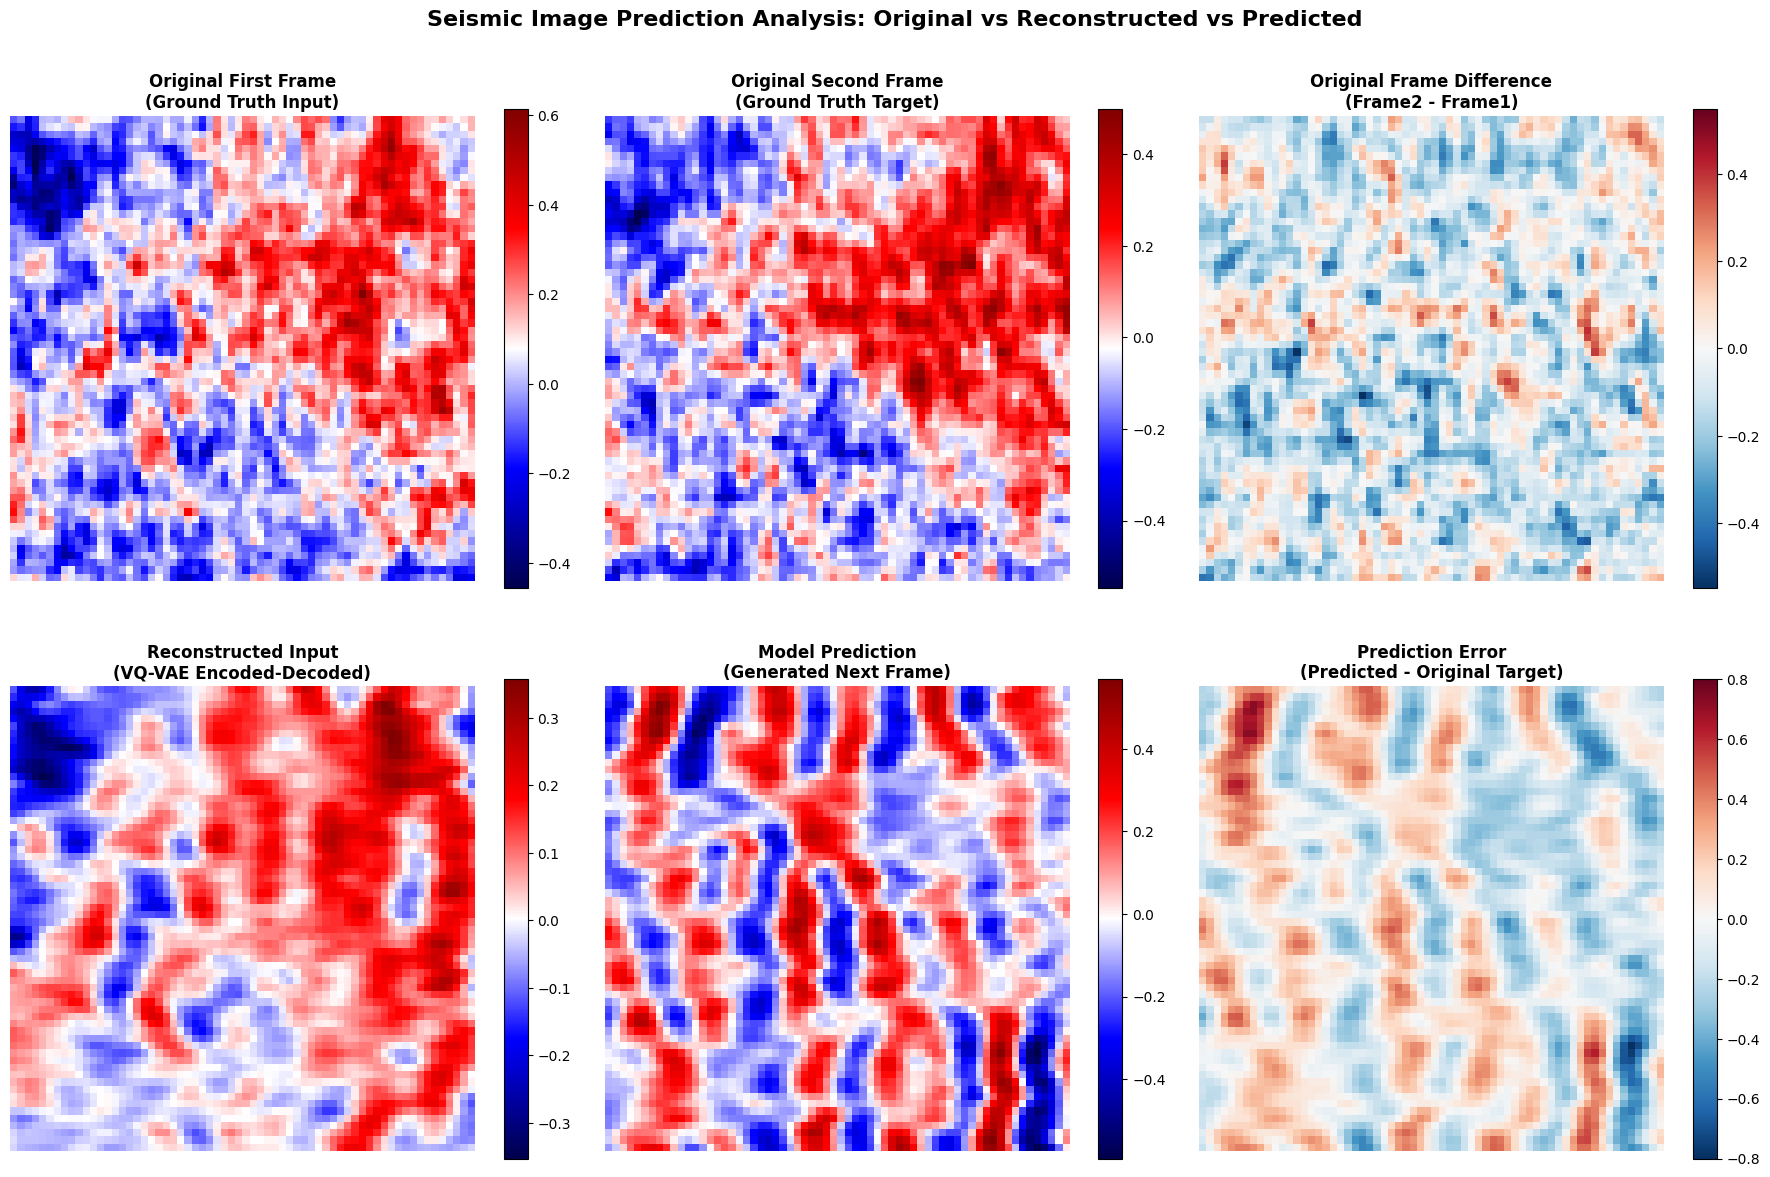

In [ ]:
#@title Generation: Given first frame, predict next frame
SEED = 0 #@param
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)          # 若用单块 GPU

#@title reconstruct image from generated sequence
def reconstruct_images_from_generated_sequence(
    generated_sequence,
    vqvae_model,
    seismic_world_model,
    device,
    return_both_frames=True
):
    """
    将生成的token序列重建为图片

    Args:
        generated_sequence: [1, seq_len] 生成的token序列
        vqvae_model: 训练好的VQ-VAE模型
        seismic_world_model: SeismicWorld模型 (用于获取token偏移量)
        device: 设备
        return_both_frames: 是否返回两帧图片，否则只返回生成的第二帧

    Returns:
        reconstructed_images: 重建的图片 tensor
    """
    vqvae_model.eval()

    with torch.no_grad():
        # 1. 移除 BOS token 和可能的 EOS/PAD tokens
        sequence = generated_sequence.squeeze(0)  # [seq_len]

        # 找到有效的frame tokens (排除特殊tokens)
        frame_mask = (sequence >= seismic_world_model.frame_token_offset) & \
                    (sequence < seismic_world_model.special_token_offset)

        frame_tokens = sequence[frame_mask]
        print(f"Valid frame tokens: {len(frame_tokens)}")

        # 2. 移除token偏移量，恢复原始VQ-VAE indices
        frame_indices = frame_tokens - seismic_world_model.frame_token_offset

        # 3. 根据每帧64个tokens分割序列
        tokens_per_frame = seismic_world_model.num_frame_tokens_per_step  # 64

        if len(frame_indices) < tokens_per_frame:
            print(f"Warning: Not enough tokens for a complete frame. Got {len(frame_indices)}, expected {tokens_per_frame}")
            # 用0填充不足的tokens
            padding_needed = tokens_per_frame - len(frame_indices)
            padding = torch.zeros(padding_needed, dtype=frame_indices.dtype, device=device)
            frame_indices = torch.cat([frame_indices, padding])

        reconstructed_frames = []

        # 4. 处理每一帧
        num_complete_frames = len(frame_indices) // tokens_per_frame
        print(f"Number of complete frames to reconstruct: {num_complete_frames}")

        for frame_idx in range(num_complete_frames):
            start_idx = frame_idx * tokens_per_frame
            end_idx = start_idx + tokens_per_frame

            # 获取当前帧的indices
            current_frame_indices = frame_indices[start_idx:end_idx]

            # 5. 重塑为空间维度 [1, 1, 8, 8] (假设是8x8的spatial tokens)
            spatial_size = int(math.sqrt(tokens_per_frame))  # 8
            current_frame_indices = current_frame_indices.view(1, 1, spatial_size, spatial_size)

            print(f"Frame {frame_idx} indices shape: {current_frame_indices.shape}")

            # 6. 使用VQ-VAE解码
            try:
                reconstructed_frame = vqvae_model.decode_from_indices(
                    current_frame_indices,
                    video_contains_first_frame=True
                )

                print(f"Frame {frame_idx} reconstructed shape: {reconstructed_frame.shape}")
                reconstructed_frames.append(reconstructed_frame)

            except Exception as e:
                print(f"Error reconstructing frame {frame_idx}: {e}")
                # 创建一个零填充的帧作为fallback
                fallback_frame = torch.zeros(1, 1, 64, 64, device=device)
                reconstructed_frames.append(fallback_frame)

        if not reconstructed_frames:
            print("No frames could be reconstructed!")
            return None

        # 7. 组合所有帧
        if return_both_frames and len(reconstructed_frames) >= 2:
            # 返回两帧 [1, 2, 64, 64]
            combined_frames = torch.cat(reconstructed_frames[:2], dim=1)
        elif len(reconstructed_frames) >= 1:
            # 只返回第一帧（或生成的帧）
            combined_frames = reconstructed_frames[-1]  # 取最后生成的帧
        else:
            return None

        return combined_frames

# Generation example: Given first frame, predict next frame
print("=== Frame-to-Frame Generation Example ===")

index_TRAIN = 5 #@param {type:"integer"}
index_Val = 0 #@param {type:"integer"}
suffix = '1999-2006_tuned_训练过程展示_低频信息' #@param


# Method 1: Using a sample from your seismic data
if 'seismic_data_video' in locals() and index_TRAIN != 0:
    # Take the first frame from your seismic data
    sample_first_frame = seismic_data_video[index_TRAIN:index_TRAIN+1, 0:1, :, :]  # [1, 1, 64, 64]
    sample_second_frame = seismic_data_video[index_TRAIN:index_TRAIN+1, 1:2, :, :]  # [1, 1, 64, 64]
    print(f"Using sample from seismic_data_video: {sample_first_frame.shape}")
elif 'seismic_data_video' in locals() and index_Val != 0:
    seismic_data_video_test = filtered_tensor_test # fine-tune
    sample_first_frame = seismic_data_video_test[index_Val:index_Val+1, 0:1, :, :]  # [1, 1, 64, 64]
    sample_second_frame = seismic_data_video_test[index_Val:index_Val+1, 1:2, :, :]  # [1, 1, 64, 64]
else:
    print(f"seismic_data_video DOES NOT EXIST!")

# Encode the first frame using VQ-VAE
print("Encoding first frame to tokens...")
vqvae_model.eval()
with torch.no_grad():
    # Encode first frame: [1, 1, 64, 64] -> [1, 1, 8, 8]
    first_frame_indices = vqvae_model.encode_to_indices(sample_first_frame.to(DEVICE))
    second_frame_indices = vqvae_model.encode_to_indices(sample_second_frame.to(DEVICE))
    print(f"First frame indices shape: {first_frame_indices.shape}")
    print(f"Second frame indices shape: {second_frame_indices.shape}")

    # Flatten spatial dimensions: [1, 1, 8, 8] -> [1, 64]
    first_frame_tokens = first_frame_indices.view(1, -1)
    second_frame_tokens = second_frame_indices.view(1, -1)
    print(f"First frame tokens shape: {first_frame_tokens.shape}")
    print(f"Second frame tokens shape: {second_frame_tokens.shape}")

    # Add frame token offset
    first_frame_tokens_offset = first_frame_tokens + loaded_model.frame_token_offset
    second_frame_tokens_offset = second_frame_tokens + loaded_model.frame_token_offset

# Create input sequence: BOS + first_frame_tokens
bos_token = torch.tensor([[loaded_model.bos_token_id]], device=DEVICE)
input_sequence = torch.cat([bos_token, first_frame_tokens_offset], dim=1)
target_sequence = torch.cat([bos_token, second_frame_tokens_offset], dim=1) # should i add bos_token?
print(f"Input sequence shape (BOS + first frame): {input_sequence.shape}")
print(f"Target sequence shape (BOS + second frame): {target_sequence.shape}")

# Generate the next frame tokens
print("Generating next frame...")
generated_sequence = loaded_model.generate(
    input_ids=input_sequence,
    max_new_tokens=65,  # 64 tokens for next frame + 1 EOS token = 65
    temperature=0.9,
    top_k=1000,#@param
    eos_token_id=loaded_model.eos_token_id
)


print(f"Generated sequence shape: {generated_sequence.shape}")
print(f"Original input length: {input_sequence.shape[1]}")
print(f"Generated tokens: {generated_sequence.shape[1] - input_sequence.shape[1]}")

input_length = input_sequence.shape[1]

# 使用示例 - 重构第一张图（前65个token）
reconstructed_images_1 = reconstruct_images_from_generated_sequence( # input_frame
    generated_sequence=generated_sequence[:,:input_length],
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)

# 使用示例 - 重构第二张图（后64个token）
reconstructed_images_2 = reconstruct_images_from_generated_sequence( # prediction_frame
    generated_sequence=generated_sequence[:,input_length:],
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)

reconstructed_images_3 = reconstruct_images_from_generated_sequence( # target_frame
    generated_sequence=target_sequence,
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)
# 定义图像处理函数
def process_image_for_display(img_tensor):
    """将tensor转换为可显示的numpy数组"""
    if img_tensor.dim() == 4:  # [1, C, H, W]
        return img_tensor.squeeze(0).squeeze(0).cpu().numpy()
    elif img_tensor.dim() == 5:  # [1, C, T, H, W]
        return img_tensor.squeeze(0).squeeze(0).squeeze(0).cpu().numpy()
    else:
        return img_tensor.cpu().numpy()

save = False #@param {type:"boolean"}

if (reconstructed_images_1 is not None and
    reconstructed_images_2 is not None and
    reconstructed_images_3 is not None):

    print(f"Input image shape: {reconstructed_images_1.shape}")
    print(f"Prediction image shape: {reconstructed_images_2.shape}")
    print(f"Target image shape: {reconstructed_images_3.shape}")

    # 处理图像
    img_input = process_image_for_display(reconstructed_images_1)      # 输入
    img_prediction = process_image_for_display(reconstructed_images_2) # 预测
    img_target = process_image_for_display(reconstructed_images_3)     # 标签
    img_diff = img_prediction - img_target                             # 预测与标签的差异

    # 处理原图
    img_original_first = process_image_for_display(sample_first_frame)   # 原始第一帧
    img_original_second = process_image_for_display(sample_second_frame) # 原始第二帧
    img_original_diff = img_original_second - img_original_first         # 原图差值

    # 创建2x3的子图布局
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 第一行：原图对比
    # 子图1：原始第一帧
    im1 = axes[0,0].imshow(img_original_first, cmap='seismic')
    axes[0,0].set_title('Original First Frame\n(Ground Truth Input)', fontsize=12, fontweight='bold')
    axes[0,0].axis('off')
    plt.colorbar(im1, ax=axes[0,0], shrink=0.8)

    # 子图2：原始第二帧
    im2 = axes[0,1].imshow(img_original_second, cmap='seismic')
    axes[0,1].set_title('Original Second Frame\n(Ground Truth Target)', fontsize=12, fontweight='bold')
    axes[0,1].axis('off')
    plt.colorbar(im2, ax=axes[0,1], shrink=0.8)

    # 子图3：原图差值
    original_diff_max = np.abs(img_original_diff).max()
    im3 = axes[0,2].imshow(img_original_diff, cmap='RdBu_r', vmin=-original_diff_max, vmax=original_diff_max)
    axes[0,2].set_title('Original Frame Difference\n(Frame2 - Frame1)', fontsize=12, fontweight='bold')
    axes[0,2].axis('off')
    plt.colorbar(im3, ax=axes[0,2], shrink=0.8)

    # 第二行：重建图对比
    # 子图4：重建输入图像
    im4 = axes[1,0].imshow(img_input, cmap='seismic')
    axes[1,0].set_title('Reconstructed Input\n(VQ-VAE Encoded-Decoded)', fontsize=12, fontweight='bold')
    axes[1,0].axis('off')
    plt.colorbar(im4, ax=axes[1,0], shrink=0.8)

    # 子图5：预测图像
    im5 = axes[1,1].imshow(img_prediction, cmap='seismic')
    axes[1,1].set_title('Model Prediction\n(Generated Next Frame)', fontsize=12, fontweight='bold')
    axes[1,1].axis('off')
    plt.colorbar(im5, ax=axes[1,1], shrink=0.8)

    # 子图6：预测误差
    pred_diff_max = np.abs(img_diff).max()
    im6 = axes[1,2].imshow(img_diff, cmap='RdBu_r', vmin=-pred_diff_max, vmax=pred_diff_max)
    axes[1,2].set_title('Prediction Error\n(Predicted - Original Target)', fontsize=12, fontweight='bold')
    axes[1,2].axis('off')
    plt.colorbar(im6, ax=axes[1,2], shrink=0.8)

    # 调整子图间距
    plt.tight_layout()

    # 添加总标题
    fig.suptitle('Seismic Image Prediction Analysis: Original vs Reconstructed vs Predicted',
                 fontsize=16, fontweight='bold', y=1.02)

    # 显示详细统计信息
    print("="*80)
    print("COMPREHENSIVE PREDICTION ANALYSIS STATISTICS")
    print("="*80)

    print(f"Original First Frame Stats:")
    print(f"  Shape: {img_original_first.shape}")
    print(f"  Range: [{img_original_first.min():.4f}, {img_original_first.max():.4f}]")
    print(f"  Mean: {img_original_first.mean():.4f}, Std: {img_original_first.std():.4f}")

    print(f"\nOriginal Second Frame Stats:")
    print(f"  Shape: {img_original_second.shape}")
    print(f"  Range: [{img_original_second.min():.4f}, {img_original_second.max():.4f}]")
    print(f"  Mean: {img_original_second.mean():.4f}, Std: {img_original_second.std():.4f}")

    print(f"\nReconstructed Input Image Stats:")
    print(f"  Shape: {img_input.shape}")
    print(f"  Range: [{img_input.min():.4f}, {img_input.max():.4f}]")
    print(f"  Mean: {img_input.mean():.4f}, Std: {img_input.std():.4f}")

    print(f"\nPredicted Image Stats:")
    print(f"  Shape: {img_prediction.shape}")
    print(f"  Range: [{img_prediction.min():.4f}, {img_prediction.max():.4f}]")
    print(f"  Mean: {img_prediction.mean():.4f}, Std: {img_prediction.std():.4f}")

    print(f"\nOriginal Frame Difference Stats:")
    print(f"  Range: [{img_original_diff.min():.4f}, {img_original_diff.max():.4f}]")
    print(f"  Mean: {img_original_diff.mean():.4f}, Std: {img_original_diff.std():.4f}")
    print(f"  Mean Absolute Difference: {np.abs(img_original_diff).mean():.4f}")

    print(f"\nPrediction Error Stats (vs Original Target):")
    print(f"  Range: [{img_diff.min():.4f}, {img_diff.max():.4f}]")
    print(f"  Mean: {img_diff.mean():.4f}, Std: {img_diff.std():.4f}")
    print(f"  Mean Absolute Error (MAE): {np.abs(img_diff).mean():.4f}")
    print(f"  Root Mean Square Error (RMSE): {np.sqrt(np.mean(img_diff**2)):.4f}")

    # VQ-VAE重建质量评估
    input_reconstruction_error = img_input - img_original_first
    print(f"\nVQ-VAE Reconstruction Quality (Input):")
    print(f"  Reconstruction MAE: {np.abs(input_reconstruction_error).mean():.4f}")
    print(f"  Reconstruction RMSE: {np.sqrt(np.mean(input_reconstruction_error**2)):.4f}")

    # 相似性指标
    correlation_pred_orig = np.corrcoef(img_prediction.flatten(), img_original_second.flatten())[0,1]
    correlation_pred_target = np.corrcoef(img_prediction.flatten(), img_target.flatten())[0,1]
    correlation_orig_frames = np.corrcoef(img_original_first.flatten(), img_original_second.flatten())[0,1]

    print(f"\nCorrelation Analysis:")
    print(f"  Prediction vs Original Target: {correlation_pred_orig:.4f}")
    print(f"  Prediction vs Reconstructed Target: {correlation_pred_target:.4f}")
    print(f"  Original Frame1 vs Frame2: {correlation_orig_frames:.4f}")

    # 结构相似性指标 (简化版)
    def simple_ssim(img1, img2):
        mu1, mu2 = img1.mean(), img2.mean()
        sigma1, sigma2 = img1.std(), img2.std()
        sigma12 = np.mean((img1 - mu1) * (img2 - mu2))

        c1, c2 = 0.01**2, 0.03**2
        ssim = ((2*mu1*mu2 + c1) * (2*sigma12 + c2)) / ((mu1**2 + mu2**2 + c1) * (sigma1**2 + sigma2**2 + c2))
        return ssim

    ssim_pred_orig = simple_ssim(img_prediction, img_original_second)
    ssim_input_orig = simple_ssim(img_input, img_original_first)

    print(f"\nStructural Similarity (SSIM):")
    print(f"  Prediction vs Original Target: {ssim_pred_orig:.4f}")
    print(f"  VQ-VAE Input Reconstruction: {ssim_input_orig:.4f}")

    print("="*80)

    if save:
      # 保存图片为PDF格式
      plt.savefig(f_path+f'/SW地震预测展示图{index_Val}_{suffix}.pdf',
                  format='pdf',           # 指定PDF格式
                  dpi=300,               # 设置分辨率
                  bbox_inches='tight',   # 紧凑布局，去除多余空白
                  facecolor='white',     # 背景色为白色
                  edgecolor='none',      # 无边框
                  transparent=False)     # 非透明背景
      print(f'已经成功保存到{f_path}/SW地震预测展示图{index_Val}_{suffix}.pdf')
    plt.show()

else:
    print("Error: One or more reconstructed images is None")
    if reconstructed_images_1 is None:
        print("- Input image reconstruction failed")
    if reconstructed_images_2 is None:
        print("- Prediction image reconstruction failed")
    if reconstructed_images_3 is None:
        print("- Target image reconstruction failed")


In [ ]:
# @title tool
import torch
import torch.nn.functional as F
import math
import numpy as np

# =========================
# 1. 相似性度量函数
# =========================
def compute_similarity_metrics(frame1: torch.Tensor,
                               frame2: torch.Tensor,
                               eps: float = 1e-8):
    """
    frame1, frame2: [1, 1, H, W] 或 [H, W]
    返回: dict 包含 NCC, MSE, SSIM(简化版)
    """
    if frame1.dim() == 2:
        f1 = frame1.unsqueeze(0).unsqueeze(0)
        f2 = frame2.unsqueeze(0).unsqueeze(0)
    elif frame1.dim() == 3:
        # [1, H, W] -> [1,1,H,W]
        if frame1.shape[0] != 1:
            raise ValueError("Expect channel=1 for 3D input")
        f1 = frame1.unsqueeze(0)
        f2 = frame2.unsqueeze(0)
    else:
        f1 = frame1
        f2 = frame2

    # 转 float
    f1 = f1.float()
    f2 = f2.float()

    # 去均值
    mean1 = f1.mean()
    mean2 = f2.mean()
    var1 = ((f1 - mean1) ** 2).mean()
    var2 = ((f2 - mean2) ** 2).mean()
    cov12 = ((f1 - mean1) * (f2 - mean2)).mean()
    # NCC
    ncc = cov12 / (torch.sqrt(var1 * var2) + eps)

    # MSE
    mse = F.mse_loss(f1, f2)

    # 简化 SSIM (与之前你使用的思路一致)
    c1, c2 = 0.01 ** 2, 0.03 ** 2
    ssim = ((2 * mean1 * mean2 + c1) * (2 * cov12 + c2)) / ((mean1 ** 2 + mean2 ** 2 + c1) * (var1 + var2 + c2) + eps)

    return {
        "NCC": float(ncc.item()),
        "MSE": float(mse.item()),
        "SSIM": float(ssim.item())
    }

# =========================
# 2. 判定高相似 / 低相似
# =========================
def classify_similarity(metrics: dict,
                        ncc_thresh=0.985,
                        ssim_thresh=0.95,
                        mse_thresh=1e-3):
    """
    同时满足: NCC≥ncc_thresh, SSIM≥ssim_thresh, MSE≤mse_thresh => 'shift'
    否则 => 'change'
    """
    if (metrics["NCC"] >= ncc_thresh and
        metrics["SSIM"] >= ssim_thresh and
        metrics["MSE"] <= mse_thresh):
        return "change"
    else:
        return "shift"

# =========================
# 3. 伪 token 方案
# =========================
# 使用负数 ID 作为“伪 token”，不送入模型，只做日志或上层逻辑标记。
PSEUDO_SHIFT_TOKEN_ID = -101
PSEUDO_CHANGE_TOKEN_ID = -102

def build_pseudo_sequence(model,
                          first_frame_tokens_offset: torch.Tensor,
                          pseudo_token_id: int):
    """
    仅做展示: [BOS, pseudo_token, 64个frame tokens]
    真正进模型推理前我们会把 pseudo_token 移除。
    """
    bos = torch.tensor([[model.bos_token_id]], device=first_frame_tokens_offset.device, dtype=torch.long)
    pseudo = torch.tensor([[pseudo_token_id]], device=first_frame_tokens_offset.device, dtype=torch.long)
    return torch.cat([bos, pseudo, first_frame_tokens_offset], dim=1)


# =========================
# 4. 包装推理逻辑
# =========================
def generate_with_shift_logic(loaded_model,
                              vqvae_model,
                              first_frame: torch.Tensor,
                              second_frame_gt: torch.Tensor = None,
                              device=None,
                              similarity_thresholds: dict = None,
                              max_new_tokens: int = 65,
                              temperature: float = 0.9,
                              top_k: int = 1000,
                              force_mode: str = None):
    """
    loaded_model: 已加载的 SeismicWorld
    vqvae_model:  VQ-VAE
    first_frame:  [1,1,64,64]
    second_frame_gt: [1,1,64,64] (可选, 若提供则用于判定, 否则可返回默认 shift 或 change)
    similarity_thresholds: {'ncc':..., 'ssim':..., 'mse':...}
    force_mode: 可选 'shift' 或 'change' 用于强制测试
    返回:
       {
         'mode': 'shift'/'change',
         'pseudo_input_sequence': (含伪token的序列, 不进模型),
         'model_input_sequence': (真正进模型的序列),
         'generated_sequence':  (最终输出序列: BOS + 第一帧 + 第二帧或预测 + EOS),
         'similarity_metrics': metrics 或 None
       }
    """
    loaded_model.eval()
    vqvae_model.eval()
    device = device or first_frame.device

    if similarity_thresholds is None:
        similarity_thresholds = dict(ncc=0.985, ssim=0.95, mse=1e-3)

    # 1. 编码第一帧
    with torch.no_grad():
        first_indices = vqvae_model.encode_to_indices(first_frame.to(device))  # [1,1,8,8]
        first_tokens = first_indices.view(1, -1)  # [1,64]
        first_tokens_offset = first_tokens + loaded_model.frame_token_offset

    # 2. 若有第二帧 (ground truth) 则用于计算相似性
    similarity_metrics = None
    if second_frame_gt is not None:
        with torch.no_grad():
            similarity_metrics = compute_similarity_metrics(first_frame, second_frame_gt)
        mode = classify_similarity(
            similarity_metrics,
            ncc_thresh=similarity_thresholds['ncc'],
            ssim_thresh=similarity_thresholds['ssim'],
            mse_thresh=similarity_thresholds['mse']
        )
    else:
        # 没有第二帧时，可以默认 shift（或暴露参数决定）
        mode = "shift"

    # 允许强制模式用于测试
    if force_mode in ("shift", "change"):
        mode = force_mode

    # 3. 构造伪输入序列（仅记录，不送模型）
    if mode == "shift":
        pseudo_sequence = build_pseudo_sequence(
            loaded_model,
            first_tokens_offset,
            PSEUDO_SHIFT_TOKEN_ID
        )
    else:
        pseudo_sequence = build_pseudo_sequence(
            loaded_model,
            first_tokens_offset,
            PSEUDO_CHANGE_TOKEN_ID
        )

    # 4. 真正用于模型的输入：去掉伪 token
    #    原范式: [BOS, 64个第一帧token]
    bos = torch.tensor([[loaded_model.bos_token_id]], device=device, dtype=torch.long)
    model_input = torch.cat([bos, first_tokens_offset], dim=1)

    # 5. 根据模式决定是否调用模型
    if mode == "shift":
        # 正常调用模型进行预测
        generated_sequence = loaded_model.generate(
            input_ids=model_input,
            max_new_tokens=max_new_tokens,     # 64 + EOS
            temperature=temperature,
            top_k=top_k,
            eos_token_id=loaded_model.eos_token_id
        ) # 提前生成EOS
    else:
        # change 模式：跳过 LLM, 复制第一帧 token 作为“下一帧”
        # generated_sequence 需要模仿正常情况格式:
        # [BOS, 第一帧64, 复制的第二帧64, EOS]
        copied_second = first_tokens_offset.clone()   # [1,64]
        eos = torch.tensor([[loaded_model.eos_token_id]], device=device, dtype=torch.long)
        generated_sequence = torch.cat([model_input, copied_second, eos], dim=1)

    return {
        "mode": mode,
        "pseudo_input_sequence": pseudo_sequence,    # 含伪token
        "model_input_sequence": model_input,         # 实际送入模型的输入
        "generated_sequence": generated_sequence,    # 最终（对外）输出序列
        "similarity_metrics": similarity_metrics
    }


# =========================
# 5. 针对一整个数据集的批处理示例
# =========================
def batch_process_with_shift_logic(loaded_model,
                                   vqvae_model,
                                   seismic_data_video: torch.Tensor,
                                   device,
                                   similarity_thresholds=None,
                                   max_new_tokens=65,
                                   temperature=0.9,
                                   top_k=1000,
                                   limit=None):
    """
    seismic_data_video: [N, 2, 64, 64]
    return: list of dict (每个样本的结果)
    """
    results = []
    N = seismic_data_video.shape[0]
    if limit is not None:
        N = min(N, limit)

    for i in range(N):
        first = seismic_data_video[i:i+1, 0:1]
        second = seismic_data_video[i:i+1, 1:1+1]

        out = generate_with_shift_logic(
            loaded_model=loaded_model,
            vqvae_model=vqvae_model,
            first_frame=first,
            second_frame_gt=second,   # 用真实第二帧判断
            device=device,
            similarity_thresholds=similarity_thresholds,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_k=top_k
        )
        out["index"] = i
        results.append(out)

    return results



=== Frame-to-Frame Generation Example ===
Using sample from seismic_data_video: torch.Size([1, 1, 64, 64])
Mode: shift
Similarity metrics: {'NCC': 0.7611579298973083, 'MSE': 0.04217085242271423, 'SSIM': 0.7605444192886353}
Pseudo sequence (for logging) shape: torch.Size([1, 66])
Model input sequence (actual) shape: torch.Size([1, 65])
Generated sequence shape: torch.Size([1, 129])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 63
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reco

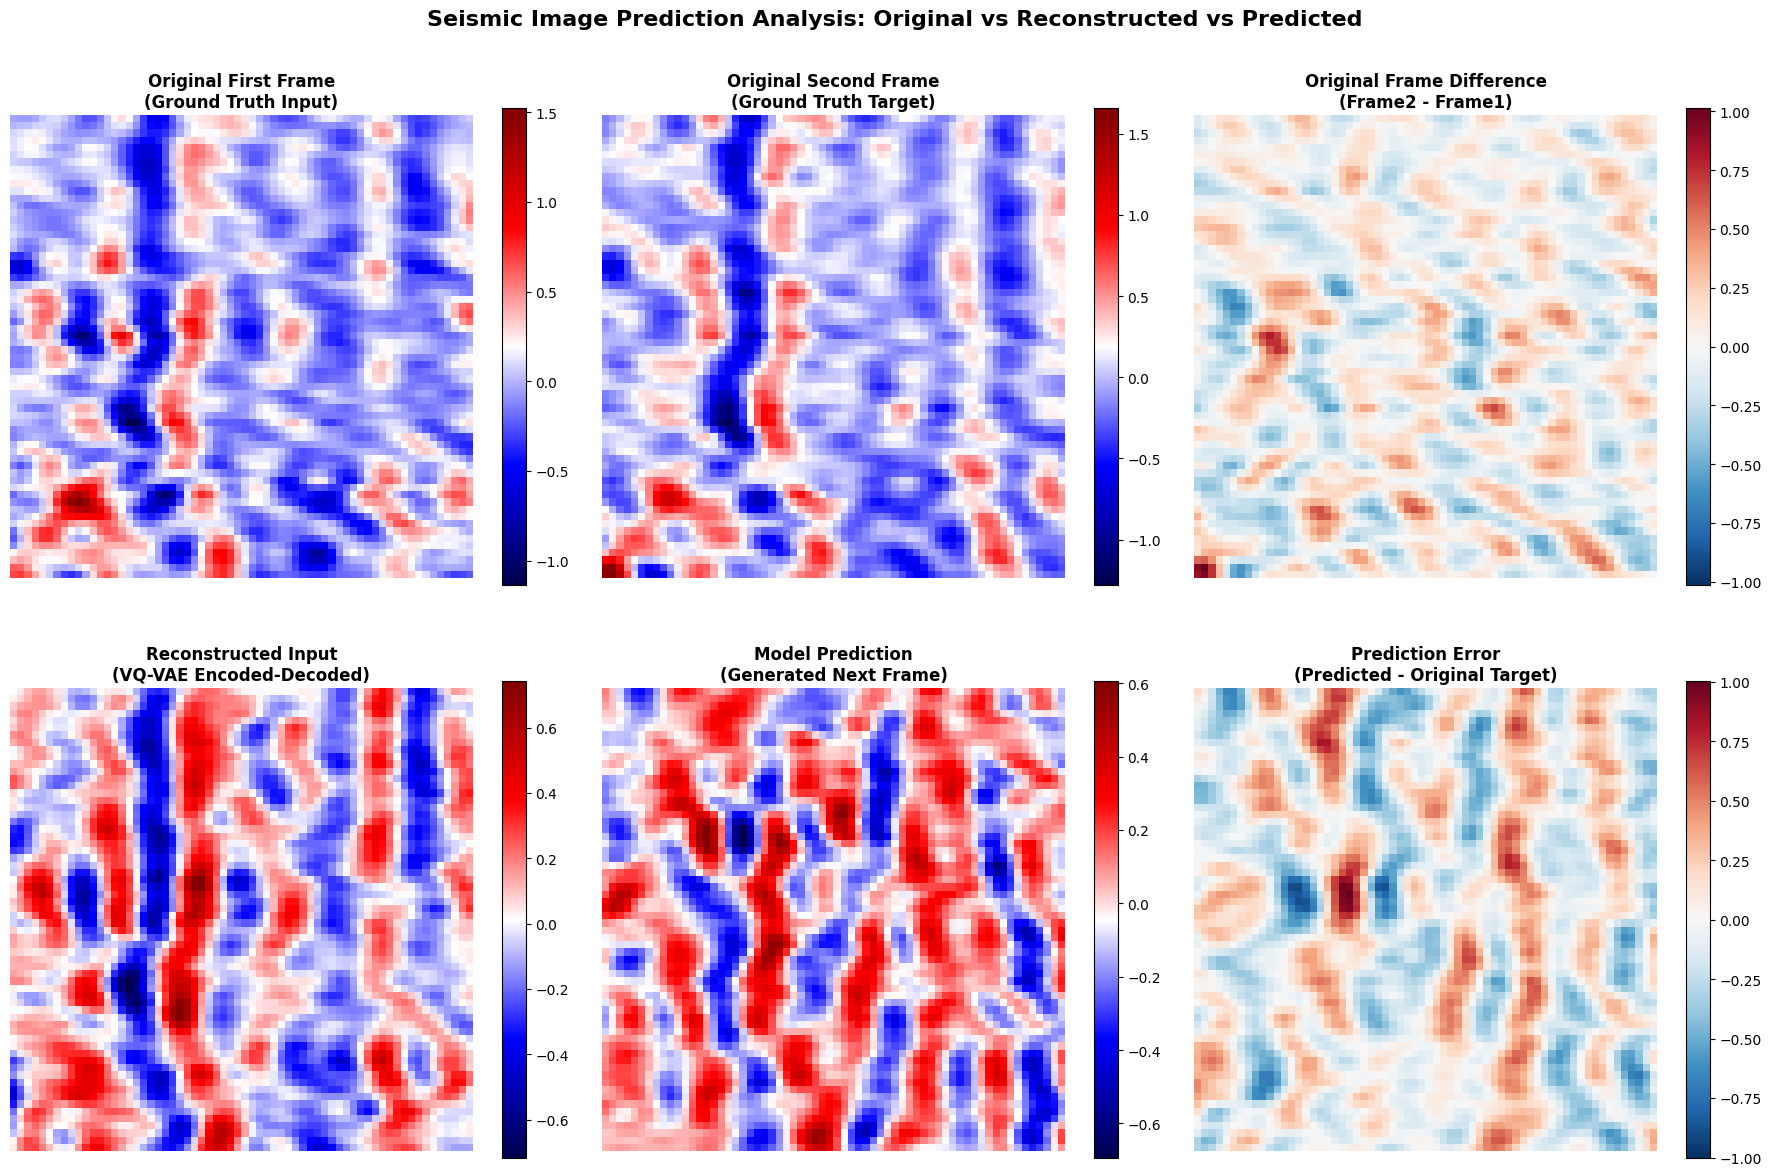

In [ ]:
#@title Generation: Given first frame, predict next frame
SEED = 0 #@param
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)          # 若用单块 GPU

#@title reconstruct image from generated sequence
def reconstruct_images_from_generated_sequence(
    generated_sequence,
    vqvae_model,
    seismic_world_model,
    device,
    return_both_frames=True
):
    """
    将生成的token序列重建为图片

    Args:
        generated_sequence: [1, seq_len] 生成的token序列
        vqvae_model: 训练好的VQ-VAE模型
        seismic_world_model: SeismicWorld模型 (用于获取token偏移量)
        device: 设备
        return_both_frames: 是否返回两帧图片，否则只返回生成的第二帧

    Returns:
        reconstructed_images: 重建的图片 tensor
    """
    vqvae_model.eval()

    with torch.no_grad():
        # 1. 移除 BOS token 和可能的 EOS/PAD tokens
        sequence = generated_sequence.squeeze(0)  # [seq_len]

        # 找到有效的frame tokens (排除特殊tokens)
        frame_mask = (sequence >= seismic_world_model.frame_token_offset) & \
                    (sequence < seismic_world_model.special_token_offset)

        frame_tokens = sequence[frame_mask]
        print(f"Valid frame tokens: {len(frame_tokens)}")

        # 2. 移除token偏移量，恢复原始VQ-VAE indices
        frame_indices = frame_tokens - seismic_world_model.frame_token_offset

        # 3. 根据每帧64个tokens分割序列
        tokens_per_frame = seismic_world_model.num_frame_tokens_per_step  # 64

        if len(frame_indices) < tokens_per_frame:
            print(f"Warning: Not enough tokens for a complete frame. Got {len(frame_indices)}, expected {tokens_per_frame}")
            # 用0填充不足的tokens
            padding_needed = tokens_per_frame - len(frame_indices)
            padding = torch.zeros(padding_needed, dtype=frame_indices.dtype, device=device)
            frame_indices = torch.cat([frame_indices, padding])

        reconstructed_frames = []

        # 4. 处理每一帧
        num_complete_frames = len(frame_indices) // tokens_per_frame
        print(f"Number of complete frames to reconstruct: {num_complete_frames}")

        for frame_idx in range(num_complete_frames):
            start_idx = frame_idx * tokens_per_frame
            end_idx = start_idx + tokens_per_frame

            # 获取当前帧的indices
            current_frame_indices = frame_indices[start_idx:end_idx]

            # 5. 重塑为空间维度 [1, 1, 8, 8] (假设是8x8的spatial tokens)
            spatial_size = int(math.sqrt(tokens_per_frame))  # 8
            current_frame_indices = current_frame_indices.view(1, 1, spatial_size, spatial_size)

            print(f"Frame {frame_idx} indices shape: {current_frame_indices.shape}")

            # 6. 使用VQ-VAE解码
            try:
                reconstructed_frame = vqvae_model.decode_from_indices(
                    current_frame_indices,
                    video_contains_first_frame=True
                )

                print(f"Frame {frame_idx} reconstructed shape: {reconstructed_frame.shape}")
                reconstructed_frames.append(reconstructed_frame)

            except Exception as e:
                print(f"Error reconstructing frame {frame_idx}: {e}")
                # 创建一个零填充的帧作为fallback
                fallback_frame = torch.zeros(1, 1, 64, 64, device=device)
                reconstructed_frames.append(fallback_frame)

        if not reconstructed_frames:
            print("No frames could be reconstructed!")
            return None

        # 7. 组合所有帧
        if return_both_frames and len(reconstructed_frames) >= 2:
            # 返回两帧 [1, 2, 64, 64]
            combined_frames = torch.cat(reconstructed_frames[:2], dim=1)
        elif len(reconstructed_frames) >= 1:
            # 只返回第一帧（或生成的帧）
            combined_frames = reconstructed_frames[-1]  # 取最后生成的帧
        else:
            return None

        return combined_frames

# Generation example: Given first frame, predict next frame
print("=== Frame-to-Frame Generation Example ===")

index_TRAIN = 5 #@param {type:"integer"}
index_Val = 0 #@param {type:"integer"}
suffix = '1999-2006_tuned_训练过程展示_低频信息' #@param


# Method 1: Using a sample from your seismic data
if 'seismic_data_video' in locals() and index_TRAIN != 0:
    # Take the first frame from your seismic data
    sample_first_frame = seismic_data_video[index_TRAIN:index_TRAIN+1, 0:1, :, :]  # [1, 1, 64, 64]
    sample_second_frame = seismic_data_video[index_TRAIN:index_TRAIN+1, 1:2, :, :]  # [1, 1, 64, 64]
    print(f"Using sample from seismic_data_video: {sample_first_frame.shape}")
elif 'seismic_data_video' in locals() and index_Val != 0:
    seismic_data_video_test = filtered_tensor_test # fine-tune
    sample_first_frame = seismic_data_video_test[index_Val:index_Val+1, 0:1, :, :]  # [1, 1, 64, 64]
    sample_second_frame = seismic_data_video_test[index_Val:index_Val+1, 1:2, :, :]  # [1, 1, 64, 64]
else:
    print(f"seismic_data_video DOES NOT EXIST!")

res = generate_with_shift_logic(
    loaded_model=loaded_model,
    vqvae_model=vqvae_model,
    first_frame=sample_first_frame,         # [1,1,64,64]
    second_frame_gt=sample_second_frame,    # 用于相似性判定；若在真正推理未知则可不填
    device=DEVICE,
    similarity_thresholds={'ncc':0.9,'ssim':0.97,'mse':5e-3},
    max_new_tokens=65,
    temperature=0.9,
    top_k=1000
)

print("Mode:", res["mode"])
print("Similarity metrics:", res["similarity_metrics"])
print("Pseudo sequence (for logging) shape:", res["pseudo_input_sequence"].shape)
print("Model input sequence (actual) shape:", res["model_input_sequence"].shape)
print("Generated sequence shape:", res["generated_sequence"].shape)

# 之后你仍可用原本的 reconstruct_images_from_generated_sequence
# 生成的 generated_sequence 格式兼容：
#   BOS + 第一帧(64) + 第二帧(64 or 复制) + EOS
input_length = 1 + 64  # BOS + 第一帧
gen_seq = res["generated_sequence"]

# 重建第一帧（输入）
reconstructed_images_1 = reconstruct_images_from_generated_sequence(
    generated_sequence=gen_seq[:, :input_length],
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)

# 重建模型输出的“下一帧”
reconstructed_images_2 = reconstruct_images_from_generated_sequence(
    generated_sequence=gen_seq[:, input_length:],
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)
with torch.no_grad():
    # 1. 编码第二帧 -> indices: [1,1,8,8]
    second_frame_indices = vqvae_model.encode_to_indices(sample_second_frame.to(DEVICE))
    # 2. 展平 -> [1,64]
    second_frame_tokens = second_frame_indices.view(1, -1)
    # 3. 加 offset
    second_frame_tokens_offset = second_frame_tokens + loaded_model.frame_token_offset
    # 4. 组装 target_sequence: BOS + 第二帧64个token
    bos_token = torch.tensor([[loaded_model.bos_token_id]], device=DEVICE)
    target_sequence = torch.cat([bos_token, second_frame_tokens_offset], dim=1)

reconstructed_images_3 = reconstruct_images_from_generated_sequence(
    generated_sequence=target_sequence,
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True   # 这里即使为 True，也只会返回那一帧（函数内部会走到“只返回最后一帧”逻辑）
)

# 定义图像处理函数
def process_image_for_display(img_tensor):
    """将tensor转换为可显示的numpy数组"""
    if img_tensor.dim() == 4:  # [1, C, H, W]
        return img_tensor.squeeze(0).squeeze(0).cpu().numpy()
    elif img_tensor.dim() == 5:  # [1, C, T, H, W]
        return img_tensor.squeeze(0).squeeze(0).squeeze(0).cpu().numpy()
    else:
        return img_tensor.cpu().numpy()

save = False #@param {type:"boolean"}

if (reconstructed_images_1 is not None and
    reconstructed_images_2 is not None and
    reconstructed_images_3 is not None):

    print(f"Input image shape: {reconstructed_images_1.shape}")
    print(f"Prediction image shape: {reconstructed_images_2.shape}")
    print(f"Target image shape: {reconstructed_images_3.shape}")

    # 处理图像
    img_input = process_image_for_display(reconstructed_images_1)      # 输入
    img_prediction = process_image_for_display(reconstructed_images_2) # 预测
    img_target = process_image_for_display(reconstructed_images_3)     # 标签
    img_diff = img_prediction - img_target                             # 预测与标签的差异

    # 处理原图
    img_original_first = process_image_for_display(sample_first_frame)   # 原始第一帧
    img_original_second = process_image_for_display(sample_second_frame) # 原始第二帧
    img_original_diff = img_original_second - img_original_first         # 原图差值

    # 创建2x3的子图布局
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 第一行：原图对比
    # 子图1：原始第一帧
    im1 = axes[0,0].imshow(img_original_first, cmap='seismic')
    axes[0,0].set_title('Original First Frame\n(Ground Truth Input)', fontsize=12, fontweight='bold')
    axes[0,0].axis('off')
    plt.colorbar(im1, ax=axes[0,0], shrink=0.8)

    # 子图2：原始第二帧
    im2 = axes[0,1].imshow(img_original_second, cmap='seismic')
    axes[0,1].set_title('Original Second Frame\n(Ground Truth Target)', fontsize=12, fontweight='bold')
    axes[0,1].axis('off')
    plt.colorbar(im2, ax=axes[0,1], shrink=0.8)

    # 子图3：原图差值
    original_diff_max = np.abs(img_original_diff).max()
    im3 = axes[0,2].imshow(img_original_diff, cmap='RdBu_r', vmin=-original_diff_max, vmax=original_diff_max)
    axes[0,2].set_title('Original Frame Difference\n(Frame2 - Frame1)', fontsize=12, fontweight='bold')
    axes[0,2].axis('off')
    plt.colorbar(im3, ax=axes[0,2], shrink=0.8)

    # 第二行：重建图对比
    # 子图4：重建输入图像
    im4 = axes[1,0].imshow(img_input, cmap='seismic')
    axes[1,0].set_title('Reconstructed Input\n(VQ-VAE Encoded-Decoded)', fontsize=12, fontweight='bold')
    axes[1,0].axis('off')
    plt.colorbar(im4, ax=axes[1,0], shrink=0.8)

    # 子图5：预测图像
    im5 = axes[1,1].imshow(img_prediction, cmap='seismic')
    axes[1,1].set_title('Model Prediction\n(Generated Next Frame)', fontsize=12, fontweight='bold')
    axes[1,1].axis('off')
    plt.colorbar(im5, ax=axes[1,1], shrink=0.8)

    # 子图6：预测误差
    pred_diff_max = np.abs(img_diff).max()
    im6 = axes[1,2].imshow(img_diff, cmap='RdBu_r', vmin=-pred_diff_max, vmax=pred_diff_max)
    axes[1,2].set_title('Prediction Error\n(Predicted - Original Target)', fontsize=12, fontweight='bold')
    axes[1,2].axis('off')
    plt.colorbar(im6, ax=axes[1,2], shrink=0.8)

    # 调整子图间距
    plt.tight_layout()

    # 添加总标题
    fig.suptitle('Seismic Image Prediction Analysis: Original vs Reconstructed vs Predicted',
                 fontsize=16, fontweight='bold', y=1.02)

    # 显示详细统计信息
    print("="*80)
    print("COMPREHENSIVE PREDICTION ANALYSIS STATISTICS")
    print("="*80)

    print(f"Original First Frame Stats:")
    print(f"  Shape: {img_original_first.shape}")
    print(f"  Range: [{img_original_first.min():.4f}, {img_original_first.max():.4f}]")
    print(f"  Mean: {img_original_first.mean():.4f}, Std: {img_original_first.std():.4f}")

    print(f"\nOriginal Second Frame Stats:")
    print(f"  Shape: {img_original_second.shape}")
    print(f"  Range: [{img_original_second.min():.4f}, {img_original_second.max():.4f}]")
    print(f"  Mean: {img_original_second.mean():.4f}, Std: {img_original_second.std():.4f}")

    print(f"\nReconstructed Input Image Stats:")
    print(f"  Shape: {img_input.shape}")
    print(f"  Range: [{img_input.min():.4f}, {img_input.max():.4f}]")
    print(f"  Mean: {img_input.mean():.4f}, Std: {img_input.std():.4f}")

    print(f"\nPredicted Image Stats:")
    print(f"  Shape: {img_prediction.shape}")
    print(f"  Range: [{img_prediction.min():.4f}, {img_prediction.max():.4f}]")
    print(f"  Mean: {img_prediction.mean():.4f}, Std: {img_prediction.std():.4f}")

    print(f"\nOriginal Frame Difference Stats:")
    print(f"  Range: [{img_original_diff.min():.4f}, {img_original_diff.max():.4f}]")
    print(f"  Mean: {img_original_diff.mean():.4f}, Std: {img_original_diff.std():.4f}")
    print(f"  Mean Absolute Difference: {np.abs(img_original_diff).mean():.4f}")

    print(f"\nPrediction Error Stats (vs Original Target):")
    print(f"  Range: [{img_diff.min():.4f}, {img_diff.max():.4f}]")
    print(f"  Mean: {img_diff.mean():.4f}, Std: {img_diff.std():.4f}")
    print(f"  Mean Absolute Error (MAE): {np.abs(img_diff).mean():.4f}")
    print(f"  Root Mean Square Error (RMSE): {np.sqrt(np.mean(img_diff**2)):.4f}")

    # VQ-VAE重建质量评估
    input_reconstruction_error = img_input - img_original_first
    print(f"\nVQ-VAE Reconstruction Quality (Input):")
    print(f"  Reconstruction MAE: {np.abs(input_reconstruction_error).mean():.4f}")
    print(f"  Reconstruction RMSE: {np.sqrt(np.mean(input_reconstruction_error**2)):.4f}")

    # 相似性指标
    correlation_pred_orig = np.corrcoef(img_prediction.flatten(), img_original_second.flatten())[0,1]
    correlation_pred_target = np.corrcoef(img_prediction.flatten(), img_target.flatten())[0,1]
    correlation_orig_frames = np.corrcoef(img_original_first.flatten(), img_original_second.flatten())[0,1]

    print(f"\nCorrelation Analysis:")
    print(f"  Prediction vs Original Target: {correlation_pred_orig:.4f}")
    print(f"  Prediction vs Reconstructed Target: {correlation_pred_target:.4f}")
    print(f"  Original Frame1 vs Frame2: {correlation_orig_frames:.4f}")

    # 结构相似性指标 (简化版)
    def simple_ssim(img1, img2):
        mu1, mu2 = img1.mean(), img2.mean()
        sigma1, sigma2 = img1.std(), img2.std()
        sigma12 = np.mean((img1 - mu1) * (img2 - mu2))

        c1, c2 = 0.01**2, 0.03**2
        ssim = ((2*mu1*mu2 + c1) * (2*sigma12 + c2)) / ((mu1**2 + mu2**2 + c1) * (sigma1**2 + sigma2**2 + c2))
        return ssim

    ssim_pred_orig = simple_ssim(img_prediction, img_original_second)
    ssim_input_orig = simple_ssim(img_input, img_original_first)

    print(f"\nStructural Similarity (SSIM):")
    print(f"  Prediction vs Original Target: {ssim_pred_orig:.4f}")
    print(f"  VQ-VAE Input Reconstruction: {ssim_input_orig:.4f}")

    print("="*80)

    if save:
      # 保存图片为PDF格式
      plt.savefig(f_path+f'/SW地震预测展示图{index_Val}_{suffix}.pdf',
                  format='pdf',           # 指定PDF格式
                  dpi=300,               # 设置分辨率
                  bbox_inches='tight',   # 紧凑布局，去除多余空白
                  facecolor='white',     # 背景色为白色
                  edgecolor='none',      # 无边框
                  transparent=False)     # 非透明背景
      print(f'已经成功保存到{f_path}/SW地震预测展示图{index_Val}_{suffix}.pdf')
    plt.show()

else:
    print("Error: One or more reconstructed images is None")
    if reconstructed_images_1 is None:
        print("- Input image reconstruction failed")
    if reconstructed_images_2 is None:
        print("- Prediction image reconstruction failed")
    if reconstructed_images_3 is None:
        print("- Target image reconstruction failed")


In [ ]:
#@title finetune test
import torch
from collections import defaultdict
from tqdm import tqdm
import math

# 假设已存在:
# seismic_data_video: torch.Size([N, 2, 64, 64])
# loaded_model: 你的 SeismicWorld / autoregressive 模型
# vqvae_model: 已训练 VQ-VAE
# DEVICE: 设备 (torch.device)
# generate_with_shift_logic(...)
# reconstruct_images_from_generated_sequence(...)

def predict_next_frames_from_dataset(
    seismic_data_video: torch.Tensor,
    loaded_model,
    vqvae_model,
    device,
    use_gt_for_similarity=True,
    similarity_thresholds=None,
    temperature=0.9,
    top_k=1000,
    max_new_tokens=65,
    verbose_every=0
):
    """
    对数据集中每个 (first_frame, second_frame_gt) 样本进行预测，返回拼接后的预测视频张量。
    参数:
      seismic_data_video: [N, 2, 64, 64]
      use_gt_for_similarity: 若 True，把第二帧GT传入给 generate_with_shift_logic 用于模式判定
      similarity_thresholds: dict, 传给 generate_with_shift_logic
    返回:
      predicted_video: [N, 2, 64, 64]  (第一帧原样 + 预测第二帧)
      pred_second_frames: [N, 1, 64, 64]
      modes_count: dict 统计不同生成模式
      metrics_list: list[dict] 逐样本指标 (若 use_gt_for_similarity=False 则为空)
    """
    loaded_model.eval()
    vqvae_model.eval()

    N = seismic_data_video.shape[0]
    pred_frames_list = []
    modes_count = defaultdict(int)
    metrics_list = []

    for i in tqdm(range(N), desc="Predicting next frames"):
        # 取第一帧 & GT 第二帧
        first_frame = seismic_data_video[i:i+1, 0:1].to(device)   # [1,1,64,64]
        second_frame_gt = seismic_data_video[i:i+1, 1:2].to(device) if use_gt_for_similarity else None

        # 生成 token 序列
        with torch.no_grad():
            res = generate_with_shift_logic(
                loaded_model=loaded_model,
                vqvae_model=vqvae_model,
                first_frame=first_frame,
                second_frame_gt=second_frame_gt,
                device=device,
                similarity_thresholds=similarity_thresholds or {'ncc':0.7,'ssim':0.97,'mse':5e-3},
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                top_k=top_k,
                force_mode='change'
            )

        mode = res.get("mode", "unknown")
        modes_count[mode] += 1

        # 拿到完整生成序列
        gen_seq = res["generated_sequence"]  # [1, seq_len]
        # 计算第一帧 token 长度：BOS(1) + 64 = 65
        tokens_per_frame = loaded_model.num_frame_tokens_per_step  # 64
        input_length = 1 + tokens_per_frame

        # 重建预测的下一帧 (只传入后半段序列)
        try:
            reconstructed_pred = reconstruct_images_from_generated_sequence(
                generated_sequence=gen_seq[:, input_length:],
                vqvae_model=vqvae_model,
                seismic_world_model=loaded_model,
                device=device,
                return_both_frames=False  # 只要预测帧
            )
            # 返回可能是 [1,1,64,64]
            if reconstructed_pred is None:
                # fallback
                reconstructed_pred = torch.zeros(1, 1, 64, 64, device=device)
        except Exception as e:
            print(f"[Index {i}] Reconstruction error: {e}")
            reconstructed_pred = torch.zeros(1, 1, 64, 64, device=device)

        pred_frames_list.append(reconstructed_pred.detach().cpu())  # 放到 CPU

        # 保存指标
        if use_gt_for_similarity:
            metrics_list.append({
                'index': i,
                **res.get("similarity_metrics", {})
            })

        if verbose_every and (i % verbose_every == 0):
            print(f"[{i}] mode={mode}, pred_frame_shape={reconstructed_pred.shape}")

    # 拼接所有预测的第二帧
    pred_second_frames = torch.cat(pred_frames_list, dim=0)  # [N,1,64,64]

    # 组合成与原始同形状的视频 (第一帧原样 + 预测)
    first_frames_all = seismic_data_video[:, 0:1]            # [N,1,64,64] (CPU 假设)
    predicted_video = torch.cat([first_frames_all, pred_second_frames], dim=1)  # [N,2,64,64]

    return {
        'predicted_video': predicted_video,          # [N,2,64,64]
        'pred_second_frames': pred_second_frames,    # [N,1,64,64]
        'modes_count': dict(modes_count),
        'metrics_list': metrics_list
    }

# ================= 使用示例 =================
# seismic_data_video: torch.Size([32,2,64,64])
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 把数据放到 CPU 留用（函数内部逐样本 to(device)）
# 你也可以先 .to(DEVICE)，只要索引后再转即可。

result = predict_next_frames_from_dataset(
    seismic_data_video=seismic_data_video,   # [32,2,64,64]
    loaded_model=loaded_model,
    vqvae_model=vqvae_model,
    device=DEVICE,
    use_gt_for_similarity=True,
    similarity_thresholds={'ncc':0.00,'ssim':0.00,'mse':1e-1},
    temperature=0.9,
    top_k=1000,
    max_new_tokens=65,
    verbose_every=0
)

predicted_video = result['predicted_video']         # [32,2,64,64]
pred_second_frames = result['pred_second_frames']   # [32,1,64,64]
modes_count = result['modes_count']
metrics_list = result['metrics_list']

print("predicted_video shape:", predicted_video.shape)
print("Mode counts:", modes_count)
if metrics_list:
    # 简单统计平均指标
    avg_metrics = {}
    for m in metrics_list:
        for k,v in m.items():
            if k == 'index': continue
            avg_metrics.setdefault(k, []).append(float(v))
    avg_metrics = {k: sum(v)/len(v) for k,v in avg_metrics.items()}
    print("Average similarity metrics:", avg_metrics)


Predicting next frames:   2%|▎         | 3/120 [00:00<00:05, 21.67it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:   8%|▊         | 9/120 [00:00<00:05, 21.30it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  10%|█         | 12/120 [00:00<00:05, 21.26it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  15%|█▌        | 18/120 [00:00<00:04, 21.20it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  18%|█▊        | 21/120 [00:00<00:04, 20.81it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames:  22%|██▎       | 27/120 [00:01<00:04, 20.87it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  25%|██▌       | 30/120 [00:01<00:04, 20.93it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames:  30%|███       | 36/120 [00:01<00:03, 21.00it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  35%|███▌      | 42/120 [00:01<00:03, 20.89it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  38%|███▊      | 45/120 [00:02<00:03, 20.87it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames:  42%|████▎     | 51/120 [00:02<00:03, 20.95it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  45%|████▌     | 54/120 [00:02<00:03, 20.95it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames:  50%|█████     | 60/120 [00:02<00:02, 20.82it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  52%|█████▎    | 63/120 [00:03<00:02, 20.80it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames:  57%|█████▊    | 69/120 [00:03<00:02, 20.70it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  60%|██████    | 72/120 [00:03<00:02, 20.80it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames:  65%|██████▌   | 78/120 [00:03<00:02, 20.96it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  68%|██████▊   | 81/120 [00:03<00:01, 20.91it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames:  72%|███████▎  | 87/120 [00:04<00:01, 20.83it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  75%|███████▌  | 90/120 [00:04<00:01, 20.82it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames:  80%|████████  | 96/120 [00:04<00:01, 20.90it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  82%|████████▎ | 99/120 [00:04<00:01, 20.78it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames:  88%|████████▊ | 105/120 [00:05<00:00, 20.78it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  90%|█████████ | 108/120 [00:05<00:00, 20.64it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames:  95%|█████████▌| 114/120 [00:05<00:00, 20.73it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quant

Predicting next frames:  98%|█████████▊| 117/120 [00:05<00:00, 20.84it/s]

Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])


Predicting next frames: 100%|██████████| 120/120 [00:05<00:00, 20.88it/s]

Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
predicted_video shape: torch.Size([120, 2, 64, 64])
Mode counts: {'change': 120}
Average similarity metrics: {'NCC': 0.5603634595870972, 'MSE': 0.04229110132728238, 'SSIM': 0.4683892604274054}


In [ ]:
# result_B = workflow_middle_xy_slice_2dpatch(pred_second_frames, data_2008_2008, data_2010_2010)
result_B = workflow_middle_yz_slice_2dpatch(pred_second_frames, data_2008_2008, data_2010_2010)



[YZ] 2D patches: n_y=8, n_z=15, N=120, patch_shape=torch.Size([2, 64, 64])
[YZ] 单通道预测已合并到 second 通道 (index=1).
[YZ] recovered shape=torch.Size([2, 512, 960]), MSE=2.393241e-02, MAE=7.753408e-02, merge_info=single_channel_prediction_merged_into_second


In [ ]:
#@title 保存 result_B 到磁盘
import os
import torch

# 确保目录存在
save_dir = os.path.join(f_path, 'dataset')
os.makedirs(save_dir, exist_ok=True)

# 保存 result_B
save_path = os.path.join(save_dir, 'result_B_yz.pt')
torch.save(result_B, save_path)

print(f"✓ Saved result_B to: {save_path}")
print(f"  File size: {os.path.getsize(save_path) / (1024**2):.2f} MB")

In [ ]:
#@title 加载 result_B
import torch
import os

load_path = os.path.join(f_path, 'dataset', 'result_B_yz.pt')
result_B = torch.load(load_path)

print(f"✓ Loaded result_B from: {load_path}")
print(f"  Keys: {list(result_B.keys())}")


In [ ]:
result_B[f'recovered_middle_{axis}'].shape

KeyError: 'recovered_middle_xz'

In [ ]:
#@title 2010预测 vs 历史年份对比（优化美观版）yz
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import zoom

axis = 'yz'  # 可改为 'xy' 或 'xz'

# ==================== 真实数据参数（从SEGY文件头提取）====================
dt_ms = 2.0  # 采样间隔：2000 μs = 2 ms
t0_ms = 0    # 起始时间
t_max_ms = 1001 * dt_ms  # 总时长：2002 ms

# Inline/Crossline 编号范围
inline_range_high = (1720, 1988)   # 2008/2010
xline_range_high = (898, 1458)      # 2008/2010
inline_range_low = (1716, 1964)     # 1994/2001/2004/2006
xline_range_low = (956, 1423)       # 1994/2001/2004/2006

# ==================== 步骤1: 准备低分辨率历史数据 ====================
low_res_shape = (249, 468, 1001)
high_res_shape = (269, 561, 1001)

historical_data_low = {
    1994: data_1994_2007,
    2001: data_2001_2007,
    2004: data_2004_2007,
    2006: data_2006_2007,
}

print("=" * 70)
print("处理低分辨率历史数据对比（优化美观版）")
print("=" * 70)

# ==================== 步骤2: 获取高分辨率2010预测的切面 ====================
if axis == 'yz':
    result_high = workflow_middle_yz_slice_2dpatch(
        pred_second_frames,
        data_2008_2008,
        data_2010_2010,
        patch_size=64,
        verbose=False
    )
elif axis == 'xz':
    result_high = workflow_middle_xz_slice_2dpatch(
        pred_second_frames,
        data_2008_2008,
        data_2010_2010,
        patch_size=64,
        verbose=False
    )
else:  # 'xy'
    result_high = workflow_middle_xy_slice_2dpatch(
        pred_second_frames,
        data_2008_2008,
        data_2010_2010,
        patch_size=64,
        verbose=False
    )

pred_2010_high = result_high[f'recovered_middle_{axis}'][1].detach().cpu().numpy()
real_2010_high = result_high[f'original_middle_{axis}_cropped'][1].detach().cpu().numpy()

# ==================== 步骤3: 对每个历史年份处理 ====================
years = sorted(historical_data_low.keys())
real_data = {}
pred_2010_downsampled = {}
real_2010_downsampled = {}
diffs_pred_hist = {}
diffs_2010_hist = {}

for year, data_volume in historical_data_low.items():
    if axis == 'yz':
        result_low = workflow_middle_yz_slice_2dpatch(
            None, data_volume, data_volume, patch_size=64, verbose=False
        )
    elif axis == 'xz':
        result_low = workflow_middle_xz_slice_2dpatch(
            None, data_volume, data_volume, patch_size=64, verbose=False
        )
    else:
        result_low = workflow_middle_xy_slice_2dpatch(
            None, data_volume, data_volume, patch_size=64, verbose=False
        )

    real_slice = result_low[f'original_middle_{axis}_cropped'][0].detach().cpu().numpy()
    real_data[year] = real_slice

    zoom_factors = tuple(s / h for s, h in zip(real_slice.shape, pred_2010_high.shape))
    pred_2010_downsampled[year] = zoom(pred_2010_high, zoom_factors, order=1)
    real_2010_downsampled[year] = zoom(real_2010_high, zoom_factors, order=1)

    diffs_pred_hist[year] = pred_2010_downsampled[year] - real_slice
    diffs_2010_hist[year] = real_2010_downsampled[year] - real_slice

# ==================== 步骤4: 统计函数 ====================
def mse(a,b):
    return float(np.mean((a-b)**2))

def cc(a,b):
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = np.sqrt((a0**2).sum() * (b0**2).sum()) + 1e-12
    return float((a0*b0).sum()/denom)

def snr(reference, test):
    num = np.sum(reference**2)
    den = np.sum((reference - test)**2) + 1e-12
    return 10.0 * np.log10(num/den)

try:
    from skimage.metrics import structural_similarity as ssim_func
    def ssim(a,b):
        dr = float(np.max(a)-np.min(a) + 1e-12)
        return float(ssim_func(a, b, data_range=dr))
    has_ssim = True
except:
    def ssim(a,b):
        return np.nan
    has_ssim = False

def robust_clip_multi(arrays, q=0.995):
    concat_abs = np.concatenate([np.abs(a).ravel() for a in arrays])
    hi = np.quantile(concat_abs, q)
    return [np.clip(a, -hi, hi) for a in arrays], hi

# ==================== 步骤5: 轴向标签格式化 ====================
def format_time_axis(ax, data_shape, n_ticks=5):
    """横轴：时间 (ms)"""
    W = data_shape[1]
    ticks = np.linspace(0, W-1, n_ticks, dtype=int)
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{int(t0_ms + t*dt_ms)}" for t in ticks], fontsize=9)
    ax.set_xlabel("Time (ms)", fontsize=11, fontweight='bold', labelpad=8)

def format_crossline_axis(ax, data_shape, year, n_ticks=5):
    """纵轴：Crossline编号"""
    H = data_shape[0]
    xline_start, xline_end = xline_range_low if year < 2008 else xline_range_high

    ticks = np.linspace(0, H-1, n_ticks, dtype=int)
    ax.set_yticks(ticks)
    xline_labels = [int(xline_start + t * (xline_end - xline_start) / (H-1)) for t in ticks]
    ax.set_yticklabels(xline_labels, fontsize=9)
    ax.set_ylabel("Crossline", fontsize=11, fontweight='bold', labelpad=8)

# ==================== 步骤6: 绘制每个年份的对比图 ====================
matplotlib.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 10,
    'font.family': 'sans-serif',
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
})

for year in years:
    print(f"\n绘制 {year} 年对比图...")

    real_hist_np = real_data[year]
    pred_2010_np = pred_2010_downsampled[year]
    real_2010_np = real_2010_downsampled[year]
    diff_pred_hist = diffs_pred_hist[year]
    diff_2010_hist = diffs_2010_hist[year]

    # 鲁棒裁剪
    (real_hist_c, pred_2010_c, real_2010_c), hi_main = robust_clip_multi(
        [real_hist_np, pred_2010_np, real_2010_np], q=0.995
    )
    vmax, vmin = hi_main, -hi_main

    (diff_pred_c, diff_2010_c), hi_diff = robust_clip_multi(
        [diff_pred_hist, diff_2010_hist], q=0.99
    )
    dvmax, dvmin = hi_diff, -hi_diff

    # 统计指标
    stats = {
        "CC": cc(pred_2010_np, real_hist_np),
        "MSE": mse(pred_2010_np, real_hist_np),
        "SNR": snr(real_hist_np, pred_2010_np),
        "SSIM": ssim(pred_2010_np, real_hist_np),
    }

    # 创建图形 - 调整布局留出更多空间
    fig = plt.figure(figsize=(22, 7))
    gs = GridSpec(2, 10, figure=fig,
                  height_ratios=[20, 1],
                  width_ratios=[4, 4, 4, 4, 0.2, 0.2, 0.2, 0.2, 0.2, 3],
                  hspace=0.25, wspace=0.35,
                  left=0.05, right=0.98, top=0.93, bottom=0.12)

    axes = []
    titles = [
        f"(a) Real {year}",
        f"(b) Pred 2010",
        f"(c) Pred2010 - Real{year}",
        f"(d) Real2010 - Real{year}"
    ]

    # 创建4个主图
    for i in range(4):
        ax = fig.add_subplot(gs[0, i])
        axes.append(ax)

    # 绘制图像
    im0 = axes[0].imshow(real_hist_c, cmap='seismic', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bilinear')
    axes[0].set_title(titles[0], fontsize=13, fontweight='bold', pad=12)

    im1 = axes[1].imshow(pred_2010_c, cmap='seismic', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bilinear')
    axes[1].set_title(titles[1], fontsize=13, fontweight='bold', pad=12)

    im2 = axes[2].imshow(diff_pred_c, cmap='coolwarm', vmin=dvmin, vmax=dvmax, aspect='auto', interpolation='bilinear')
    axes[2].set_title(titles[2], fontsize=13, fontweight='bold', pad=12)

    im3 = axes[3].imshow(diff_2010_c, cmap='coolwarm', vmin=dvmin, vmax=dvmax, aspect='auto', interpolation='bilinear')
    axes[3].set_title(titles[3], fontsize=13, fontweight='bold', pad=12)

    # 应用轴标签和格式化
    for i in range(4):
        format_time_axis(axes[i], real_hist_np.shape)
        if i == 0:  # 只在第一个子图显示y轴标签
            format_crossline_axis(axes[i], real_hist_np.shape, year)
        else:
            axes[i].set_yticks([])  # 其他子图隐藏y轴刻度

        # 美化边框
        for spine in axes[i].spines.values():
            spine.set_linewidth(1.2)
            spine.set_edgecolor('#333333')

    # 统计信息文本框 - 放在右侧独立区域
    stat_ax = fig.add_subplot(gs[0, 9])
    stat_ax.axis('off')

    stat_text = (
        f"Comparison Year: {year}\n\n"
        f"{'─'*25}\n"
        f"Data Info:\n"
        f"  Shape: {real_hist_np.shape[0]}×{real_hist_np.shape[1]}\n"
        f"  Sampling: {dt_ms} ms\n"
        f"  Duration: {t0_ms}-{int(t_max_ms)} ms\n\n"
        f"{'─'*25}\n"
        f"Metrics (Pred vs Real{year}):\n\n"
        f"  Correlation:  {stats['CC']:>6.3f}\n"
        f"  MSE:          {stats['MSE']:.2e}\n"
        f"  SNR:          {stats['SNR']:>6.2f} dB\n"
    )
    if has_ssim:
        stat_text += f"  SSIM:         {stats['SSIM']:>6.3f}\n"

    stat_text += (
        f"\n{'─'*25}\n"
        f"Max Residuals:\n\n"
        f"  |Pred-Real{year}|:\n"
        f"    {np.max(np.abs(diff_pred_hist)):.2e}\n\n"
        f"  |Real2010-Real{year}|:\n"
        f"    {np.max(np.abs(diff_2010_hist)):.2e}\n"
    )

    stat_ax.text(0.05, 0.98, stat_text,
                transform=stat_ax.transAxes,
                fontsize=9.5,
                va='top', ha='left',
                family='monospace',
                bbox=dict(facecolor='#f9f9f9', alpha=0.95,
                          edgecolor='#666666', boxstyle='round,pad=0.8',
                          linewidth=1.5))

    # Colorbar - 振幅
    cax_main = fig.add_subplot(gs[1, 0:2])
    cbar_main = fig.colorbar(im0, cax=cax_main, orientation='horizontal')
    cbar_main.set_label("Amplitude (clipped @ 99.5%)",
                        fontsize=11, fontweight='bold', labelpad=8)
    cbar_main.ax.tick_params(labelsize=9)

    # Colorbar - 差值
    cax_diff = fig.add_subplot(gs[1, 2:4])
    cbar_diff = fig.colorbar(im2, cax=cax_diff, orientation='horizontal')
    cbar_diff.set_label("Residual Amplitude (clipped @ 99%)",
                        fontsize=11, fontweight='bold', labelpad=8)
    cbar_diff.ax.tick_params(labelsize=9)

    # 保存
    out_path = f_path + f'/pred2010_vs_{year}_middle_{axis}_beautiful.pdf'
    fig.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✓ Saved -> {out_path}")

    plt.show()
    plt.close()

# ==================== 步骤7: 汇总统计 ====================
print("\n" + "="*70)
print("Summary Statistics: Pred(2010) vs Real(Historical Years)")
print(f"Sampling: {dt_ms} ms | Duration: {t0_ms}-{int(t_max_ms)} ms")
print("="*70)
print(f"{'Year':<8} {'MSE':<12} {'CC':<12} {'SNR (dB)':<12} {'SSIM':<12}")
print("-"*70)
for year in years:
    pred = pred_2010_downsampled[year]
    real = real_data[year]
    print(f"{year:<8} {mse(pred, real):<12.2e} {cc(pred, real):<12.3f} "
          f"{snr(real, pred):<12.2f} {ssim(pred, real) if has_ssim else 'N/A':<12}")
print("="*70)

处理低分辨率历史数据对比（优化美观版）


ValueError: predicted_patches 空间或数量维度不匹配，期待 N=120, ps=64, 收到 torch.Size([60, 1, 64, 64])

In [ ]:
#@title 2010预测 vs 历史年份对比（XZ切面：Inline × Time）
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import zoom

axis = 'xz'  # XZ切面：垂直于Crossline方向

# ==================== 真实数据参数（从SEGY文件头提取）====================
dt_ms = 2.0  # 采样间隔：2000 μs = 2 ms
t0_ms = 0    # 起始时间
t_max_ms = 1001 * dt_ms  # 总时长：2002 ms

# Inline/Crossline 编号范围
inline_range_high = (1720, 1988)   # 2008/2010: 269条
xline_range_high = (898, 1458)      # 2008/2010: 561条
inline_range_low = (1716, 1964)     # 1994/2001/2004/2006: 249条
xline_range_low = (956, 1423)       # 1994/2001/2004/2006: 468条

# ==================== 步骤1: 准备低分辨率历史数据 ====================
low_res_shape = (249, 468, 1001)   # (Inline, Crossline, Time)
high_res_shape = (269, 561, 1001)

historical_data_low = {
    1994: data_1994_2007,
    2001: data_2001_2007,
    2004: data_2004_2007,
    2006: data_2006_2007,
}

print("=" * 70)
print("XZ切面对比：Inline × Time（垂直于Crossline方向）")
print("=" * 70)

# ==================== 步骤2: 获取高分辨率2010预测的XZ切面 ====================
result_high = workflow_middle_xz_slice_2dpatch(
    pred_second_frames,
    data_2008_2008,
    data_2010_2010,
    patch_size=64,
    verbose=False
)

pred_2010_high = result_high[f'recovered_middle_{axis}'][1].detach().cpu().numpy()
real_2010_high = result_high[f'original_middle_{axis}_cropped'][1].detach().cpu().numpy()
print(f"高分辨率2010预测XZ切面形状: {pred_2010_high.shape}")
print(f"  → 物理含义: (Inline数, Time采样点数)")

# ==================== 步骤3: 对每个历史年份处理 ====================
years = sorted(historical_data_low.keys())
real_data = {}
pred_2010_downsampled = {}
real_2010_downsampled = {}
diffs_pred_hist = {}
diffs_2010_hist = {}

for year, data_volume in historical_data_low.items():
    print(f"\n处理 {year} 年...")

    result_low = workflow_middle_xz_slice_2dpatch(
        None,
        data_volume,
        data_volume,
        patch_size=64,
        verbose=False
    )

    real_slice = result_low[f'original_middle_{axis}_cropped'][0].detach().cpu().numpy()
    real_data[year] = real_slice
    print(f"  真实{year} XZ切面形状: {real_slice.shape}")

    zoom_factors = tuple(s / h for s, h in zip(real_slice.shape, pred_2010_high.shape))
    pred_2010_downsampled[year] = zoom(pred_2010_high, zoom_factors, order=1)
    real_2010_downsampled[year] = zoom(real_2010_high, zoom_factors, order=1)

    diffs_pred_hist[year] = pred_2010_downsampled[year] - real_slice
    diffs_2010_hist[year] = real_2010_downsampled[year] - real_slice

# ==================== 步骤4: 统计函数 ====================
def mse(a,b):
    return float(np.mean((a-b)**2))

def cc(a,b):
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = np.sqrt((a0**2).sum() * (b0**2).sum()) + 1e-12
    return float((a0*b0).sum()/denom)

def snr(reference, test):
    num = np.sum(reference**2)
    den = np.sum((reference - test)**2) + 1e-12
    return 10.0 * np.log10(num/den)

try:
    from skimage.metrics import structural_similarity as ssim_func
    def ssim(a,b):
        dr = float(np.max(a)-np.min(a) + 1e-12)
        return float(ssim_func(a, b, data_range=dr))
    has_ssim = True
except:
    def ssim(a,b):
        return np.nan
    has_ssim = False

def robust_clip_multi(arrays, q=0.995):
    concat_abs = np.concatenate([np.abs(a).ravel() for a in arrays])
    hi = np.quantile(concat_abs, q)
    return [np.clip(a, -hi, hi) for a in arrays], hi

# ==================== 步骤5: XZ切面轴向标签格式化 ====================
def format_time_axis_xz(ax, data_shape, n_ticks=5):
    """横轴：时间 (ms) - XZ切面"""
    W = data_shape[1]  # 时间采样点数
    ticks = np.linspace(0, W-1, n_ticks, dtype=int)
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{int(t0_ms + t*dt_ms)}" for t in ticks], fontsize=9)
    ax.set_xlabel("Time (ms)", fontsize=11, fontweight='bold', labelpad=8)

def format_inline_axis_xz(ax, data_shape, year, n_ticks=5):
    """纵轴：Inline编号 - XZ切面"""
    H = data_shape[0]  # Inline数量
    inline_start, inline_end = inline_range_low if year < 2008 else inline_range_high

    ticks = np.linspace(0, H-1, n_ticks, dtype=int)
    ax.set_yticks(ticks)
    inline_labels = [int(inline_start + t * (inline_end - inline_start) / (H-1)) for t in ticks]
    ax.set_yticklabels(inline_labels, fontsize=9)
    ax.set_ylabel("Inline", fontsize=11, fontweight='bold', labelpad=8)

# ==================== 步骤6: 绘制每个年份的XZ切面对比图 ====================
matplotlib.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 10,
    'font.family': 'sans-serif',
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
})

for year in years:
    print(f"\n绘制 {year} 年 XZ切面对比图...")

    real_hist_np = real_data[year]
    pred_2010_np = pred_2010_downsampled[year]
    real_2010_np = real_2010_downsampled[year]
    diff_pred_hist = diffs_pred_hist[year]
    diff_2010_hist = diffs_2010_hist[year]

    # 鲁棒裁剪
    (real_hist_c, pred_2010_c, real_2010_c), hi_main = robust_clip_multi(
        [real_hist_np, pred_2010_np, real_2010_np], q=0.995
    )
    vmax, vmin = hi_main, -hi_main

    (diff_pred_c, diff_2010_c), hi_diff = robust_clip_multi(
        [diff_pred_hist, diff_2010_hist], q=0.99
    )
    dvmax, dvmin = hi_diff, -hi_diff

    # 统计指标
    stats = {
        "CC": cc(pred_2010_np, real_hist_np),
        "MSE": mse(pred_2010_np, real_hist_np),
        "SNR": snr(real_hist_np, pred_2010_np),
        "SSIM": ssim(pred_2010_np, real_hist_np),
    }

    # 创建图形
    fig = plt.figure(figsize=(22, 7))
    gs = GridSpec(2, 10, figure=fig,
                  height_ratios=[20, 1],
                  width_ratios=[4, 4, 4, 4, 0.2, 0.2, 0.2, 0.2, 0.2, 3],
                  hspace=0.25, wspace=0.35,
                  left=0.05, right=0.98, top=0.93, bottom=0.12)

    axes = []
    titles = [
        f"(a) Real {year}",
        f"(b) Pred 2010",
        f"(c) Pred2010 - Real{year}",
        f"(d) Real2010 - Real{year}"
    ]

    # 创建4个主图
    for i in range(4):
        ax = fig.add_subplot(gs[0, i])
        axes.append(ax)

    # 绘制图像
    im0 = axes[0].imshow(real_hist_c, cmap='seismic', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bilinear')
    axes[0].set_title(titles[0], fontsize=13, fontweight='bold', pad=12)

    im1 = axes[1].imshow(pred_2010_c, cmap='seismic', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bilinear')
    axes[1].set_title(titles[1], fontsize=13, fontweight='bold', pad=12)

    im2 = axes[2].imshow(diff_pred_c, cmap='coolwarm', vmin=dvmin, vmax=dvmax, aspect='auto', interpolation='bilinear')
    axes[2].set_title(titles[2], fontsize=13, fontweight='bold', pad=12)

    im3 = axes[3].imshow(diff_2010_c, cmap='coolwarm', vmin=dvmin, vmax=dvmax, aspect='auto', interpolation='bilinear')
    axes[3].set_title(titles[3], fontsize=13, fontweight='bold', pad=12)

    # 应用XZ切面特定的轴标签
    for i in range(4):
        format_time_axis_xz(axes[i], real_hist_np.shape)
        if i == 0:
            format_inline_axis_xz(axes[i], real_hist_np.shape, year)
        else:
            axes[i].set_yticks([])

        for spine in axes[i].spines.values():
            spine.set_linewidth(1.2)
            spine.set_edgecolor('#333333')

    # 统计信息文本框
    stat_ax = fig.add_subplot(gs[0, 9])
    stat_ax.axis('off')

    stat_text = (
        f"XZ Section (Year {year})\n\n"
        f"{'─'*25}\n"
        f"Data Info:\n"
        f"  Shape: {real_hist_np.shape[0]}×{real_hist_np.shape[1]}\n"
        f"  (Inline × Time)\n"
        f"  Sampling: {dt_ms} ms\n"
        f"  Duration: {t0_ms}-{int(t_max_ms)} ms\n\n"
        f"{'─'*25}\n"
        f"Metrics (Pred vs Real{year}):\n\n"
        f"  Correlation:  {stats['CC']:>6.3f}\n"
        f"  MSE:          {stats['MSE']:.2e}\n"
        f"  SNR:          {stats['SNR']:>6.2f} dB\n"
    )
    if has_ssim:
        stat_text += f"  SSIM:         {stats['SSIM']:>6.3f}\n"

    stat_text += (
        f"\n{'─'*25}\n"
        f"Max Residuals:\n\n"
        f"  |Pred-Real{year}|:\n"
        f"    {np.max(np.abs(diff_pred_hist)):.2e}\n\n"
        f"  |Real2010-Real{year}|:\n"
        f"    {np.max(np.abs(diff_2010_hist)):.2e}\n"
    )

    stat_ax.text(0.05, 0.98, stat_text,
                transform=stat_ax.transAxes,
                fontsize=9.5,
                va='top', ha='left',
                family='monospace',
                bbox=dict(facecolor='#f9f9f9', alpha=0.95,
                          edgecolor='#666666', boxstyle='round,pad=0.8',
                          linewidth=1.5))

    # Colorbar
    cax_main = fig.add_subplot(gs[1, 0:2])
    cbar_main = fig.colorbar(im0, cax=cax_main, orientation='horizontal')
    cbar_main.set_label("Amplitude (clipped @ 99.5%)",
                        fontsize=11, fontweight='bold', labelpad=8)
    cbar_main.ax.tick_params(labelsize=9)

    cax_diff = fig.add_subplot(gs[1, 2:4])
    cbar_diff = fig.colorbar(im2, cax=cax_diff, orientation='horizontal')
    cbar_diff.set_label("Residual Amplitude (clipped @ 99%)",
                        fontsize=11, fontweight='bold', labelpad=8)
    cbar_diff.ax.tick_params(labelsize=9)

    # 保存
    out_path = f_path + f'/pred2010_vs_{year}_middle_{axis}_beautiful.pdf'
    fig.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✓ Saved -> {out_path}")

    plt.show()
    plt.close()

# ==================== 步骤7: 汇总统计 ====================
print("\n" + "="*70)
print("XZ Section Summary: Pred(2010) vs Real(Historical Years)")
print(f"Sampling: {dt_ms} ms | Duration: {t0_ms}-{int(t_max_ms)} ms")
print("="*70)
print(f"{'Year':<8} {'MSE':<12} {'CC':<12} {'SNR (dB)':<12} {'SSIM':<12}")
print("-"*70)
for year in years:
    pred = pred_2010_downsampled[year]
    real = real_data[year]
    print(f"{year:<8} {mse(pred, real):<12.2e} {cc(pred, real):<12.3f} "
          f"{snr(real, pred):<12.2f} {ssim(pred, real) if has_ssim else 'N/A':<12}")
print("="*70)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title 2008→2010预测对比（美化版，支持YZ/XZ切面自适应）
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

axis = 'yz'  # 可选 'yz' 或 'xz' #@param

# ==================== 物理参数配置 ====================
dt_ms = 2.0  # 采样间隔：2000 μs = 2 ms
t0_ms = 0
t_max_ms = 1001 * dt_ms

# Inline/Crossline编号范围（2008/2010数据）
inline_range = (1720, 1988)
xline_range = (898, 1458)

# ==================== 提取数据 ====================
recovered_full = result_B[f'recovered_middle_{axis}'].detach().cpu()
original_full = result_B[f'original_middle_{axis}_cropped'].detach().cpu()

rec_np = recovered_full[1].numpy()  # 预测的2010
org_np = original_full[0].numpy()   # 原始2008
tgt_np = original_full[1].numpy()   # 真实2010

print(f"切面类型: {axis.upper()}")
print(f"数据形状: {org_np.shape}")
if axis == 'yz':
    print(f"  物理含义: (Crossline数, Time采样点)")
else:  # xz
    print(f"  物理含义: (Inline数, Time采样点)")

# ==================== 统计函数 ====================
def mse(a,b):
    return float(np.mean((a-b)**2))

def cc(a,b):
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = np.sqrt((a0**2).sum() * (b0**2).sum()) + 1e-12
    return float((a0*b0).sum()/denom)

def snr(reference, test):
    num = np.sum(reference**2)
    den = np.sum((reference - test)**2) + 1e-12
    return 10.0 * np.log10(num/den)

try:
    from skimage.metrics import structural_similarity as ssim_func
    def ssim(a,b):
        dr = float(np.max(a)-np.min(a) + 1e-12)
        return float(ssim_func(a, b, data_range=dr))
    has_ssim = True
except:
    def ssim(a,b):
        return np.nan
    has_ssim = False

def robust_clip_multi(arrays, q=0.995):
    concat_abs = np.concatenate([np.abs(a).ravel() for a in arrays])
    hi = np.quantile(concat_abs, q)
    return [np.clip(a, -hi, hi) for a in arrays], hi

# ==================== 鲁棒裁剪 ====================
(main_org, main_tgt, main_rec), hi_main = robust_clip_multi([org_np, tgt_np, rec_np], q=0.995)
vmax, vmin = hi_main, -hi_main

diff_rec_tgt = rec_np - tgt_np
diff_rec_org = rec_np - org_np
(diff_rt_c, diff_ro_c), hi_diff = robust_clip_multi([diff_rec_tgt, diff_rec_org], q=0.99)
dvmax, dvmin = hi_diff, -hi_diff

# ==================== 计算统计指标 ====================
stats = {
    "CC(Rec,Orig)": cc(rec_np, org_np),
    "CC(Rec,Tgt)": cc(rec_np, tgt_np),
    "MSE(Rec,Orig)": mse(rec_np, org_np),
    "MSE(Rec,Tgt)": mse(rec_np, tgt_np),
    "SNR_Orig": snr(org_np, rec_np),
    "SNR_Tgt": snr(tgt_np, rec_np),
    "SSIM(Rec,Orig)": ssim(rec_np, org_np),
    "SSIM(Rec,Tgt)": ssim(rec_np, tgt_np),
}

# ==================== 轴标签格式化（自适应YZ/XZ）====================
def format_time_axis(ax, data_shape, n_ticks=5):
    """横轴：时间 (ms)"""
    W = data_shape[1]
    ticks = np.linspace(0, W-1, n_ticks, dtype=int)
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{int(t0_ms + t*dt_ms)}" for t in ticks], fontsize=9)
    ax.set_xlabel("Time (ms)", fontsize=11, fontweight='bold', labelpad=8)

def format_spatial_axis(ax, data_shape, axis_type, n_ticks=5):
    """纵轴：Crossline (YZ) 或 Inline (XZ)"""
    H = data_shape[0]

    if axis_type == 'yz':
        # YZ切面：纵轴是Crossline
        line_start, line_end = xline_range
        ylabel = "Crossline"
    else:  # xz
        # XZ切面：纵轴是Inline
        line_start, line_end = inline_range
        ylabel = "Inline"

    ticks = np.linspace(0, H-1, n_ticks, dtype=int)
    ax.set_yticks(ticks)
    labels = [int(line_start + t * (line_end - line_start) / (H-1)) for t in ticks]
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_ylabel(ylabel, fontsize=11, fontweight='bold', labelpad=8)

# ==================== 绘图 ====================
matplotlib.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 10,
    'font.family': 'sans-serif',
    'axes.linewidth': 1.2,
})

fig = plt.figure(figsize=(20, 7))
gs = GridSpec(2, 5, figure=fig,
              height_ratios=[20, 1],
              hspace=0.28, wspace=0.15,
              left=0.06, right=0.98, top=0.93, bottom=0.12)

titles = [
    "(a) Original 2008",
    "(b) Target 2010",
    "(c) Predicted 2010",
    "(d) Pred - Target",
    "(e) Pred - Original"
]

axes = []
for i in range(5):
    ax = fig.add_subplot(gs[0, i])
    axes.append(ax)

# 绘制主图
im0 = axes[0].imshow(main_org, cmap='seismic', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bilinear')
axes[0].set_title(titles[0], fontsize=12, fontweight='bold', pad=10)

im1 = axes[1].imshow(main_tgt, cmap='seismic', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bilinear')
axes[1].set_title(titles[1], fontsize=12, fontweight='bold', pad=10)

im2 = axes[2].imshow(main_rec, cmap='seismic', vmin=vmin, vmax=vmax, aspect='auto', interpolation='bilinear')
axes[2].set_title(titles[2], fontsize=12, fontweight='bold', pad=10)

im3 = axes[3].imshow(diff_rt_c, cmap='coolwarm', vmin=dvmin, vmax=dvmax, aspect='auto', interpolation='bilinear')
axes[3].set_title(titles[3], fontsize=12, fontweight='bold', pad=10)

im4 = axes[4].imshow(diff_ro_c, cmap='coolwarm', vmin=dvmin, vmax=dvmax, aspect='auto', interpolation='bilinear')
axes[4].set_title(titles[4], fontsize=12, fontweight='bold', pad=10)

# 应用轴标签（自适应YZ/XZ）
for i, ax in enumerate(axes):
    format_time_axis(ax, org_np.shape)

    if i == 0:  # 只在第一个子图显示纵轴标签
        format_spatial_axis(ax, org_np.shape, axis)
    else:
        ax.set_yticks([])

    # 美化边框
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_edgecolor('#333333')

# 统计文本框 - 放在(c)子图外部左上角
stat_text = (
    f"Correlation:\n"
    f"  vs 2008: {stats['CC(Rec,Orig)']:.3f}\n"
    f"  vs 2010: {stats['CC(Rec,Tgt)']:.3f}\n\n"
    f"MSE:\n"
    f"  vs 2008: {stats['MSE(Rec,Orig)']:.2e}\n"
    f"  vs 2010: {stats['MSE(Rec,Tgt)']:.2e}\n\n"
    f"SNR (dB):\n"
    f"  vs 2008: {stats['SNR_Orig']:.2f}\n"
    f"  vs 2010: {stats['SNR_Tgt']:.2f}"
)

if has_ssim:
    stat_text += (
        f"\n\nSSIM:\n"
        f"  vs 2008: {stats['SSIM(Rec,Orig)']:.3f}\n"
        f"  vs 2010: {stats['SSIM(Rec,Tgt)']:.3f}"
    )

# 文本框放在图外左上角，避免遮挡
axes[2].text(
    -0.02, 1.02, stat_text,
    transform=axes[2].transAxes,
    fontsize=8.5,
    va='bottom', ha='right',
    family='monospace',
    bbox=dict(facecolor='#f9f9f9', alpha=0.95,
              edgecolor='#666666', boxstyle='round,pad=0.6',
              linewidth=1.5)
)

# Colorbar - 振幅
cax_main = fig.add_subplot(gs[1, 0:2])
cbar_main = fig.colorbar(im0, cax=cax_main, orientation='horizontal')
cbar_main.set_label("Amplitude (clipped @ 99.5%)",
                    fontsize=11, fontweight='bold', labelpad=8)
cbar_main.ax.tick_params(labelsize=9)

# Colorbar - 差值
cax_diff = fig.add_subplot(gs[1, 3:5])
cbar_diff = fig.colorbar(im3, cax=cax_diff, orientation='horizontal')
cbar_diff.set_label("Residual Amplitude (clipped @ 99%)",
                    fontsize=11, fontweight='bold', labelpad=8)
cbar_diff.ax.tick_params(labelsize=9)

# 保存
section_name = "Crossline×Time" if axis == 'yz' else "Inline×Time"
out_path = f_path + f"/middle_{axis}_2008to2010_beautiful.pdf"
fig.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved {axis.upper()} section ({section_name}) -> {out_path}")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title 打印所有年份地震体的形状
import numpy as np

print("=" * 70)
print("所有历史年份地震体形状诊断")
print("=" * 70)

# 检查所有数据
data_dict = {
    '1994-2007': data_1994_2007,
    '2001-2007': data_2001_2007,
    '2004-2007': data_2004_2007,
    '2006-2007': data_2006_2007,
    # '2008-2008': data_2008_2008,
    # '2010-2010': data_2010_2010
}

print(f"{'数据名称':<15} {'形状':<20} {'数据类型':<15}")
print("-" * 70)

for name, data in data_dict.items():
    shape_str = str(data.shape)
    dtype_str = str(data.dtype)
    print(f"{name:<15} {shape_str:<20} {dtype_str:<15}")

print("=" * 70)

# 检查是否所有形状一致
shapes = [data.shape for data in data_dict.values()]
all_same = all(s == shapes[0] for s in shapes)

if all_same:
    print(f"✓ 所有数据形状一致: {shapes[0]}")
else:
    print("✗ 数据形状不一致，详细对比:")
    print("-" * 70)
    reference_shape = data_2008_2008.shape
    print(f"参考形状 (2008-2008): {reference_shape}")
    print()
    for name, data in data_dict.items():
        if data.shape != reference_shape:
            diff_dims = []
            for i, (d1, d2) in enumerate(zip(reference_shape, data.shape)):
                if d1 != d2:
                    diff_dims.append(f"dim{i}: {d2} (应为 {d1})")
            print(f"  {name}: {data.shape} ← 不匹配: {', '.join(diff_dims)}")

print("=" * 70)

所有历史年份地震体形状诊断
数据名称            形状                   数据类型           
----------------------------------------------------------------------
1994-2007       (249, 468, 1001)     float32        
2001-2007       (249, 468, 1001)     float32        
2004-2007       (249, 468, 1001)     float32        
2006-2007       (249, 468, 1001)     float32        
✓ 所有数据形状一致: (249, 468, 1001)
